In [1]:
import ROOT
from ROOT import TFile
from ROOT import TChain
from ROOT import TCanvas
from ROOT import TLegend
from ROOT import RDataFrame
from ROOT import RVec
from ROOT import kRed, kBlue, gPad
import numpy as np
import array
#import sys
#sys.path.append("/home/NEUTRINO/croselli/.local/lib/python3.9/site-packages")

# import plotly.graph_objects as go
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

ROOT.gSystem.Load("libROOTDataFrame")
#%jsroot
#load the tree
#df = RDataFrame("Rough_tree", "/storage/gpfs_data/neutrino/users/croselli/root_macros/Rough_tree_31_10.root")
#df = RDataFrame("Rough_tree", "/storage/gpfs_data/neutrino/users/croselli/root_macros/Rough_tree_04_11_IN.root")
#df = RDataFrame("Rough_tree", "/storage/gpfs_data/neutrino/users/croselli/root_macros/Rough_tree_PROVA_IN.root")
#df = RDataFrame("Rough_tree", "/storage/gpfs_data/neutrino/users/croselli/root_macros/Rough_tree_05_11_IN.root")
#df = RDataFrame("Rough_tree", "/storage/gpfs_data/neutrino/users/croselli/root_macros/Rough_tree_08_11.root")

#df = RDataFrame("Rough_tree", "Rough_tree_10_11_GS.root")
#df = RDataFrame("Rough_tree", "/storage/gpfs_data/neutrino/users/croselli/root_macros/Solid_Hydrogen2/Rough_tree_18_11.root")
df = RDataFrame("Rough_tree", "/storage/gpfs_data/neutrino/users/croselli/root_macros/Rough_tree_25_11.root")



File in which all the histograms are saved.
Remeber to change the file name every time you run the notebook. 

In [2]:
f_out = ROOT.TFile("solid_H_histo_F.root", "CREATE")

In [3]:
evt_C_pol = df.Filter('Where_int == "C3H6" && target == "tgt:1000060120"').Count().GetValue()
evt_C_gr = df.Filter('Where_int == "Graphite" && target == "tgt:1000060120"').Count().GetValue()

print(evt_C_gr/evt_C_pol)

0.19500485563047967


In [93]:
evt_tot = df.Count().GetValue()
evt_pol = df.Filter('Where_int == "C3H6"').Count().GetValue()
evt_gr = df.Filter('Where_int == "Graphite"').Count().GetValue()

print(evt_tot)
print(evt_pol/evt_tot)
print(evt_gr/evt_tot)

2359000
0.4968596863077575
0.07856761339550657


List of the created dataframes:
- df = it contains the Rough_tree with all its columns
- df_Tr_mom = it contains all the events of the Rough_tree with its columns + columns used to calculate the transverse momentum 
- df_extend = is df plus some other quantites needed in the analysis 
- df_flag = is the df_extended plus the flags that identify the filters 

FUNCTIONS NEEDED FOR THE ANALYSIS

In [2]:
#select the TRUE events with a antimuon and a nuetron in the final state 
ROOT.gInterpreter.Declare("""
bool IsMuonNeutron(const ROOT::VecOps::RVec<int>& pdgs) {
    if (pdgs.size() != 2) return false;
    return ((pdgs[0] == -13 && pdgs[1] == 2112) || (pdgs[0] == 2112 && pdgs[1] == -13));
}
""")

#select the events with a successfull reconstruction
ROOT.gInterpreter.Declare("""
    bool Reco_ok( const Int_t& N_tracks, ROOT::VecOps::RVec<double> mu_pxreco, ROOT::VecOps::RVec<double> mu_pyreco, ROOT::VecOps::RVec<double> mu_pzreco, double mu_Preco ) {
                          if (N_tracks == 0) return false; 
                          if (mu_pxreco.empty()) return false;
                          if (mu_pzreco[0] < 0.0) return false;
                          //if (mu_Preco == 1.000000 || mu_Preco == 0.000000) return false;
                          if (std::abs(mu_Preco - 1.0) < 1e-9 || std::abs(mu_Preco - 0.0) < 1e-9) return false;
                          if (std::abs(mu_Preco - 0.0) < 1e-9 || std::abs(mu_Preco - 0.0) < 1e-9) return false;
                          return true; 
                          }
""")


#Filter on neutron predicetd position
ROOT.gInterpreter.Declare("""
using namespace ROOT::VecOps;
                          
RVec<bool> neutron_correspondence(RVec<double> hit_pred, RVec<double> x_ecal, RVec<double> y_ecal, RVec<double> z_ecal ){

double r = 100.0; //(mm) radius of the cilinder almost half of the ECAL trapezoidal module
//double r = 200.0;
//double r = 180.0;
//double r = 150.0;
// double r = 140.0;                        
//double r = 120.0;
                          

//cilinder axis
double x1 = hit_pred[0], y1 = hit_pred[1], z1 = hit_pred[2];
double x2 = hit_pred[3], y2 = hit_pred[4], z2 = hit_pred[5];

double vx = x2 - x1;
double vy = y2 - y1;
double vz = z2 - z1;
double vlen2 = vx*vx + vy*vy + vz*vz; 

//return vector
size_t n = x_ecal.size();
RVec<bool> inside(n, false);
                          
for (size_t i = 0; i < n; ++i) {
    
    //cluster point
    double qx = x_ecal[i] - x1;
    double qy = y_ecal[i] - y1;
    double qz = z_ecal[i] - z1;
                          
    // Parametro t della proiezione
    double t = (qx*vx + qy*vy + qz*vz) / vlen2;

    if (t < 0.0 || t > 1.0) {
        inside[i] = false;
        continue;
    }
                          
    // Punto proiettato sull'asse
    double px = x1 + t * vx;
    double py = y1 + t * vy;
    double pz = z1 + t * vz;
                          
    // Distanza punto-asse
    double dx = x_ecal[i] - px;
    double dy = y_ecal[i] - py;
    double dz = z_ecal[i] - pz;
    double dist2 = dx*dx + dy*dy + dz*dz;
                          
    inside[i] = (dist2 <= r*r);
}

return inside; 
}                          
""")

#function to find the pair of closer points
ROOT.gInterpreter.Declare("""
ROOT::VecOps::RVec<double> ComparisonPoint( const ROOT::VecOps::RVec<double>& x_ecal, const ROOT::VecOps::RVec<double>& y_ecal, const ROOT::VecOps::RVec<double>& z_ecal, const ROOT::VecOps::RVec<double>& t_ecal,
                                       const ROOT::VecOps::RVec<double>& true_x_pos, const ROOT::VecOps::RVec<double>& true_y_pos, const ROOT::VecOps::RVec<double>& true_z_pos, const ROOT::VecOps::RVec<double>& true_t){
                          
    ROOT::VecOps::RVec<double> selected(8, -1e10);
    double min_dist = 1e9;
    int best_i = -1;
    int best_j = -1;

    //comparison between cluster points and hit_Start points                      
    for (size_t i = 0; i < x_ecal.size(); ++i) {
        for (size_t j = 0; j < true_x_pos.size(); ++j) {
            double dx = x_ecal[i] - true_x_pos[j];
            double dy = y_ecal[i] - true_y_pos[j];
            double dz = z_ecal[i] - true_z_pos[j];
            double dist = std::sqrt(dx*dx + dy*dy + dz*dz);

            if (dist < min_dist) {
                min_dist = dist;
                best_i = i;
                best_j = j;
            }
        }
    }

    // Se ha trovato un match valido, salva i valori corrispondenti
    if (best_i >= 0 && best_j >= 0) {
        selected[0] = x_ecal[best_i];
        selected[1] = y_ecal[best_i];
        selected[2] = z_ecal[best_i];
        selected[3] = t_ecal[best_i];
        selected[4] = true_x_pos[best_j];
        selected[5] = true_y_pos[best_j];
        selected[6] = true_z_pos[best_j];
        selected[7] = true_t[best_j];
    }

    return selected;                          
                          
                          }
                                                    """)




#function to find the nearest point to the cilinder axis 
ROOT.gInterpreter.Declare("""
using namespace ROOT::VecOps;
                          
RVec<double> Nearest_point(RVec<double> hit_pred, RVec<double> true_x_pos, RVec<double> true_y_pos, RVec<double> true_z_pos, RVec<double> true_t){

double r = 10000.0; //(mm) radius of the cilinder
     

//cilinder axis
double x1 = hit_pred[0], y1 = hit_pred[1], z1 = hit_pred[2];
double x2 = hit_pred[3], y2 = hit_pred[4], z2 = hit_pred[5];

double vx = x2 - x1;
double vy = y2 - y1;
double vz = z2 - z1;
double vlen2 = vx*vx + vy*vy + vz*vz; 

//return vector (x,y,z,t,dist)
RVec<double> nearest(5, -1e9);

double min_dist2 = 1e99; // starting min dis 
                          
for (size_t i = 0; i < true_x_pos.size(); ++i) {
    
    //true point
        double qx = true_x_pos[i] - x1;
        double qy = true_y_pos[i] - y1;
        double qz = true_z_pos[i] - z1;
                          
    // projection
    double t = (qx*vx + qy*vy + qz*vz) / vlen2;

    if (t < 0.0 || t > 1.0) continue; //if the point is not inside C, continue
    
                          
    // projection of the point on the axis
    double px = x1 + t * vx;
    double py = y1 + t * vy;
    double pz = z1 + t * vz;
                          
    // distance point-axis
    double dx = true_x_pos[i] - px;
    double dy = true_y_pos[i] - py;
    double dz = true_z_pos[i] - pz;
    double dist2 = dx*dx + dy*dy + dz*dz;
                          
    // Check if the point is inside C
        if (dist2 <= r*r) {
        //check if the point is the nearest         
            if (dist2 < min_dist2) {
                min_dist2 = dist2;
                nearest[0] = true_x_pos[i];
                nearest[1] = true_y_pos[i];
                nearest[2] = true_z_pos[i];
                nearest[3] = true_t[i];
                nearest[4] = std::sqrt(dist2);
            }
        }
    }

return nearest; 
}                          
""")

ROOT.gInterpreter.Declare("""
double Predicted_time(const Double_t n_E_pred, const Double_t n_px_pred, const Double_t n_py_pred, const Double_t n_pz_pred, 
                            const double t0, const double x0, const double y0, const double z0,
                            const ROOT::VecOps::RVec<double> nearest_point, 
                            const ROOT::VecOps::RVec<double> true_t){
                                
                          double time;
                                //ROOT::VecOps::RVec<double> time(x_ecal.size());                                
                                double beta = TMath::Sqrt(n_px_pred*n_px_pred + n_py_pred*n_py_pred + n_pz_pred*n_pz_pred) / n_E_pred;
                                const double c = 299.7924580;//mm/ns

                                
                                double s = std::sqrt((nearest_point[0] - x0)*(nearest_point[0] - x0) + (nearest_point[1] - y0)*(nearest_point[1] - y0) + (nearest_point[2] - z0)*(nearest_point[2] - z0));
                                time = true_t[0] + s/(beta * c );
                                
                                return time;
                                
                          }
""")




ROOT.gInterpreter.Declare("""
int Cat(TString target, TString st_proc_type, TString Where_int) {

    if (target == "tgt:1000010010" && st_proc_type == "proc:Weak[CC],QES" && Where_int == "C3H6") // anti mu_nu on H in plastic
        return 1;

    else if (target == "tgt:1000060120" && Where_int == "C3H6" ) // anti mu_nu on C in plastic
        return 2;

    else if (target == "tgt:1000010010" && st_proc_type != "proc:Weak[CC],QES" && Where_int == "C3H6" ) // anti mu_nu on H in plastic non QES
        return 3;

    else if (target == "tgt:1000060120" && Where_int == "Graphite" ) // anti mu_nu on C in graphite
        return 4;
     
     else if (Where_int != "Graphite" && Where_int != "C3H6") // on H everywhere else
        return 5;

     else return 0;
} 
                          """)

True

In [3]:
ROOT.gInterpreter.Declare("""
using namespace ROOT::VecOps;
                          
RVec<bool> neutron_correspondenceTRUE(RVec<double> hit_pred, RVec<double> x_ecal, RVec<double> y_ecal, RVec<double> z_ecal ){

double r = 100.0; //(mm) 
//double r = 200.0;
//double r = 180.0;
//double r = 150.0;
// double r = 140.0;                        
//double r = 120.0;
                          

//cilinder axis
double x1 = hit_pred[0], y1 = hit_pred[1], z1 = hit_pred[2];
double x2 = hit_pred[3], y2 = hit_pred[4], z2 = hit_pred[5];

double vx = x2 - x1;
double vy = y2 - y1;
double vz = z2 - z1;
double vlen2 = vx*vx + vy*vy + vz*vz; 

//return vector
size_t n = x_ecal.size();
RVec<bool> inside(n, false);
                          
for (size_t i = 0; i < n; ++i) {
    
    //cluster point
    double qx = x_ecal[i] - x1;
    double qy = y_ecal[i] - y1;
    double qz = z_ecal[i] - z1;
                          
    // Parametro t della proiezione
    double t = (qx*vx + qy*vy + qz*vz) / vlen2;

    if (t < 0.0 || t > 1.0) {
        inside[i] = false;
        continue;
    }
                          
    // Punto proiettato sull'asse
    double px = x1 + t * vx;
    double py = y1 + t * vy;
    double pz = z1 + t * vz;
                          
    // Distanza punto-asse
    double dx = x_ecal[i] - px;
    double dy = y_ecal[i] - py;
    double dz = z_ecal[i] - pz;
    double dist2 = dx*dx + dy*dy + dz*dz;
                          
    inside[i] = (dist2 <= r*r);
}

return inside; 
}                          
""")

True

In [6]:
# ROOT.gInterpreter.Declare("""
# ROOT::VecOps::RVec<double> Predicted_hit(double px, double py, double pz,
#                                          double x0, double y0, double z0)
# {

#     // ECAL cylinder dimensions (mm)
#     const double r_out = 2230.0;
#     const double r_in  = 2000.0;
#     const double x_min = -2150.0;
#     const double x_max =  2150.0;

#     // Cylinder center
#     const double cx = 0.0;
#     const double cy = -2384.73;
#     const double cz = 23910.0;

#     // Normalize direction
#     double norm = std::sqrt(px*px + py*py + pz*pz);
#     if (norm == 0) return {0,0,0,0,0,0};

#     double nx = px / norm;
#     double ny = py / norm;
#     double nz = pz / norm;

                          
#     //cilinder intersection
#     auto intersect = [&](double R)
#     {
#         // Shift ray origin into cylinder frame
#         double Y = y0 - cy;
#         double Z = z0 - cz;

#         // Quadratic coefficients for (y^2 + z^2 = R^2)
#         double A = ny*ny + nz*nz;
#         double B = 2*(Y*ny + Z*nz);
#         double C = Y*Y + Z*Z - R*R;

#         double D = B*B - 4*A*C;
#         if (D < 0 || A == 0)
#             return std::vector<double>{};

#         double sqrtD = std::sqrt(D);
#         double t1 = (-B + sqrtD)/(2*A);
#         double t2 = (-B - sqrtD)/(2*A);

#         double t = 1e99;
#         if (t1 > 0) t = std::min(t, t1);
#         if (t2 > 0) t = std::min(t, t2);

#         if (t == 1e99)
#             return std::vector<double>{};

#         // Intersection point
#         double xi = x0 + t*nx;
#         double yi = y0 + t*ny;
#         double zi = z0 + t*nz;
#         return std::vector<double>{xi, yi, zi};
#     };
                          

#     // plane intersection
#     auto intersect_plane = [&](double x_plane) {
                          
#         if (nx == 0) return std::vector<double>{0.0,0.0,0.0}; 
#         double t = (x_plane - x0) / nx;
#         if (t <= 0) return std::vector<double>{0.0,0.0,0.0};  // plane behind start

#         double xi = x_plane;
#         double yi = y0 + t*ny;
#         double zi = z0 + t*nz;
#         return std::vector<double>{xi, yi, zi};
#     };

                      
#     // Compute inner & outer intersections with cylinder
#     auto in  = intersect(r_in);
#     auto out = intersect(r_out);

#     // If intersection missing
#     if (in.empty())  in  = {0,0,0};
#     if (out.empty()) out = {0,0,0};

#     ROOT::VecOps::RVec<double> result;
#     result.insert(result.end(), in.begin(), in.end());
#     result.insert(result.end(), out.begin(), out.end());
    
#     //Endcpas
#         if (result[0] < x_min) {
#         double xA = -1690;
#         double xB = -1690 - 460.0;

#         auto pA = intersect_plane(xA);
#         auto pB = intersect_plane(xB);

#         ROOT::VecOps::RVec<double> res_planes;
#         res_planes.insert(res_planes.end(), pA.begin(), pA.end());
#         res_planes.insert(res_planes.end(), pB.begin(), pB.end());
#         return res_planes;  
#     }

#         if (result[0] > x_max) {
#         double xA = 1690;
#         double xB = 1690 + 460.0;

#         auto pA = intersect_plane(xA);
#         auto pB = intersect_plane(xB);

#         ROOT::VecOps::RVec<double> res_planes;
#         res_planes.insert(res_planes.end(), pA.begin(), pA.end());
#         res_planes.insert(res_planes.end(), pB.begin(), pB.end());
#         return res_planes;  
#     }                                 
                                           
#     return result;
                          
# }
# """)

In [7]:
# ROOT.gInterpreter.Declare("""
# using namespace ROOT::VecOps;
                          
# RVec<double> Nearest_point(RVec<double> hit_pred, RVec<double> true_x_pos, RVec<double> true_y_pos, RVec<double> true_z_pos, RVec<double> true_t){

# double r = 10000.0; //(mm) radius of the cilinder
     

# //cilinder axis
# double x1 = hit_pred[0], y1 = hit_pred[1], z1 = hit_pred[2];
# double x2 = hit_pred[3], y2 = hit_pred[4], z2 = hit_pred[5];

# double vx = x2 - x1;
# double vy = y2 - y1;
# double vz = z2 - z1;
# double vlen2 = vx*vx + vy*vy + vz*vz; 

# //return vector (x,y,z,t,dist)
# RVec<double> nearest(5, -1e9);

# double min_dist2 = 1e99; // starting min dis 
                          
# for (size_t i = 0; i < true_x_pos.size(); ++i) {
    
#     //true point
#         double qx = true_x_pos[i] - x1;
#         double qy = true_y_pos[i] - y1;
#         double qz = true_z_pos[i] - z1;
                          
#     // projection
#     double t = (qx*vx + qy*vy + qz*vz) / vlen2;

#     if (t < 0.0 || t > 1.0) continue; //if the point is not inside C, continue
    
                          
#     // projection of the point on the axis
#     double px = x1 + t * vx;
#     double py = y1 + t * vy;
#     double pz = z1 + t * vz;
                          
#     // distance point-axis
#     double dx = true_x_pos[i] - px;
#     double dy = true_y_pos[i] - py;
#     double dz = true_z_pos[i] - pz;
#     double dist2 = dx*dx + dy*dy + dz*dz;
                          
#     // Check if the point is inside C
#         if (dist2 <= r*r) {
#         //check if the point is the nearest         
#             if (dist2 < min_dist2) {
#                 min_dist2 = dist2;
#                 nearest[0] = true_x_pos[i];
#                 nearest[1] = true_y_pos[i];
#                 nearest[2] = true_z_pos[i];
#                 nearest[3] = true_t[i];
#                 nearest[4] = std::sqrt(dist2);
#             }
#         }
#     }

# return nearest; 
# }                          
# """)

In [4]:
df_extended = (df.Define("nearest_segpoint", "Nearest_point(hit_pred, true_n_startX, true_n_startY, true_n_startZ, true_n_startT)")
                 .Define("nearest_ecalpoint", "Nearest_point(hit_pred, x_ecal, y_ecal, z_ecal, t_ecal)")
                 .Define("distance_segpoint", "nearest_segpoint[4]")
                 .Define("distance_ecalpoint", "nearest_ecalpoint[4]")
                 .Define("t_pred_seg", "Predicted_time(n_E_pred,n_px_pred, n_py_pred, n_pz_pred, vertex_t,vertex_x, vertex_y,vertex_z, nearest_segpoint, true_t)")
                 .Define("t_pred_ecal", "Predicted_time(n_E_pred,n_px_pred, n_py_pred, n_pz_pred, vertex_t,vertex_x, vertex_y,vertex_z, nearest_ecalpoint, true_t)")
                 #.Define("inside2", "neutron_correspondence(hit_pred, x_ecal, y_ecal, z_ecal)")
                 .Define("inside", "neutron_correspondence(hit_pred, x_ecal, y_ecal, z_ecal)")
                 .Define("n_inside", "Sum(inside)")
                 .Define("insideTRUE", "neutron_correspondenceTRUE(hit_pred, true_n_startX,true_n_startY, true_n_startZ)")
                 .Define("n_insideTRUE", "Sum(insideTRUE)")
                 .Define("t_res_seg", "t_pred_seg - nearest_segpoint[3]")
                 .Define("t_res_ecal", "t_pred_ecal - nearest_ecalpoint[3]")
                 .Define("Cat", "Cat(target, st_proc_type, Where_int)")
)


In [1]:
# column_names = df_extended.GetColumnNames()
# #rows_number = df.Count()
# #print("Available columns/branches:")
# for i, name in enumerate(column_names, start=0):
#    print(f"{i}. {name}")

In [9]:
# CCQE = df.Filter('target == "tgt:1000010010" && st_proc_type == "proc:Weak[CC],QES"').Count().GetValue()
# nCCQE = df.Filter('target == "tgt:1000010010" && st_proc_type != "proc:Weak[CC],QES"').Count().GetValue()

# print(CCQE)
# print(nCCQE)

In [10]:
# df.Filter("Evt_cat == 1 && vertex_z > 22850 ").Display(["Where_int","st_proc_type","target"],50).Print()

# count = df.Filter('vertex_z > 22850 && Evt_cat == 1 && Where_int != "C3H6"').Count().GetValue()
# print(count)

Filters:
- inside the STT volume (volume_filter)
- successufull reconstruction (reco_filter)
- one track (track_filter)
- neutron space correspondence (space_filter, done with clusters) (spaceTRUE_filter, done with hit segment starts)
- neutron time correspondence (time_filter, done with clusters) (timeTRUE_filter, done with hit segment starts)

- events CC-QE with antimuon and neutron in the final state, on H (true_filter) 

In [5]:
true_filter = 'IsMuonNeutron(primaries_PDG) && target == "tgt:1000010010" && st_proc_type == "proc:Weak[CC],QES"'


volume_filter = "vertex_z > 22850"
reco_filter = "Reco_ok(N_tracks, mu_pxreco, mu_pyreco, mu_pzreco, mu_Preco )"
track_filter = "N_tracks == 1"
space_filter = "n_inside > 0"
spaceTRUE_filter = "n_insideTRUE > 0"
time_filter = "t_res_ecal > -20 && t_res_ecal < 20"
timeTRUE_filter = "t_res_seg > -20 && t_res_seg < 20"

df_flag = (df_extended.Define("true_flag", f"({true_filter}) ? 1 : 0")
                      .Define("volume_flag", f"({volume_filter}) ? 1 : 0")
                      .Define("reco_flag", f"({reco_filter}) ? 1 : 0")
                      .Define("track_flag", f"({track_filter}) ? 1 : 0")
                      .Define("space_flag", f"({space_filter}) ? 1 : 0")
                      .Define("spaceTRUE_flag", f"({spaceTRUE_filter}) ? 1 : 0")
                      .Define("time_flag", f"({time_filter}) ? 1 : 0")
                      .Define("timeTRUE_flag", f"({timeTRUE_filter}) ? 1 : 0")
) 

In [12]:
# CCQE = df_flag.Filter('target == "tgt:1000010010" && st_proc_type == "proc:Weak[CC],QES"  && track_flag == 1').Count().GetValue()
# nCCQE = df_flag.Filter('target == "tgt:1000010010" && st_proc_type != "proc:Weak[CC],QES"  && track_flag == 1').Count().GetValue()

# print(CCQE)
# print(nCCQE)

In [13]:
# CCQE = df_flag.Filter('target == "tgt:1000010010" && st_proc_type == "proc:Weak[CC],QES"  && reco_flag == 1 && track_flag == 1 && space_flag == 1').Count().GetValue()
# nCCQE = df_flag.Filter('target == "tgt:1000010010" && st_proc_type != "proc:Weak[CC],QES"  && reco_flag == 1 && track_flag == 1 && space_flag == 1').Count().GetValue()

# print(CCQE)
# print(nCCQE)

In [14]:
# CCQE = df_flag.Filter('target == "tgt:1000010010" && st_proc_type == "proc:Weak[CC],QES"  && reco_flag == 1 && track_flag == 1 && spaceTRUE_flag == 1').Count().GetValue()
# nCCQE = df_flag.Filter('target == "tgt:1000010010" && st_proc_type != "proc:Weak[CC],QES"  && reco_flag == 1 && track_flag == 1 && spaceTRUE_flag == 1').Count().GetValue()

# print(CCQE)
# print(nCCQE)

In [15]:
#df_flag.Filter("reco_flag == 1 && true_flag == 1").DIslplay()

In [16]:
#df_flag.Display(["volume_flag", "reco_flag", "N_tracks"]).Print()

True Neutrino energy from all the produced events 

3273

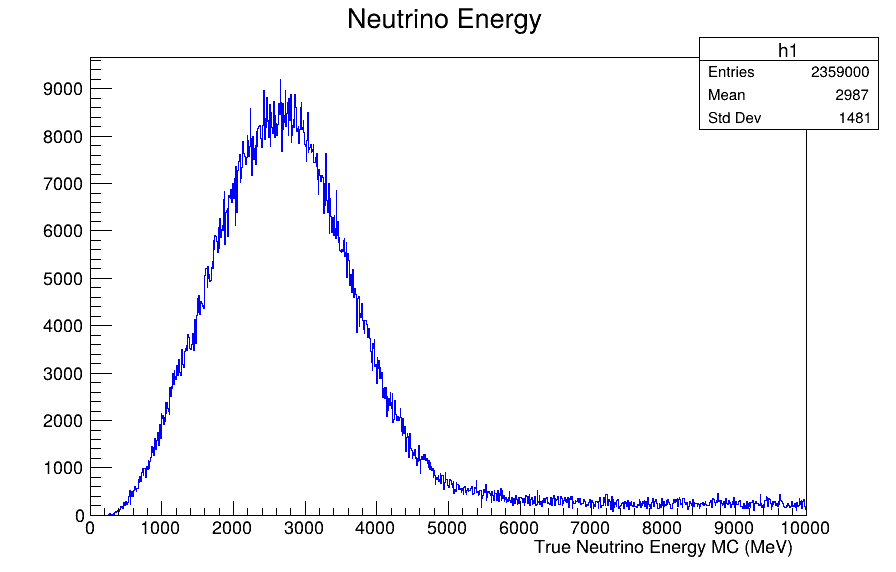

In [ ]:
c1 = ROOT.TCanvas("c", "Canvas", 900, 600)
h_nu = df.Histo1D(("h1", "Neutrino Energy", 999, 0, 10000), "Enu")

h_nu.GetXaxis().SetTitle("True Neutrino Energy MC (MeV)")
h_nu.SetLineColor(ROOT.kBlue)
h_nu.Draw("")

c1.Draw()

f_out.cd()
h_nu.GetValue().Write()

2577

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


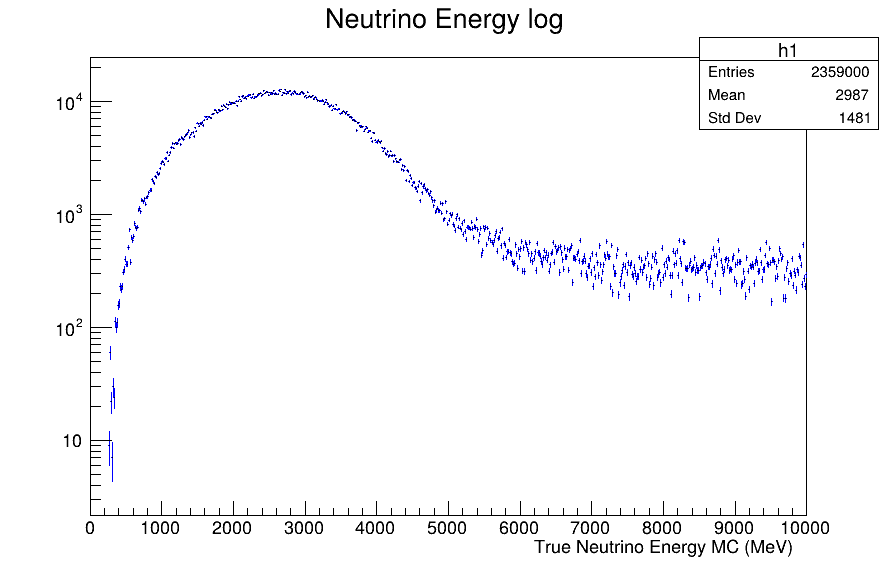

In [ ]:
#Neutrino energy spectrum of all the produced events 

c1 = ROOT.TCanvas("c", "Canvas", 900, 600)
#h_nu = df.Histo1D(("h1", "Neutrino Energy", 100, 0, 8000), "Enu")
h_nu_l = df.Histo1D(("h1", "Neutrino Energy log", 700, 0, 10000), "Enu")

h_nu_l.GetXaxis().SetTitle("True Neutrino Energy MC (MeV)")
c1.SetLogy()

h_nu_l.SetLineColor(ROOT.kBlue)


h_nu_l.Draw("E")

c1.Draw()

f_out.cd()
h_nu_l.GetValue().Write()

Interaction vertexes

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file xy_zy.pdf has been created


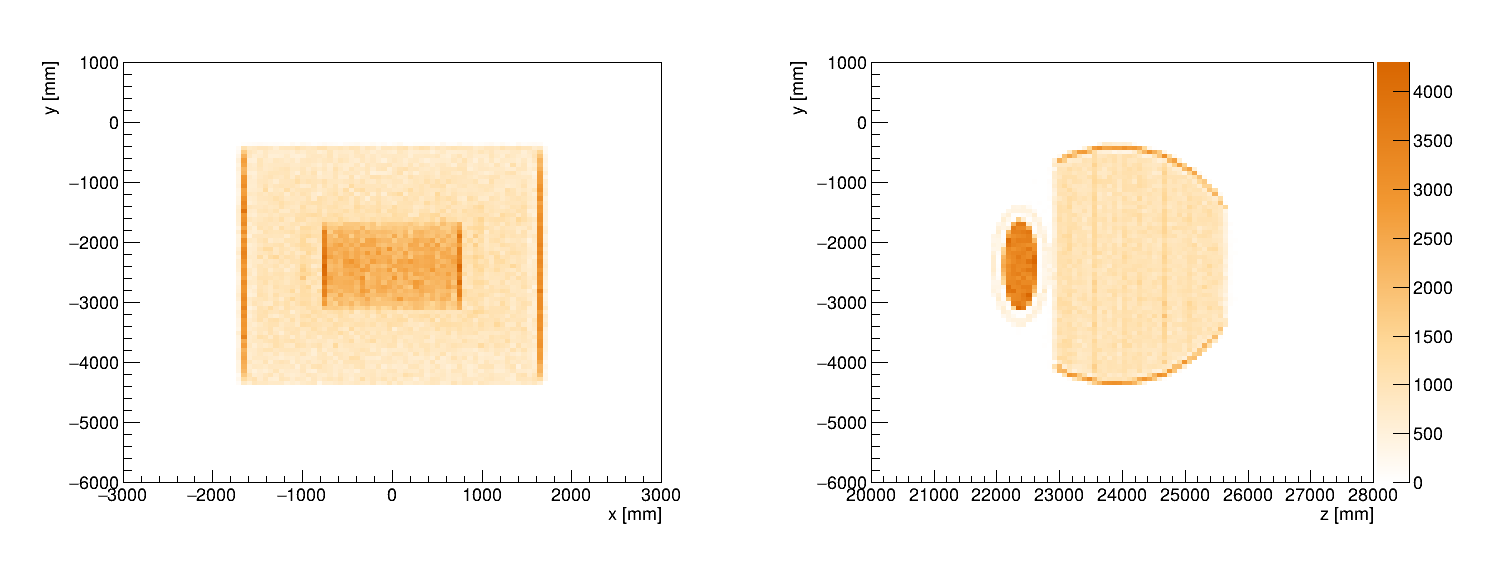

In [ ]:
from array import array

h_xy = df.Histo2D(("h_xy", "", 100, -3000, 3000, 100, -6000, 1000),"vertex_x", "vertex_y")
h_zy = df.Histo2D(("h_zy", "", 100, 20000, 28000, 100, -6000, 1000),"vertex_z", "vertex_y")

c = TCanvas("c1", "Canvas", 1500, 600)
c.Divide(2, 1)
c.Draw()

ROOT.gStyle.SetOptStat(0)
#ROOT.gStyle.SetPalette(1)


# ROOT.TColor.CreateGradientColorTable(
#     2,
#     array('d', [0.0, 1.0]),
#     array('d', [1.0, 0.0]),   # rosso: bianco → nero
#     array('d', [1.0, 0.0]),   # verde
#     array('d', [1.0, 0.0]),   # blu
#     255
# )

#stops  = [0.0, 0.3, 1.0]
# vals   = [1.0, 0.4, 0.0]   # 1 = bianco, 0 = nero
stops = [0.00, 0.33, 0.66, 1.00]
val_r = [1.00, 1.00, 0.95, 0.85]
val_g = [1.00, 0.85, 0.60, 0.40]
val_b = [1.00, 0.60, 0.20, 0.00]

ROOT.TColor.CreateGradientColorTable(
    len(stops),
    array('d', stops),
    array('d', val_r),  # R
    array('d', val_g),  # G
    array('d', val_b),  # B
    255
)



ROOT.gStyle.SetNumberContours(255)


c.cd(1)
pad1 = c.GetPad(1)
pad1.SetLeftMargin(0.15)   # margine sinistro più largo per la y
pad1.SetBottomMargin(0.15) # margine inferiore più largo per la x
# h_xy.SetStats(0)
# h_zy.SetStats(0)
h_xy.GetXaxis().SetTitle("x [mm]")
h_xy.GetYaxis().SetTitle("y [mm]")
h_xy.Draw("COL")

c.cd(2)
pad2 = c.GetPad(2)
pad2.SetLeftMargin(0.15)
pad2.SetRightMargin(0.15)
pad2.SetBottomMargin(0.15)
h_zy.GetXaxis().SetTitle("z [mm]")
h_zy.GetYaxis().SetTitle("y [mm]")
h_zy.Draw("COLZ")

# min_x = df.Min("vertex_x").GetValue()
# max_x = df.Max("vertex_x").GetValue()
# min_y = df.Min("vertex_y").GetValue()
# max_y = df.Max("vertex_y").GetValue()
# min_z = df.Min("vertex_z").GetValue()
# max_z = df.Max("vertex_z").GetValue()

# print(f"vertex_x: min = {min_x}, max = {max_x}")
# print(f"vertex_y: min = {min_y}, max = {max_y}")
# print(f"vertex_z: min = {min_z}, max = {max_z}")

c.SaveAs("xy_zy.pdf")


f_out.cd()
h_xy.GetValue().Write()
h_zy.GetValue().Write()


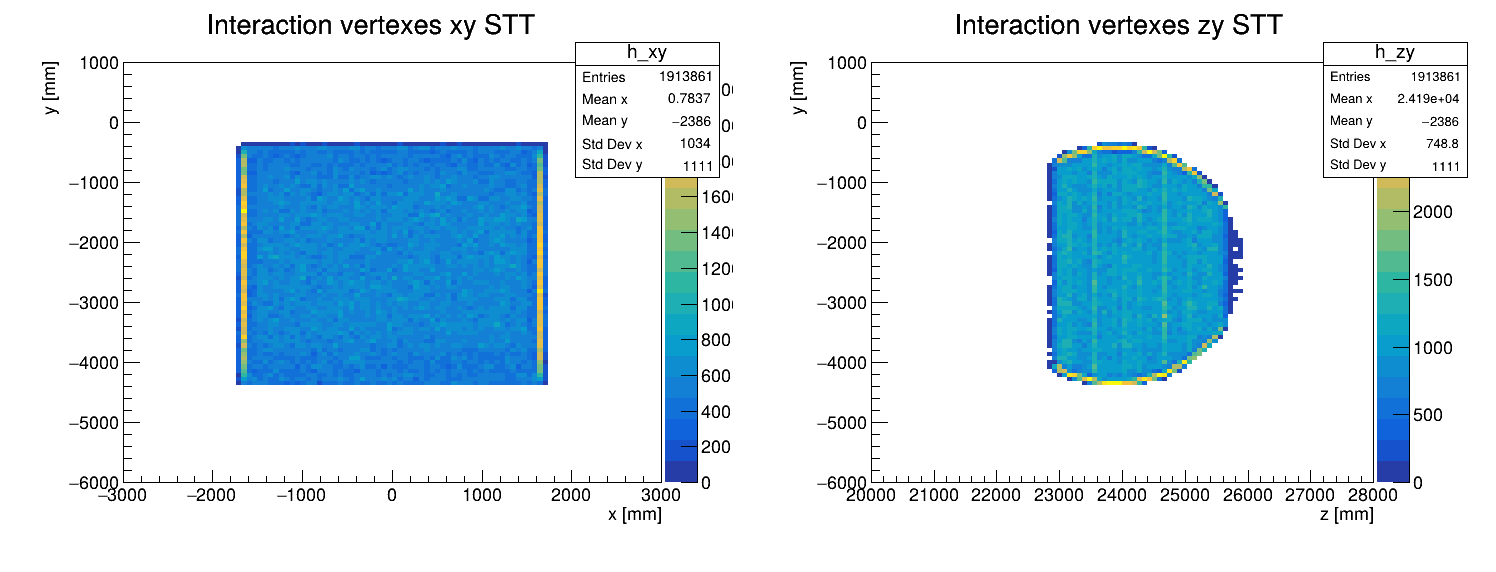

In [ ]:
#Events on STT tracker
df_V = df_flag.Filter("volume_flag == 1")

h_xy_V = df_V.Histo2D(("h_xy", " Interaction vertexes xy STT", 100, -3000, 3000, 100, -6000, 1000),"vertex_x", "vertex_y")
h_zy_V = df_V.Histo2D(("h_zy", " Interaction vertexes zy STT", 100, 20000, 28000, 100, -6000, 1000),"vertex_z", "vertex_y")

c_v = TCanvas("c1", "Canvas", 1500, 600)
c_v.Divide(2, 1)
c_v.Draw()

# ROOT.gStyle.SetOptStat(10)
# ROOT.gStyle.SetPalette(52)

c_v.cd(1)
pad1 = c_v.GetPad(1)
pad1.SetLeftMargin(0.15)   # margine sinistro più largo per la y
pad1.SetBottomMargin(0.15) # margine inferiore più largo per la x
# h_xy.SetStats(0)
# h_zy.SetStats(0)
h_xy_V.GetXaxis().SetTitle("x [mm]")
h_xy_V.GetYaxis().SetTitle("y [mm]")
h_xy_V.Draw("COLZ")

c_v.cd(2)
pad2 = c_v.GetPad(2)
pad2.SetLeftMargin(0.15)
pad2.SetRightMargin(0.15)
pad2.SetBottomMargin(0.15)
h_zy_V.GetXaxis().SetTitle("z [mm]")
h_zy_V.GetYaxis().SetTitle("y [mm]")
h_zy_V.Draw("COLZ")

# min_x = df.Min("vertex_x").GetValue()
# max_x = df.Max("vertex_x").GetValue()
# min_y = df.Min("vertex_y").GetValue()
# max_y = df.Max("vertex_y").GetValue()
# min_z = df.Min("vertex_z").GetValue()
# max_z = df.Max("vertex_z").GetValue()

# print(f"vertex_x: min = {min_x}, max = {max_x}")
# print(f"vertex_y: min = {min_y}, max = {max_y}")
# print(f"vertex_z: min = {min_z}, max = {max_z}")

# c.SaveAs("xy_zy.png")


f_out.cd()
h_xy_V.GetValue().Write()
h_zy_V.GetValue().Write()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file zy_pl.pdf has been created


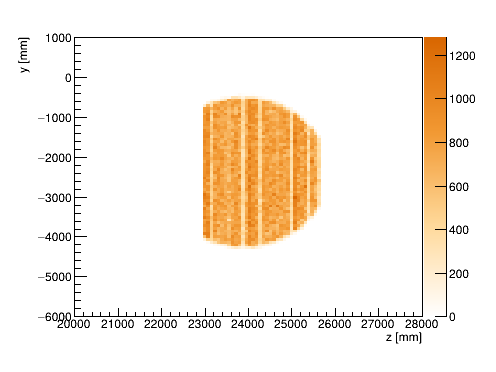

In [ ]:
#events on plastic 

h_xy_Pl = df_V.Filter('Where_int == "C3H6"').Histo2D(("h_xy_Pl", " Interaction vertexes xy in C3H6", 100, -3000, 3000, 100, -6000, 1000),"vertex_x", "vertex_y")
h_zy_Pl = df_V.Filter('Where_int == "C3H6"').Histo2D(("h_zy_Pl", " ", 100, 20000, 28000, 100, -6000, 1000),"vertex_z", "vertex_y")

# c_p = TCanvas("c1", "Canvas", 1500, 600)
c_p = TCanvas("c1", "Canvas", 500, 400)
# c_p.Divide(2, 1)

# ROOT.gStyle.SetOptStat(10)

# c_p.cd(1)
# pad1 = c_p.GetPad(1)
# pad1.SetLeftMargin(0.15)   
# pad1.SetBottomMargin(0.15) 
# # h_xy.SetStats(0)
# # h_zy.SetStats(0)
# h_xy_Pl.GetXaxis().SetTitle("x [mm]")
# h_xy_Pl.GetYaxis().SetTitle("y [mm]")
# h_xy_Pl.Draw("COL")

# c_p.cd(2)
# pad2 = c_p.GetPad(2)
# pad2.SetLeftMargin(0.15)
# pad2.SetBottomMargin(0.15)
# pad2.SetRightMargin(0.15)


c_p.SetLeftMargin(0.15)
c_p.SetBottomMargin(0.15)
c_p.SetRightMargin(0.15)

h_zy_Pl.GetXaxis().SetTitle("z [mm]")
h_zy_Pl.GetYaxis().SetTitle("y [mm]")
h_zy_Pl.Draw("COLZ")

c_p.Draw()
c_p.SaveAs("zy_pl.pdf")



f_out.cd()
#h_xy_Pl.GetValue().Write()
h_zy_Pl.GetValue().Write()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file zy_gr.pdf has been created


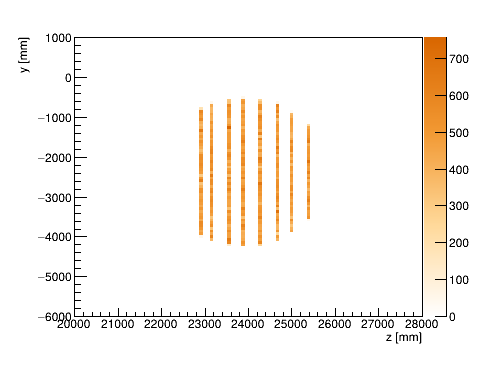

In [ ]:
#Events on graphite

h_xy_G = df_V.Filter('Where_int == "Graphite"').Histo2D(("h_xy_G", "Interaction vertexes xy in Graphite", 100, -3000, 3000, 100, -6000, 1000),"vertex_x", "vertex_y")
h_zy_G = df_V.Filter('Where_int == "Graphite"').Histo2D(("h_zy_G", " ", 100, 20000, 28000, 100, -6000, 1000),"vertex_z", "vertex_y")

c_g = TCanvas("c1", "Canvas", 500, 400)
# c_g.Divide(2, 1)

# ROOT.gStyle.SetOptStat(10)
# ROOT.gStyle.SetPalette(52)

# c_g.cd(1)
# pad1 = c_g.GetPad(1)
# pad1.SetLeftMargin(0.15)   # margine sinistro più largo per la y
# pad1.SetBottomMargin(0.15) # margine inferiore più largo per la x
# # h_xy.SetStats(0)
# # h_zy.SetStats(0)
# h_xy_G.GetXaxis().SetTitle("x [mm]")
# h_xy_G.GetYaxis().SetTitle("y [mm]")
# h_xy_G.Draw("COL")

# c_g.cd(2)
# pad2 = c_g.GetPad(2)
# pad2.SetLeftMargin(0.15)
# pad2.SetBottomMargin(0.15)

c_g.SetLeftMargin(0.15)
c_g.SetBottomMargin(0.15)
c_g.SetRightMargin(0.15)

h_zy_G.GetXaxis().SetTitle("z [mm]")
h_zy_G.GetYaxis().SetTitle("y [mm]")
h_zy_G.Draw("COLZ")

c_g.Draw()
c_g.SaveAs("zy_gr.pdf")

f_out.cd()
#h_xy_G.GetValue().Write()
h_zy_G.GetValue().Write()

Transverse momentum

input_line_194:2:10: error: redefinition of 'transverse_momentum'
Double_t transverse_momentum( ROOT::VecOps::RVec<double> primaries_px, ROOT::VecOps::RVec<double> primaries_py, ROOT::VecOps::RVec<double> primaries_pz,
         ^
input_line_110:2:10: note: previous definition is here
Double_t transverse_momentum( ROOT::VecOps::RVec<double> primaries_px, ROOT::VecOps::RVec<double> primaries_py, ROOT::VecOps::RVec<double> primaries_pz,
         ^
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_tr


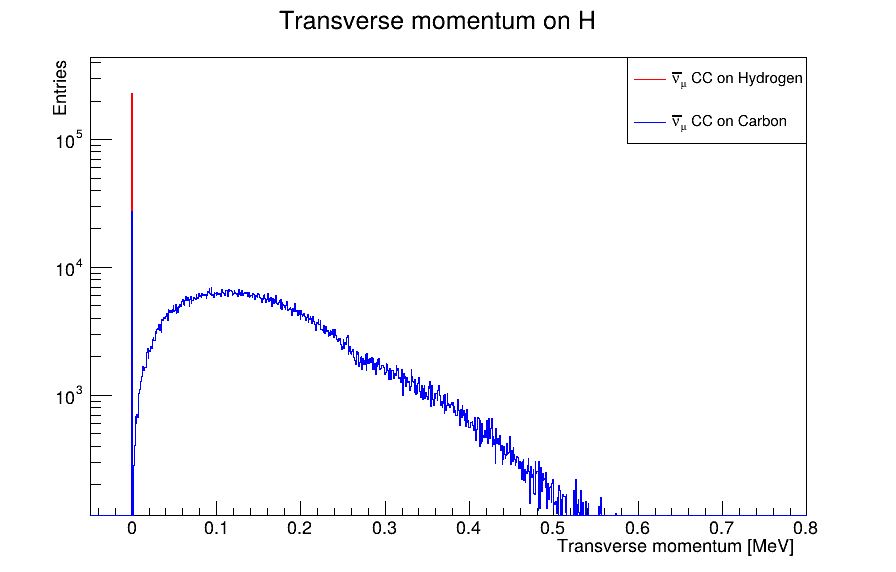

In [14]:
ROOT.gInterpreter.Declare("""
Double_t transverse_momentum( ROOT::VecOps::RVec<double> primaries_px, ROOT::VecOps::RVec<double> primaries_py, ROOT::VecOps::RVec<double> primaries_pz,
                              Double_t px_nu , Double_t py_nu, Double_t pz_nu) {

    TVector3 v1( px_nu, py_nu,pz_nu);
    TVector3 v2(Sum(primaries_px), Sum(primaries_py), Sum(primaries_pz));

    Double_t transvers_mom = v2.Perp(v1);

    return transvers_mom;
}
                          
                          """)

df_Tr_mom = (df.Define("transverse_mom", "transverse_momentum(primaries_px, primaries_py, primaries_pz, pxnu, pynu, pznu)")
      .Define("transverse_mom_GeV", "transverse_mom/1000.0")
      
)


ROOT.gStyle.SetOptStat(0)

h_H_tr = df_Tr_mom.Filter('target == "tgt:1000010010"').Histo1D(("h_H", "Transverse momentum on H ", 1000, -0.05, 0.8), "transverse_mom_GeV")
h_C_tr = df_Tr_mom.Filter('target == "tgt:1000060120"').Histo1D(("h_C", " Transverse momentum on C", 1000, -0.05, 0.8), "transverse_mom_GeV")


c_tr = TCanvas("c_tr", "Canvas", 900, 600)
c_tr.SetLogy()

h_H_tr.SetLineColor(kRed)
h_C_tr.SetLineColor(kBlue)

h_H_tr.GetXaxis().SetTitle("Transverse momentum [MeV]")
h_H_tr.GetYaxis().SetTitle("Entries")
h_H_tr.GetYaxis().SetTitleOffset(0.6)

h_H_tr.Draw("HIST")
h_C_tr.Draw("HIST SAME")

# Legenda
# h_H.SetStats(10)
# h_C.SetStats(10)
# gPad.SetLeftMargin(0.15)

leg = TLegend(0.7, 0.75, 0.9, 0.9)
leg.AddEntry(h_H_tr.GetPtr(), "#bar{#nu}_{#mu} CC on Hydrogen", "l")
leg.AddEntry(h_C_tr.GetPtr(), "#bar{#nu}_{#mu} CC on Carbon", "l")
leg.Draw()

c_tr.Draw()
# c_tr.SaveAs("tr_mom.pdf")

# f_out.cd()
# h_H_tr.GetValue().Write()
# h_C_tr.GetValue().Write()


In [24]:
#done with categories

# ROOT.gStyle.SetOptStat(0)

# h_H = df_Tr_mom.Filter("Evt_cat == 1 || Evt_cat == 3 || Evt_cat == 5").Histo1D(("h_H", " ", 100, -0.05, 0.5), "transverse_mom_GeV")
# h_C = df_Tr_mom.Filter("Evt_cat == 2 || Evt_cat == 4").Histo1D(("h_C", " ", 100, -0.05, 0.5), "transverse_mom_GeV")


# c_tr = TCanvas("c_tr", "Canvas", 900, 600)
# c_tr.SetLogy()

# h_H.SetLineColor(kRed)
# h_C.SetLineColor(kBlue)

# h_H.GetXaxis().SetTitle("Transverse momentum [GeV]")
# h_H.GetYaxis().SetTitle("Entries")
# h_H.GetYaxis().SetTitleOffset(0.6)

# h_H.Draw("HIST")
# h_C.Draw("HIST SAME")

# # Legenda
# # h_H.SetStats(10)
# # h_C.SetStats(10)
# # gPad.SetLeftMargin(0.15)

# leg = TLegend(0.7, 0.75, 0.9, 0.9)
# leg.AddEntry(h_H.GetPtr(), "#bar{#nu}_{#mu} CC on Hydrogen", "l")
# leg.AddEntry(h_C.GetPtr(), "#bar{#nu}_{#mu} CC on Carbon", "l")
# leg.Draw()

# c_tr.Draw()

In [13]:
df_Tr_mom.Filter('target == "tgt:1000060120" && transverse_mom_GeV == 0.0').Display(["Where_int", "st_proc_type","primaries_PDG"],50).Print()
del df_Tr_mom

NameError: name 'df_Tr_mom' is not defined

In [26]:
# #splitting hadrons and leptons 

# ROOT.gInterpreter.Declare("""
# /*function to obtain the hadronic state, (no leptons, no photons, no pseudo-particles pdg 91,92,93)*/
# ROOT::VecOps::RVec<Double_t> had_momentum(const ROOT::VecOps::RVec<Int_t>& pdg, const ROOT::VecOps::RVec<Double_t>& mom) {
#     ROOT::VecOps::RVec<Double_t> had_mom;
 
#     for (size_t i = 0; i < pdg.size(); ++i) {
#         if (pdg[i] != -13 && pdg[i] != 13 && pdg[i] != 11 && pdg[i] != -11 && pdg[i] != 22 && pdg[i] != 91 && pdg[i] != 92 && pdg[i] != 93 ) {
#             had_mom.push_back(mom[i]);
#         }
#     }

#     return had_mom;  
# }

# /*function to obtain the leptonic state, (electrons and muons and photons(RES))*/
# ROOT::VecOps::RVec<Double_t> lep_momentum(const ROOT::VecOps::RVec<Int_t>& pdg, const ROOT::VecOps::RVec<Double_t>& mom) {

#     ROOT::VecOps::RVec<Double_t> lep_mom;
 
#     for (size_t i = 0; i < pdg.size(); ++i) {
#         if (pdg[i] == -13 || pdg[i] == 13 && pdg[i] == 11 || pdg[i] == -11 || pdg[i] == 22
#                           ) {
#             lep_mom.push_back(mom[i]);
#         }
#     }

#     return lep_mom;   
# }

# /*function to obtain the transverse momentum wrt to the neutrino direction*/
# Double_t transverse_momentum( ROOT::VecOps::RVec<double> lep_px, ROOT::VecOps::RVec<double> lep_py, ROOT::VecOps::RVec<double> lep_pz,
#                               ROOT::VecOps::RVec<double> had_px, ROOT::VecOps::RVec<double> had_py, ROOT::VecOps::RVec<double> had_pz,
#                               Double_t px_nu , Double_t py_nu, Double_t pz_nu) {
                                
#     auto sl_x = ROOT::VecOps::Sum(lep_px);
#     auto sl_y = ROOT::VecOps::Sum(lep_py);
#     auto sl_z = ROOT::VecOps::Sum(lep_pz);

#     auto sh_x = ROOT::VecOps::Sum(had_px);
#     auto sh_y = ROOT::VecOps::Sum(had_py);
#     auto sh_z = ROOT::VecOps::Sum(had_pz);

#     TVector3 v1( px_nu, py_nu,pz_nu);
#     TVector3 v2(sl_x + sh_x, sl_y + sh_y, sl_z + sh_z);

#     Double_t transvers_mom = v2.Perp(v1);
#     return transvers_mom;

# }
# """)

# # ROOT.gInterpreter.Declare("""
# # bool IsMuonNeutron(const ROOT::VecOps::RVec<int>& pdgs) {
# #     if (pdgs.size() != 2) return false;
# #     return ((pdgs[0] == -13 && pdgs[1] == 2112) || (pdgs[0] == 2112 && pdgs[1] == -13));
# # }
# # """)
# #df_vol = df.Filter("vertex_z > 22800")

# df_Tr_mom = (
#     df.Define("had_px", "had_momentum(primaries_PDG, primaries_px)")
#       .Define("had_py", "had_momentum(primaries_PDG, primaries_py)")
#       .Define("had_pz", "had_momentum(primaries_PDG, primaries_pz)")
#       .Define("lep_px", "lep_momentum(primaries_PDG, primaries_px)")
#       .Define("lep_py", "lep_momentum(primaries_PDG, primaries_py)")
#       .Define("lep_pz", "lep_momentum(primaries_PDG, primaries_pz)")
#       .Define("transverse_mom", "transverse_momentum(lep_px, lep_py, lep_pz, had_px, had_py, had_pz, pxnu, pynu, pznu)")
#       .Define("transverse_mom_GeV", "transverse_mom/1000.0")
#       #.Define("selection", "IsMuonNeutron(primaries_PDG)")
# )

# # df_selected = df_Tr_mom.Filter("selection == true")

# # h_H = df_selected.Filter('target == "tgt:1000010010"').Histo1D(("h_H", " ", 500, -0.05, 0.8), "transverse_mom_GeV")
# # h_C = df_selected.Filter('target == "tgt:1000060120"').Histo1D(("h_C", " ", 500, -0.05, 0.8), "transverse_mom_GeV")


# ROOT.gStyle.SetOptStat(0)

# h_H = df_Tr_mom.Filter('target == "tgt:1000010010"').Histo1D(("h_H", " ", 500, -0.05, 1), "transverse_mom_GeV")
# h_C = df_Tr_mom.Filter('target == "tgt:1000060120"').Histo1D(("h_C", " ", 500, -0.05, 1), "transverse_mom_GeV")


# c_tr = TCanvas("c_tr", "Canvas", 900, 600)
# c_tr.SetLogy()

# h_H.SetLineColor(kRed)
# h_C.SetLineColor(kBlue)

# h_H.GetXaxis().SetTitle("Transverse momentum [GeV]")
# h_H.GetYaxis().SetTitle("Entries")
# h_H.GetYaxis().SetTitleOffset(0.6)

# h_H.Draw("HIST")
# h_C.Draw("HIST SAME")

# # Legenda
# # h_H.SetStats(10)
# # h_C.SetStats(10)
# # gPad.SetLeftMargin(0.15)

# leg = TLegend(0.7, 0.75, 0.9, 0.9)
# leg.AddEntry(h_H.GetPtr(), "#bar{#nu}_{#mu} CC on Hydrogen", "l")
# leg.AddEntry(h_C.GetPtr(), "#bar{#nu}_{#mu} CC on Carbon", "l")
# leg.Draw()

# c_tr.Draw()
# #c_tr.SaveAs("CC_target_selection.png")
# #del df_Tr_mom

Types of events on Plastic and Graphite

Info in <TCanvas::Print>: png file plastic_comp.png has been created
Info in <TCanvas::Print>: pdf file plastic_comp.pdf has been created


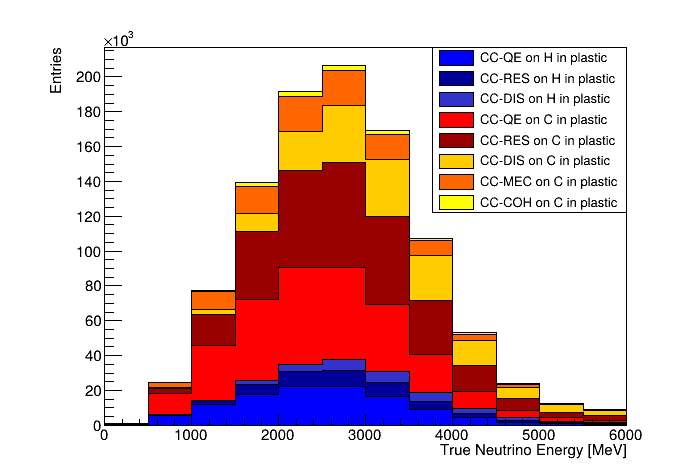

In [8]:
#Events on plastic 
nbin = 12 
nmin = 0
nmax = 6000


ROOT.gStyle.SetHistLineColor(ROOT.kBlack)

hist_h1 = df_V.Filter("Evt_cat == 1").Histo1D(("hist_1", "", nbin, nmin, nmax),"Enu")
# hist_h2 = df.Filter('target == "tgt:1000010010" && Where_int == "C3H6" && st_proc_type == "proc:Weak[CC],MEC"').Histo1D(("hist_h2", "", 10, 0, 10000),"Enu")
# hist_h3 = df.Filter('target == "tgt:1000010010" && Where_int == "C3H6" && st_proc_type == "proc:Weak[CC],COH"').Histo1D(("hist_h3", "", 10, 0, 10000),"Enu")
hist_h4 = df_V.Filter('target == "tgt:1000010010" && Where_int == "C3H6" && st_proc_type == "proc:Weak[CC],RES"').Histo1D(("hist_h4", "", nbin, nmin, nmax),"Enu")
hist_h5 = df_V.Filter('target == "tgt:1000010010" && Where_int == "C3H6" && st_proc_type == "proc:Weak[CC],DIS"').Histo1D(("hist_h5", "", nbin, nmin, nmax),"Enu")
hist_c1 = df_V.Filter("Evt_cat == 2").Histo1D(("hist_2", "", nbin, nmin, nmax),"Enu")
hist_c2 = df_V.Filter('target == "tgt:1000060120" && st_proc_type == "proc:Weak[CC],RES" && Where_int == "C3H6"').Histo1D(("hist_h5", "", nbin, nmin, nmax),"Enu")
hist_c3 = df_V.Filter('target == "tgt:1000060120" && st_proc_type == "proc:Weak[CC],DIS" && Where_int == "C3H6"').Histo1D(("hist_h5", "", nbin, nmin, nmax),"Enu")
hist_c4 = df_V.Filter('target == "tgt:1000060120" && st_proc_type == "proc:Weak[CC],MEC" && Where_int == "C3H6"').Histo1D(("hist_h5", "", nbin, nmin, nmax),"Enu")
hist_c5 = df_V.Filter('target == "tgt:1000060120" && st_proc_type == "proc:Weak[CC],COH" && Where_int == "C3H6"').Histo1D(("hist_h5", "", nbin, nmin, nmax),"Enu")

hist_h1.SetFillColor(ROOT.kBlue)
# hist_h2.SetFillColor(ROOT.kCyan)
# hist_h3.SetFillColor(ROOT.kCyan-9)
hist_h4.SetFillColor(ROOT.kBlue+2)
hist_h5.SetFillColor(ROOT.kBlue-3)

hist_c1.SetFillColor(ROOT.kRed)
hist_c2.SetFillColor(ROOT.kRed+2)
hist_c3.SetFillColor(ROOT.kOrange)
hist_c4.SetFillColor(ROOT.kOrange+7)
hist_c5.SetFillColor(ROOT.kYellow)

stack = ROOT.THStack("stack", " ")
stack.Add(hist_h1.GetPtr())
# stack.Add(hist_h2.GetPtr())
# stack.Add(hist_h3.GetPtr())
stack.Add(hist_h4.GetPtr())
stack.Add(hist_h5.GetPtr())

stack.Add(hist_c1.GetPtr())
stack.Add(hist_c2.GetPtr())
stack.Add(hist_c3.GetPtr())
stack.Add(hist_c4.GetPtr())
stack.Add(hist_c5.GetPtr())


c = ROOT.TCanvas()
c.SetLeftMargin(0.15)

stack.Draw("HIST")
stack.GetXaxis().SetTitle("True Neutrino Energy [MeV]")
stack.GetYaxis().SetTitle("Entries")

legend = ROOT.TLegend(0.62, 0.55, 0.90, 0.90)


legend.AddEntry(hist_h1.GetPtr(), "CC-QE on H in plastic", "f")
# legend.AddEntry(hist_h2.GetPtr(), "CC-MEC on H in plastic", "f")
# legend.AddEntry(hist_h3.GetPtr(), "CC-COH on H in plastic", "f")
legend.AddEntry(hist_h4.GetPtr(), "CC-RES on H in plastic", "f")
legend.AddEntry(hist_h5.GetPtr(), "CC-DIS on H in plastic", "f")

legend.AddEntry(hist_c1.GetPtr(), "CC-QE on C in plastic", "f")
legend.AddEntry(hist_c2.GetPtr(), "CC-RES on C in plastic", "f")
legend.AddEntry(hist_c3.GetPtr(), "CC-DIS on C in plastic", "f")
legend.AddEntry(hist_c4.GetPtr(), "CC-MEC on C in plastic", "f")
legend.AddEntry(hist_c5.GetPtr(), "CC-COH on C in plastic", "f")

legend.Draw()

c.Draw()
c.SaveAs("plastic_comp.png")
c.SaveAs("plastic_comp.pdf")


# f_out.cd()
# hist_h1.GetValue().Write()
# hist_h4.GetValue().Write()
# hist_h5.GetValue().Write()
# hist_c1.GetValue().Write()
# hist_c2.GetValue().Write()
# hist_c3.GetValue().Write()
# hist_c4.GetValue().Write()
# hist_c5.GetValue().Write()

# stack.Write()

Info in <TCanvas::Print>: png file graph.png has been created
Info in <TCanvas::Print>: pdf file graph.pdf has been created


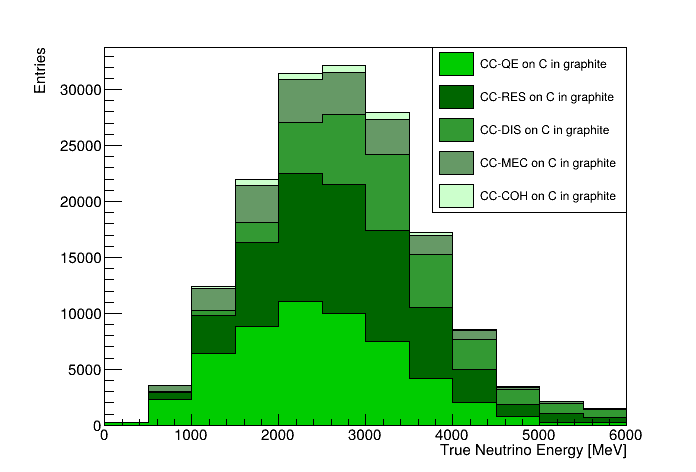

In [9]:
#events on graphite 
nbin = 12
nmin = 0
nmax = 6000


hist_g1 = df_V.Filter("Evt_cat == 4").Histo1D(("hist_4", "", nbin, nmin, nmax),"Enu")
hist_g2 = df_V.Filter('target == "tgt:1000060120" && st_proc_type == "proc:Weak[CC],RES" && Where_int == "Graphite"').Histo1D(("hist_h5", "", nbin, nmin, nmax),"Enu")
hist_g3 = df_V.Filter('target == "tgt:1000060120" && st_proc_type == "proc:Weak[CC],DIS" && Where_int == "Graphite"').Histo1D(("hist_h5", "", nbin,nmin, nmax),"Enu")
hist_g4 = df_V.Filter('target == "tgt:1000060120" && st_proc_type == "proc:Weak[CC],MEC" && Where_int == "Graphite"').Histo1D(("hist_h5", "", nbin,nmin, nmax),"Enu")
hist_g5 = df_V.Filter('target == "tgt:1000060120" && st_proc_type == "proc:Weak[CC],COH" && Where_int == "Graphite"').Histo1D(("hist_h5", "", nbin,nmin, nmax),"Enu")

hist_g1.SetFillColor(ROOT.kGreen+1)
hist_g2.SetFillColor(ROOT.kGreen+3)
# hist_g3.SetFillColor(ROOT.kViolet)
# hist_g4.SetFillColor(ROOT.kPink+6)
hist_g3.SetFillColor(ROOT.kGreen-2)
hist_g4.SetFillColor(ROOT.kGreen-5)
hist_g5.SetFillColor(ROOT.kGreen-10)

stack2 = ROOT.THStack("stack2", " ")
stack2.Add(hist_g1.GetPtr())
stack2.Add(hist_g2.GetPtr())
stack2.Add(hist_g3.GetPtr())
stack2.Add(hist_g4.GetPtr())
stack2.Add(hist_g5.GetPtr())

c = ROOT.TCanvas()
c.SetLeftMargin(0.15)

stack2.Draw("HIST")
stack2.GetXaxis().SetTitle("True Neutrino Energy [MeV]")
stack2.GetYaxis().SetTitle("Entries")

legend = ROOT.TLegend(0.62, 0.55, 0.90, 0.90)
legend.AddEntry(hist_g1.GetPtr(), "CC-QE on C in graphite", "f")
legend.AddEntry(hist_g2.GetPtr(), "CC-RES on C in graphite", "f")
legend.AddEntry(hist_g3.GetPtr(), "CC-DIS on C in graphite", "f")
legend.AddEntry(hist_g4.GetPtr(), "CC-MEC on C in graphite", "f")
legend.AddEntry(hist_g5.GetPtr(), "CC-COH on C in graphite", "f")

legend.Draw()

c.Draw()
c.SaveAs("graph.png")
c.SaveAs("graph.pdf")


# f_out.cd()
# hist_g1.GetValue().Write()
# hist_g2.GetValue().Write()
# hist_g3.GetValue().Write()
# hist_g4.GetValue().Write()
# hist_g5.GetValue().Write()

# stack2.Write()



In [10]:
del df_V

MUON MOMENTUM

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


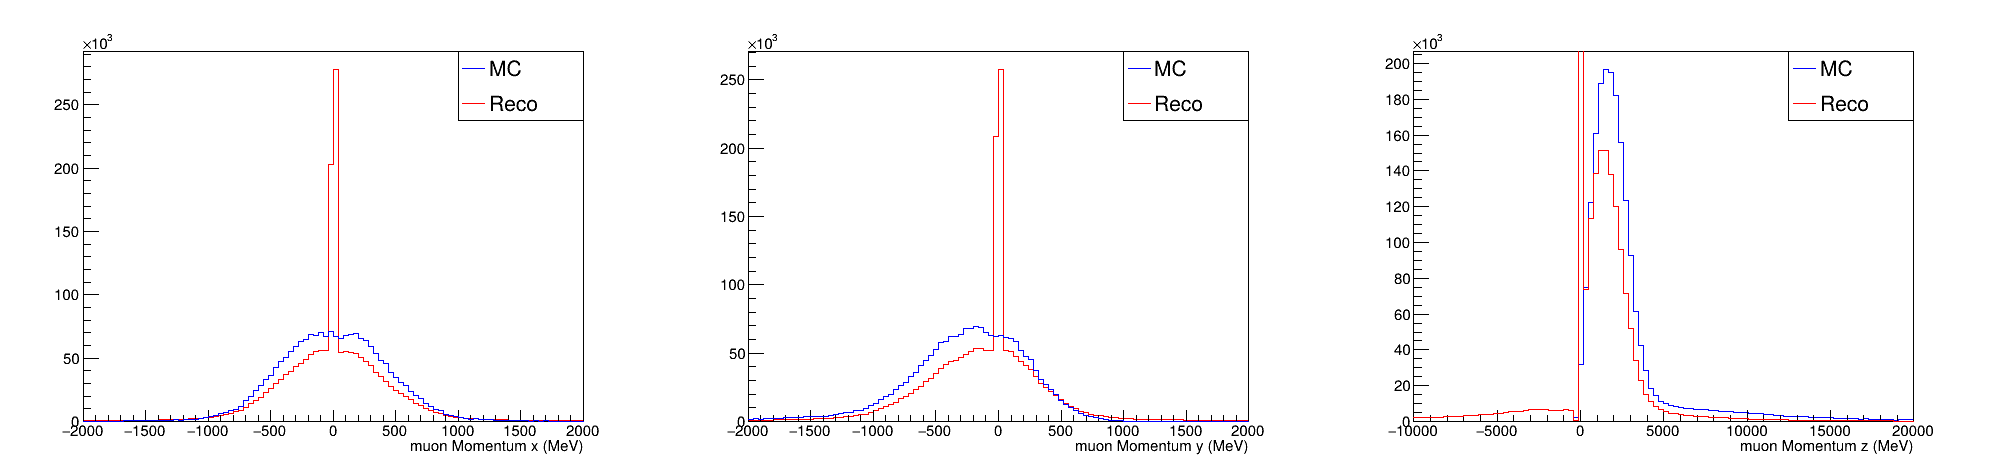

In [30]:
#muon momentum components for all the events 
gDF = df_flag.Filter("volume_flag == 1") 

gH7 =  gDF.Histo1D(("h1", "  ", 100, -2000, 2000),"mu_px")        #histo mu momentum MC
gH8 =  gDF.Histo1D(("h2", " ", 100, -2000, 2000),"mu_py")      #histo mu momentum 
gH9 =  gDF.Histo1D(("h3", " ", 100, -10000, 20000),"mu_pz")    #histo mu momentum 

gH10 = gDF.Histo1D(("h4", " ", 100, -2000, 2000), "mu_pxreco")
gH11 = gDF.Histo1D(("h5", " ", 100, - 2000, 2000), "mu_pyreco")
gH12 = gDF.Histo1D(("h6", " ", 100,  -10000, 20000), "mu_pzreco")

c4 = TCanvas("c1", "Canvas", 2000, 500)
c4.Divide(3, 1)

c4.cd(1)
# gH7->SetTitle("");  // Set histogram title
gH7.GetXaxis().SetTitle("muon Momentum x (MeV)")
gH7.SetLineColor(ROOT.kBlue)
gH10.SetLineColor(ROOT.kRed)
gH10.GetXaxis().SetTitle("muon Momentum x (MeV)")
gH10.Draw()
gH7.Draw("SAME")

legend1 = TLegend(0.7, 0.75, 0.9, 0.9)   # (x1,y1,x2,y2) in coordinate NDC
legend1.AddEntry(gH7.GetPtr(), "MC", "l")
legend1.AddEntry(gH10.GetPtr(), "Reco", "l")
legend1.Draw()

c4.cd(2)
# gH8->SetTitle("");  # Set histogram title
gH8.GetXaxis().SetTitle("muon Momentum y (MeV)")
gH8.SetLineColor(ROOT.kBlue)
gH11.SetLineColor(ROOT.kRed)
gH11.GetXaxis().SetTitle("muon Momentum y (MeV)")
gH11.Draw()
gH8.Draw("SAME")

legend2 = TLegend(0.7, 0.75, 0.9, 0.9)
legend2.AddEntry(gH8.GetPtr(), "MC", "l")
legend2.AddEntry(gH11.GetPtr(), "Reco", "l")
legend2.Draw()

c4.cd(3)
# gH9->SetTitle("");  // Set histogram title
gH9.GetXaxis().SetTitle("muon Momentum z (MeV)")
gH9.SetLineColor(ROOT.kBlue)
gH12.SetLineColor(ROOT.kRed)
gH9.Draw()
gH12.Draw("SAME")

legend3 = TLegend(0.7, 0.75, 0.9, 0.9)
legend3.AddEntry(gH9.GetPtr(), "MC", "l")
legend3.AddEntry(gH12.GetPtr(), "Reco", "l")
legend3.Draw()

c4.Draw()
# c4.SaveAs("zoom_17_09_Mu_momentumXYZ.png");

#del gDF

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


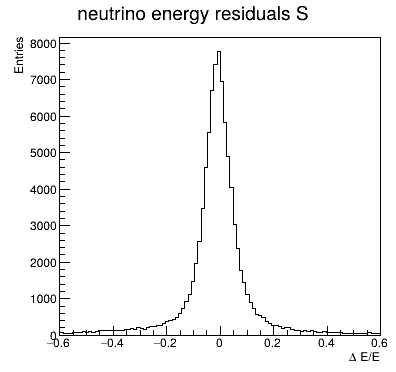

In [31]:
h_P = gDF.Histo1D(("h_P", "  ", 1000, -10, 7000),"mu_P")   
h_Preco = gDF.Histo1D(("h_Preco", " ", 1000, -10, 7000),"mu_Preco") 
h_reco_true = gDF.Histo2D(("h_reco_true", " ", 100, 0, 7000, 100, 0, 7000), "mu_Preco","mu_P")

ROOT.gStyle.SetOptStat(0)

c = TCanvas("c", "Canvas", 1000, 500)
c.Divide(2,1)

h_P.GetXaxis().SetTitle("muon Momentum (MeV)")
h_P.SetLineColor(ROOT.kBlue)
h_Preco.SetLineColor(ROOT.kRed)
h_Preco.GetXaxis().SetTitle("muon momentum (MeV)")
h_P.GetYaxis().SetTitle("Entries")

c.cd(1)
ROOT.gPad.SetLeftMargin(0.20)
ROOT.gPad.SetBottomMargin(0.15)
h_P.Draw()
h_Preco.Draw("SAME")

legend3 = TLegend(0.7, 0.75, 0.9, 0.9)
legend3.AddEntry(h_P.GetPtr(), "True", "l")
legend3.AddEntry(h_Preco.GetPtr(), "Reco", "l")
legend3.Draw()


c.cd(2)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.15)
ROOT.gPad.SetBottomMargin(0.15)
h_reco_true.GetXaxis().SetTitle("reco P#mu (MeV)")
h_reco_true.GetYaxis().SetTitle("true P#mu (MeV)")
h_reco_true.Draw("COLZ")


c.Draw()

In [32]:
del gDF

EVENTS with a SUCCESSFUL RECO 

Muon momentum plots

In [33]:
gDF2 = df_flag.Filter("volume_flag == 1 && reco_flag == 1")

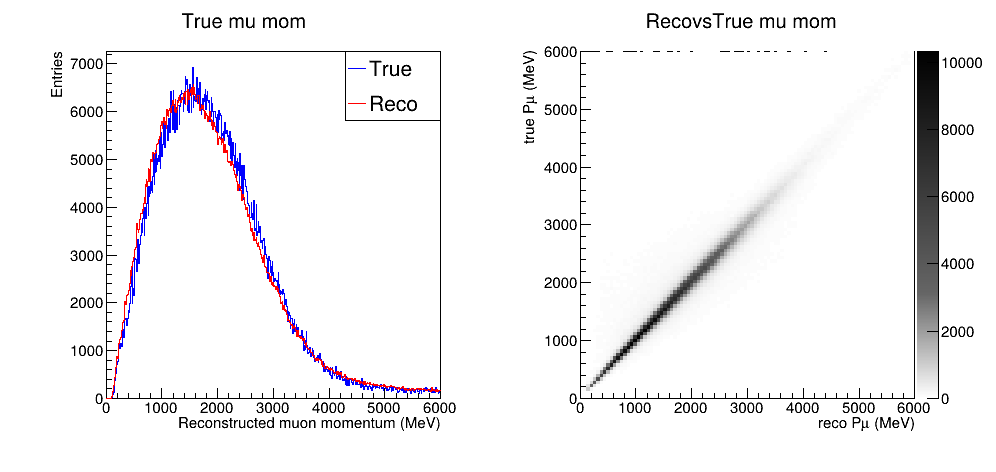

In [34]:
#total muon momentum 
#%jsroot
h_P2 = gDF2.Histo1D(("h_P", " True mu mom ", 500, 0, 6000),"mu_P")   
h_Preco2 = gDF2.Histo1D(("h_Preco", "Reco mu mom ", 500, 0, 6000),"mu_Preco") 
h_reco_true2 = gDF2.Histo2D(("h_reco_true", " RecovsTrue mu mom ", 100, 0, 6000, 100, 0, 6000), "mu_Preco","mu_P")

ROOT.gStyle.SetOptStat(0)

c2 = TCanvas("c2", "Canvas", 1000, 500)
c2.Divide(2,1)

h_P2.GetXaxis().SetTitle("Reconstructed muon momentum (MeV)")
h_P2.SetLineColor(ROOT.kBlue)
h_Preco2.SetLineColor(ROOT.kRed)
h_Preco2.GetXaxis().SetTitle("Reconstructed muon momentum (MeV)")
h_P2.GetYaxis().SetTitle("Entries")

c2.cd(1)
ROOT.gPad.SetLeftMargin(0.20)
ROOT.gPad.SetBottomMargin(0.15)
h_P2.Draw()
h_Preco2.Draw("SAME")

legend3 = TLegend(0.7, 0.75, 0.9, 0.9)
legend3.AddEntry(h_P2.GetPtr(), "True", "l")
legend3.AddEntry(h_Preco2.GetPtr(), "Reco", "l")
legend3.Draw()


c2.cd(2)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.15)
ROOT.gPad.SetBottomMargin(0.15)
h_reco_true2.GetXaxis().SetTitle("reco P#mu (MeV)")
h_reco_true2.GetYaxis().SetTitle("true P#mu (MeV)")
h_reco_true2.Draw("COLZ")


c2.Draw()

# f_out.cd()
# h_P2.GetValue().Write()   
# h_Preco2.GetValue().Write() 
# h_reco_true2.GetValue().Write()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


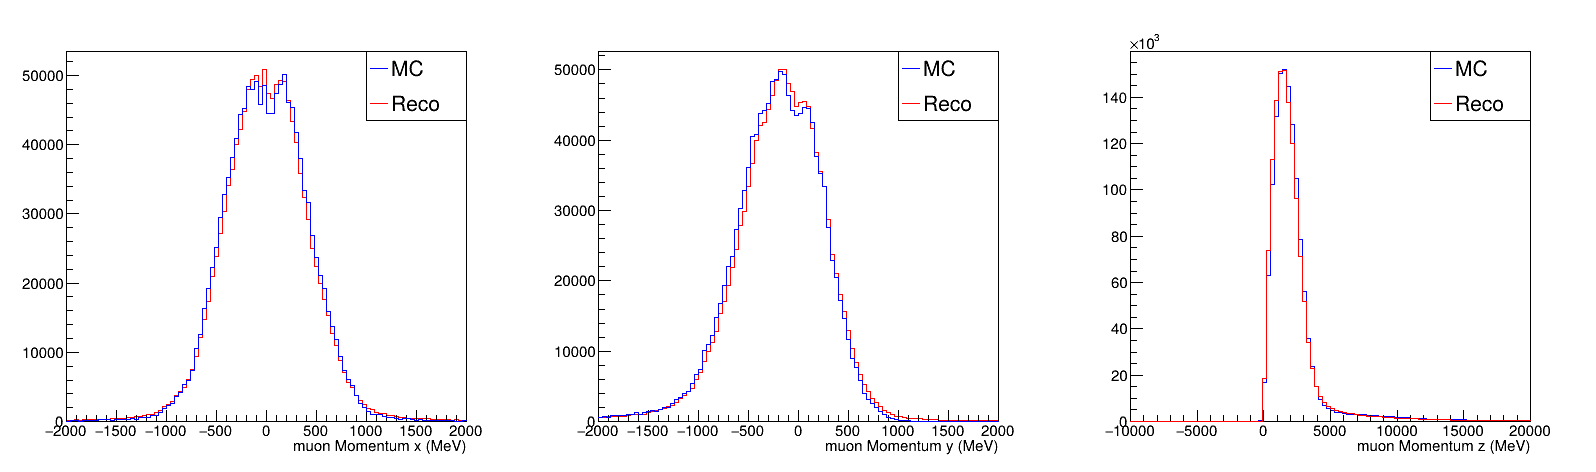

In [35]:
gH7 =  gDF2.Histo1D(("h1", "  ", 100, -2000, 2000),"mu_px")        #histo mu momentum MC
gH8 =  gDF2.Histo1D(("h2", " ", 100, -2000, 2000),"mu_py")      #histo mu momentum 
gH9 =  gDF2.Histo1D(("h3", " ", 100, -10000, 20000),"mu_pz")    #histo mu momentum 

gH10 = gDF2.Histo1D(("h4", " ", 100, -2000, 2000), "mu_pxreco")
gH11 = gDF2.Histo1D(("h5", " ", 100, - 2000, 2000), "mu_pyreco")
gH12 = gDF2.Histo1D(("h6", " ", 100,  -10000, 20000), "mu_pzreco")

c4 = TCanvas("c1", "Canvas", 1600, 500)
c4.Divide(3, 1)

c4.cd(1)
# gH7->SetTitle("");  // Set histogram title
gH7.GetXaxis().SetTitle("muon Momentum x (MeV)")
gH7.SetLineColor(ROOT.kBlue)
gH10.SetLineColor(ROOT.kRed)
gH10.GetXaxis().SetTitle("muon Momentum x (MeV)")
gH10.Draw()
gH7.Draw("SAME")

legend1 = TLegend(0.7, 0.75, 0.9, 0.9)   # (x1,y1,x2,y2) in coordinate NDC
legend1.AddEntry(gH7.GetPtr(), "MC", "l")
legend1.AddEntry(gH10.GetPtr(), "Reco", "l")
legend1.Draw()

c4.cd(2)
# gH8->SetTitle("");  # Set histogram title
gH8.GetXaxis().SetTitle("muon Momentum y (MeV)")
gH8.SetLineColor(ROOT.kBlue)
gH11.SetLineColor(ROOT.kRed)
gH11.GetXaxis().SetTitle("muon Momentum y (MeV)")
gH11.Draw()
gH8.Draw("SAME")

legend2 = TLegend(0.7, 0.75, 0.9, 0.9)
legend2.AddEntry(gH8.GetPtr(), "MC", "l")
legend2.AddEntry(gH11.GetPtr(), "Reco", "l")
legend2.Draw()

c4.cd(3)
# gH9->SetTitle("");  // Set histogram title
gH9.GetXaxis().SetTitle("muon Momentum z (MeV)")
gH9.SetLineColor(ROOT.kBlue)
gH12.SetLineColor(ROOT.kRed)
gH9.Draw()
gH12.Draw("SAME")

legend3 = TLegend(0.7, 0.75, 0.9, 0.9)
legend3.AddEntry(gH9.GetPtr(), "MC", "l")
legend3.AddEntry(gH12.GetPtr(), "Reco", "l")
legend3.Draw()

c4.Draw()
# c4.SaveAs("zoom_17_09_Mu_momentumXYZ.png");


6771

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


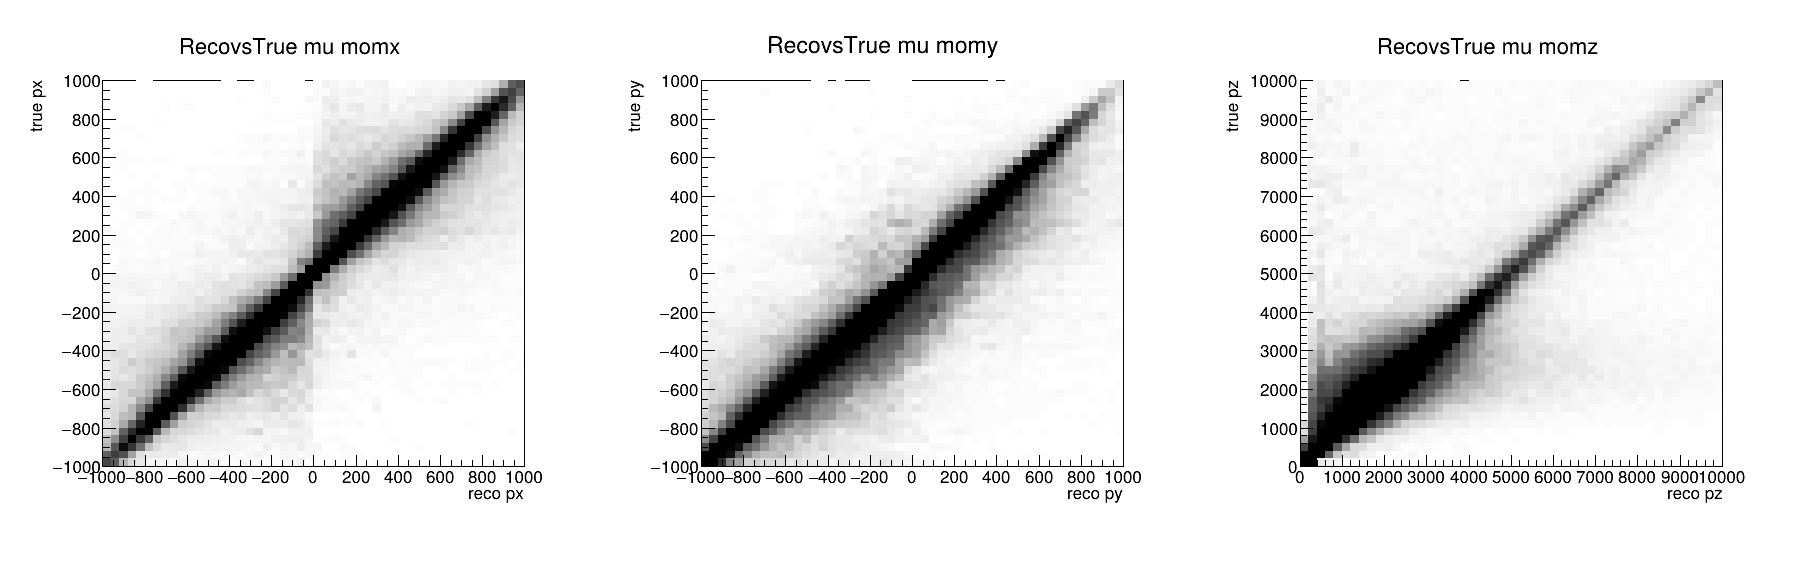

In [36]:
#recoVStrue muon momentum components

# ROOT.gStyle.SetPalette(ROOT.kBird)
# ROOT.gStyle.SetUnderflowColor(ROOT.kBlue)
# ROOT.gStyle.SetFrameFillColor(ROOT.kAzure -6)
# ROOT.gStyle.SetFrameFillColor(ROOT.kBlue -3)
# ROOT.gPad.SetFrameFillColor(ROOT.TColor.GetColorPalette(0))


h2_px = gDF2.Histo2D(("h2_px", "RecovsTrue mu momx ",50, -1000, 1000, 50, -1000, 1000),"mu_pxreco", "mu_px")
h2_py = gDF2.Histo2D(("h2_py", "RecovsTrue mu momy ",50, -1000, 1000, 50, -1000, 1000),"mu_pyreco", "mu_py")
h2_pz = gDF2.Histo2D(("h2_pz", "RecovsTrue mu momz ",50, 0, 10000, 50, 0, 10000),"mu_pzreco", "mu_pz")

c = ROOT.TCanvas("c", "Reco vs True", 1800, 600)
# c.Divide(3, 1)
c.Divide(3, 1, 0.01, 0.05) 

# Disegna
c.cd(1)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetBottomMargin(0.15)
h2_px.SetMinimum(0)
h2_px.SetMaximum(1000)
h2_px.GetXaxis().SetTitle("reco px")
h2_px.GetYaxis().SetTitle("true px")
h2_px.Draw()

c.cd(2)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetBottomMargin(0.15)
h2_py.SetMinimum(0)
h2_py.SetMaximum(1000)
h2_py.GetXaxis().SetTitle("reco py")
h2_py.GetYaxis().SetTitle("true py")
h2_py.Draw()

c.cd(3)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetBottomMargin(0.15)
h2_pz.SetMinimum(0)
h2_pz.SetMaximum(1000)
h2_pz.GetXaxis().SetTitle("reco pz")
h2_pz.GetYaxis().SetTitle("true pz")
h2_pz.Draw()

c.Draw()
# c.SaveAs("RecoVsTrue.pdf")


f_out.cd()
h2_px.GetValue().Write()
h2_py.GetValue().Write()
h2_pz.GetValue().Write()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


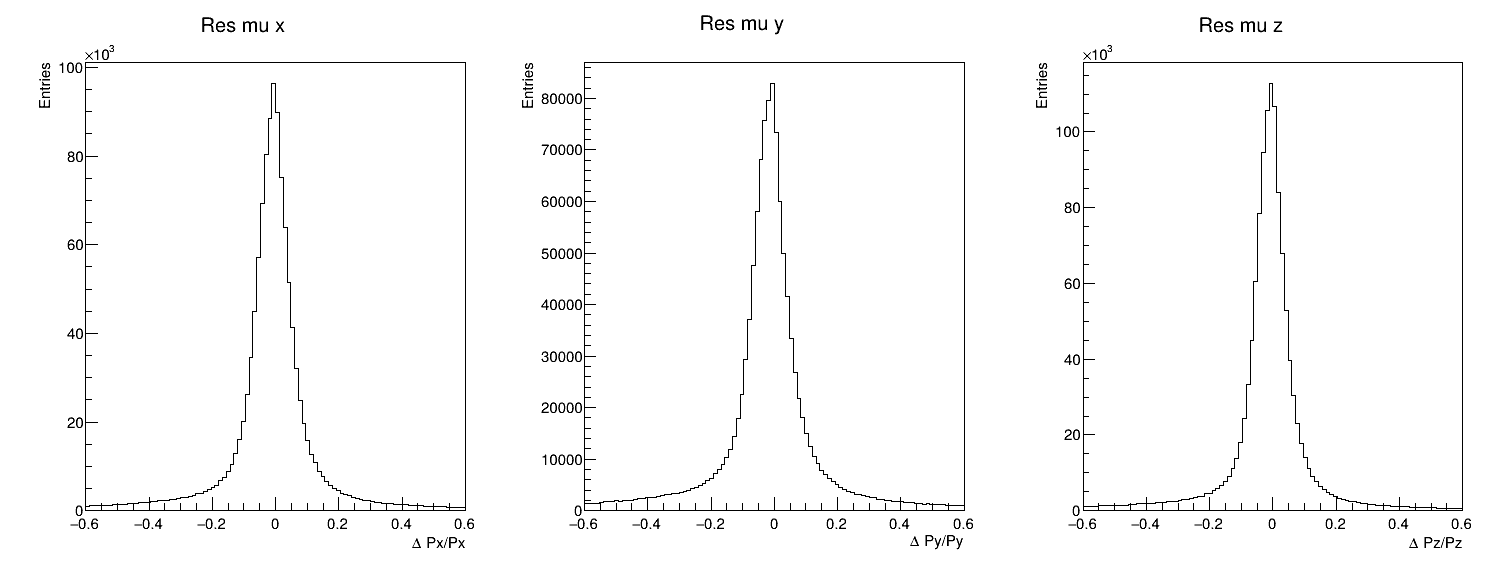

In [37]:
#momentum residuals

#df used only for these plots
df_muon = (
    gDF2.Define("res", "(mu_Preco - mu_P)/mu_P")
      .Define("res_x", "(mu_pxreco[0] - mu_px[0])/mu_px[0]")
      .Define("res_y", "(mu_pyreco[0] - mu_py[0])/mu_py[0]")
      .Define("res_z", "(mu_pzreco[0] - mu_pz[0])/mu_pz[0]")
      .Define("res_E_mu", "(mu_Ereco[0] - mu_E[0])/mu_pz[0]" )
)

c = TCanvas("c", " ", 1500, 600)
c.Divide(3,1)
ROOT.gStyle.SetOptStat(0)

max = 0.6
min = -0.6

h_resmu_x = df_muon.Histo1D(("h1", " Res mu x ", 100, min, max),"res_x")
h_resmu_y = df_muon.Histo1D(("h2", " Res mu y ", 100, min, max),"res_y")
h_resmu_z = df_muon.Histo1D(("h3", " Res mu z ", 100, min, max),"res_z")

c.cd(1)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_resmu_x.GetXaxis().SetTitle("#Delta Px/Px")
h_resmu_x.GetYaxis().SetTitle("Entries")
h_resmu_x.Draw()

c.cd(2)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_resmu_y.GetXaxis().SetTitle("#Delta Py/Py")
h_resmu_y.GetYaxis().SetTitle("Entries")

h_resmu_y.Draw()

c.cd(3)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_resmu_z.GetXaxis().SetTitle("#Delta Pz/Pz")
h_resmu_z.GetYaxis().SetTitle("Entries")

h_resmu_z.Draw()

c.Draw()

# f_out.cd()
# h_resmu_x.GetValue().Write()
# h_resmu_y.GetValue().Write()
# h_resmu_z.GetValue().Write()

714

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


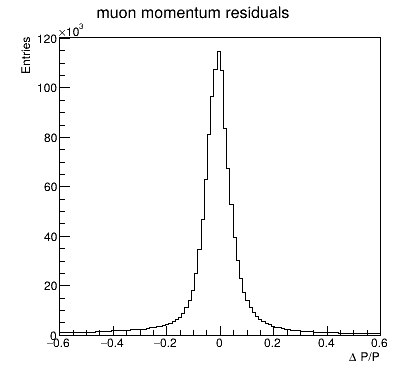

In [ ]:
c = TCanvas("c", " ", 400, 400)
ROOT.gStyle.SetOptStat(0)

max = 0.6
min = -0.6

h_res_mu_P = df_muon.Histo1D(("h1", " muon momentum residuals ", 100, min, max),"res")

ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_mu_P.GetXaxis().SetTitle("#Delta P/P")
h_res_mu_P.GetYaxis().SetTitle("Entries")
h_res_mu_P.Draw()


c.Draw()

# f_out.cd()
# h_res_mu_P.GetValue().Write()

712

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


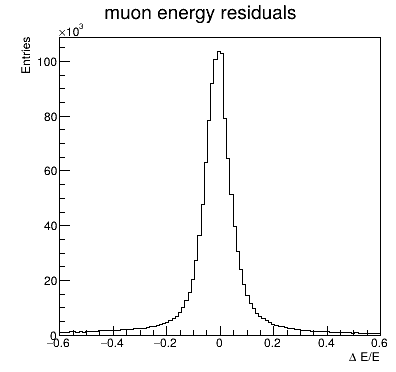

In [ ]:
c = TCanvas("c", " ", 400, 400)
c.Divide(3,1)
ROOT.gStyle.SetOptStat(0)

max = 0.6
min = -0.6

h_res_mu_E = df_muon.Histo1D(("h_E", " muon energy residuals", 100, min, max),"res_E_mu")

ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_mu_E.GetXaxis().SetTitle("#Delta E/E")
h_res_mu_E.GetYaxis().SetTitle("Entries")
h_res_mu_E.Draw()


c.Draw()

# f_out.cd()
# h_res_mu_E.GetValue().Write()

In [40]:
del gDF2
del df_muon

neutrino quantities residuals

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


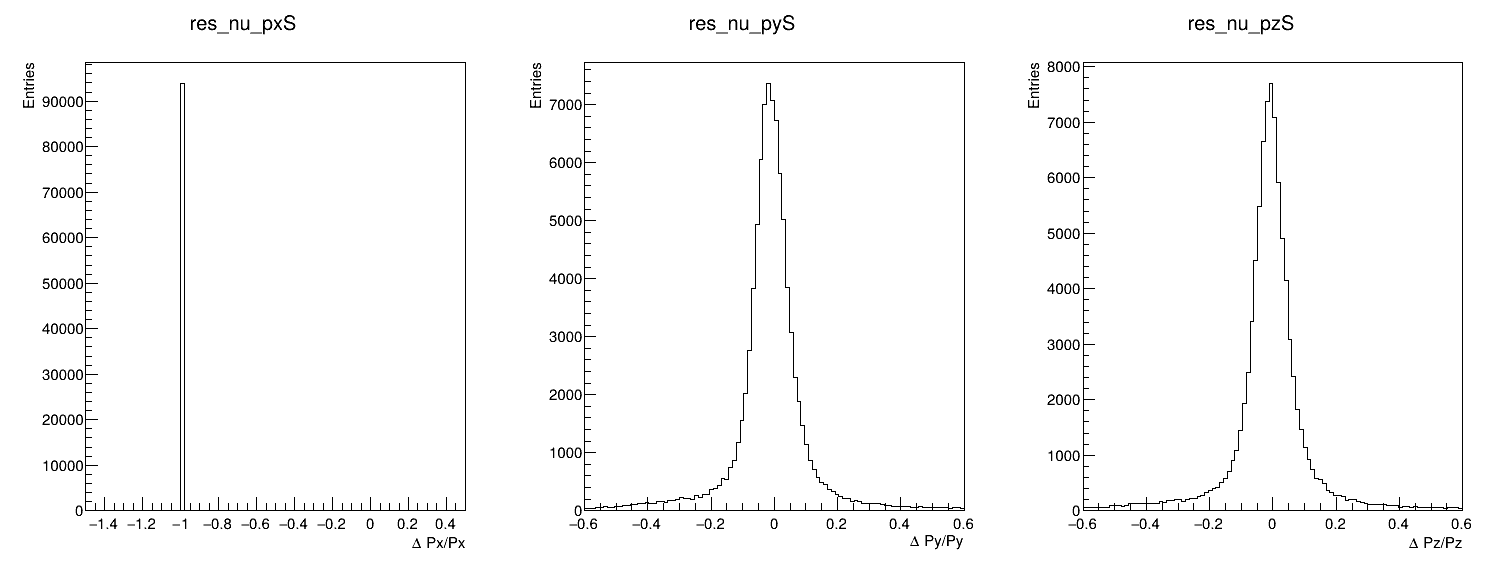

In [96]:
DF = df_flag.Filter("volume_flag == 1 && reco_flag == 1 ")

df_neutrino = (DF.Define("res_E_nu", "(nu_Ereco - Enu)/Enu")
                       .Define("res_px_nu","(nu_Preco[0] - pxnu)/pxnu")
                       .Define("res_py_nu", "((nu_Preco[1] - pynu)/pynu) + 0.08")
                       .Define("res_pz_nu","(nu_Preco[2] - pznu)/pznu")
               )

c = TCanvas("c", " ", 1500, 600)
c.Divide(3,1)
ROOT.gStyle.SetOptStat(0)

max = 0.6
min = -0.6

h_res_nu_pxS = df_neutrino.Filter('true_flag == 1').Histo1D(("h_res_nu_pxS", " res_nu_pxS ", 100, -1.5, 0.5 ),"res_px_nu")
h_res_nu_pyS = df_neutrino.Filter('true_flag == 1').Histo1D(("h_res_nu_pyS", " res_nu_pyS ", 100, min, max),"res_py_nu")
h_res_nu_pzS = df_neutrino.Filter('true_flag == 1').Histo1D(("h_res_nu_pzS", " res_nu_pzS ", 100, min, max),"res_pz_nu")

c.cd(1)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_nu_pxS.GetXaxis().SetTitle("#Delta Px/Px")
h_res_nu_pxS.GetYaxis().SetTitle("Entries")
h_res_nu_pxS.Draw()

c.cd(2)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_nu_pyS.GetXaxis().SetTitle("#Delta Py/Py")
h_res_nu_pyS.GetYaxis().SetTitle("Entries")
h_res_nu_pyS.Draw()

c.cd(3)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_nu_pzS.GetXaxis().SetTitle("#Delta Pz/Pz")
h_res_nu_pzS.GetYaxis().SetTitle("Entries")

h_res_nu_pzS.Draw()

c.Draw()


# f_out.cd()
# h_res_nu_pxS.GetValue().Write()
# h_res_nu_pyS.GetValue().Write()
# h_res_nu_pzS.GetValue().Write()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


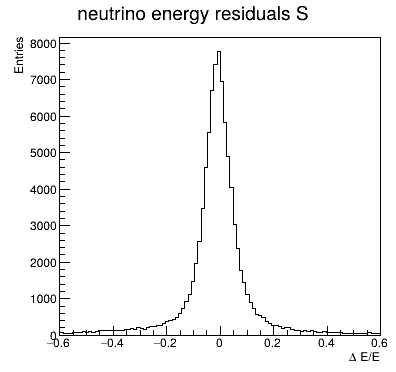

In [97]:
c = TCanvas("c", " ", 400, 400)
c.Divide(3,1)
ROOT.gStyle.SetOptStat(0)

max = 0.6
min = -0.6

h_E_nuS = df_neutrino.Filter('true_flag == 1').Histo1D(("h_E", " neutrino energy residuals S ", 100, min, max),"res_E_nu")

ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_E_nuS.GetXaxis().SetTitle("#Delta E/E")
h_E_nuS.GetYaxis().SetTitle("Entries")
h_E_nuS.Draw()


c.Draw()


# f_out.cd()
# h_E_nuS.GetValue().Write()

696

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


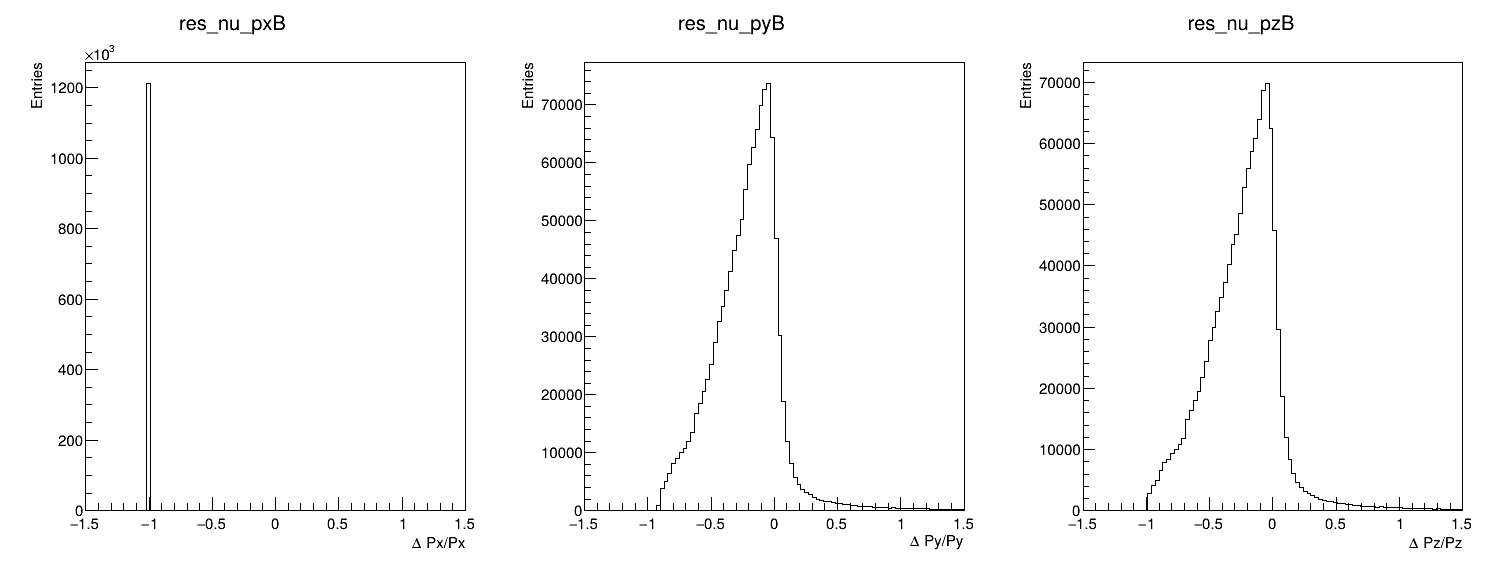

In [ ]:
c = TCanvas("c", " ", 1500, 600)
c.Divide(3,1)
ROOT.gStyle.SetOptStat(0)

max = 1.5
min = -1.5

h_res_nu_pxB = df_neutrino.Filter('true_flag == 0').Histo1D(("h_res_nu_pxB", "res_nu_pxB  ", 100, min, max),"res_px_nu")
h_res_nu_pyB = df_neutrino.Filter('true_flag == 0').Histo1D(("h_res_nu_pyB", "res_nu_pyB  ", 100, min, max),"res_py_nu")
h_res_nu_pzB = df_neutrino.Filter('true_flag == 0').Histo1D(("h_res_nu_pzB", " res_nu_pzB ", 100, min, max),"res_pz_nu")

c.cd(1)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_nu_pxB.GetXaxis().SetTitle("#Delta Px/Px")
h_res_nu_pxB.GetYaxis().SetTitle("Entries")
h_res_nu_pxB.Draw()

c.cd(2)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_nu_pyB.GetXaxis().SetTitle("#Delta Py/Py")
h_res_nu_pyB.GetYaxis().SetTitle("Entries")

h_res_nu_pyB.Draw()

c.cd(3)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_nu_pzB.GetXaxis().SetTitle("#Delta Pz/Pz")
h_res_nu_pzB.GetYaxis().SetTitle("Entries")

h_res_nu_pzB.Draw()

c.Draw()


# f_out.cd()
# h_res_nu_pxB.GetValue().Write()
# h_res_nu_pyB.GetValue().Write()
# h_res_nu_pzB.GetValue().Write()

NameError: name 'df_neutrino' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


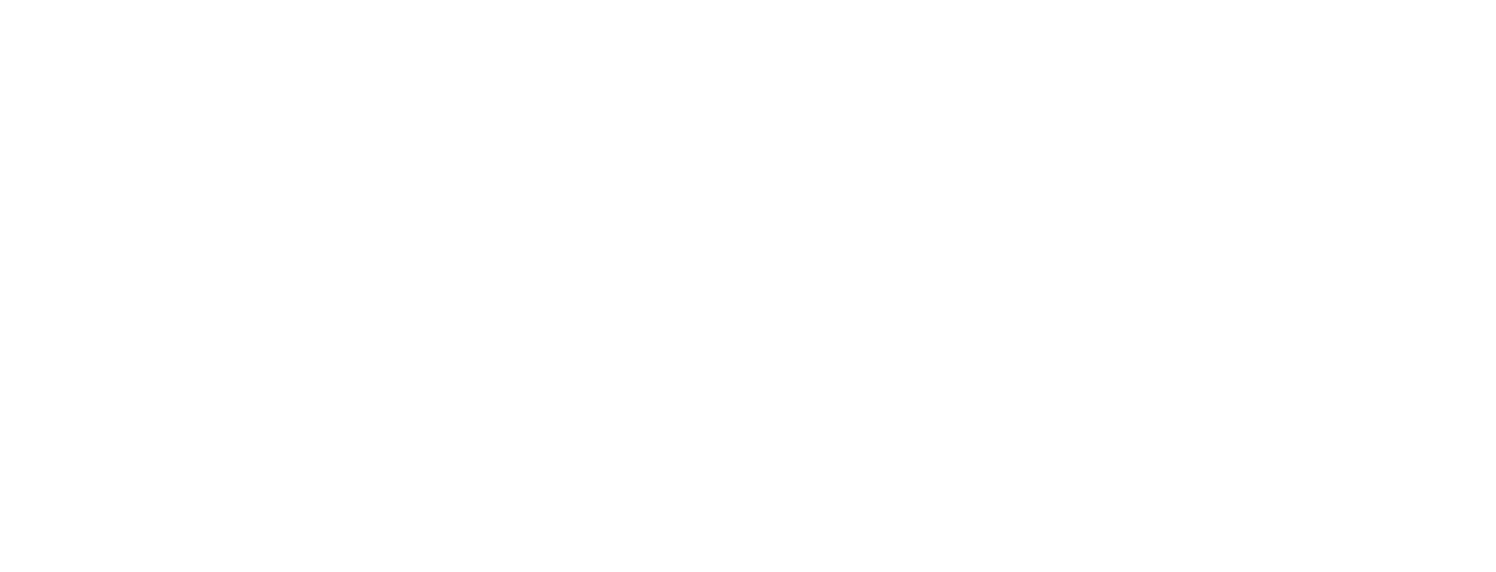

In [94]:
c = TCanvas("c", " ", 1500, 600)
c.Divide(3,1)
ROOT.gStyle.SetOptStat(0)

max = 1.0
min = -1.0

h_res_E_nuB = df_neutrino.Filter('true_flag == 0').Histo1D(("h_res_E_nuB", " res_E_nuB ", 100, min, max),"res_E_nu")

ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_E_nuB.GetXaxis().SetTitle("#Delta E/E")
h_res_E_nuB.GetYaxis().SetTitle("Entries")
h_res_E_nuB.Draw()


c.Draw()


# f_out.cd()
# h_res_E_nuB.GetValue().Write()

In [45]:
del df_neutrino
del DF

Neutron quantities

In [46]:
DF = df_flag.Filter("volume_flag == 1 && reco_flag == 1")

df_neutron = (DF.Define("res_pn_x", "(n_px_pred - n_px[0])/ n_px[0]") 
                     .Define("res_pn_y", "(n_py_pred - n_py[0])/ n_py[0]")
                     .Define("res_pn_z", "(n_pz_pred - n_pz[0])/ n_pz[0]")
                     .Define("res_P_n", "(n_Ppred - n_P)/n_P")
                     .Define("res_E_n", "(n_E_pred - n_E[0])/n_E[0]")
)

#df_H = df_neutron.Filter('target == "tgt:1000010010" && munu == true && st_proc_type == "proc:Weak[CC],QES"')
#df_nonH = df_neutron.Filter('target != "tgt:1000010010"')


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


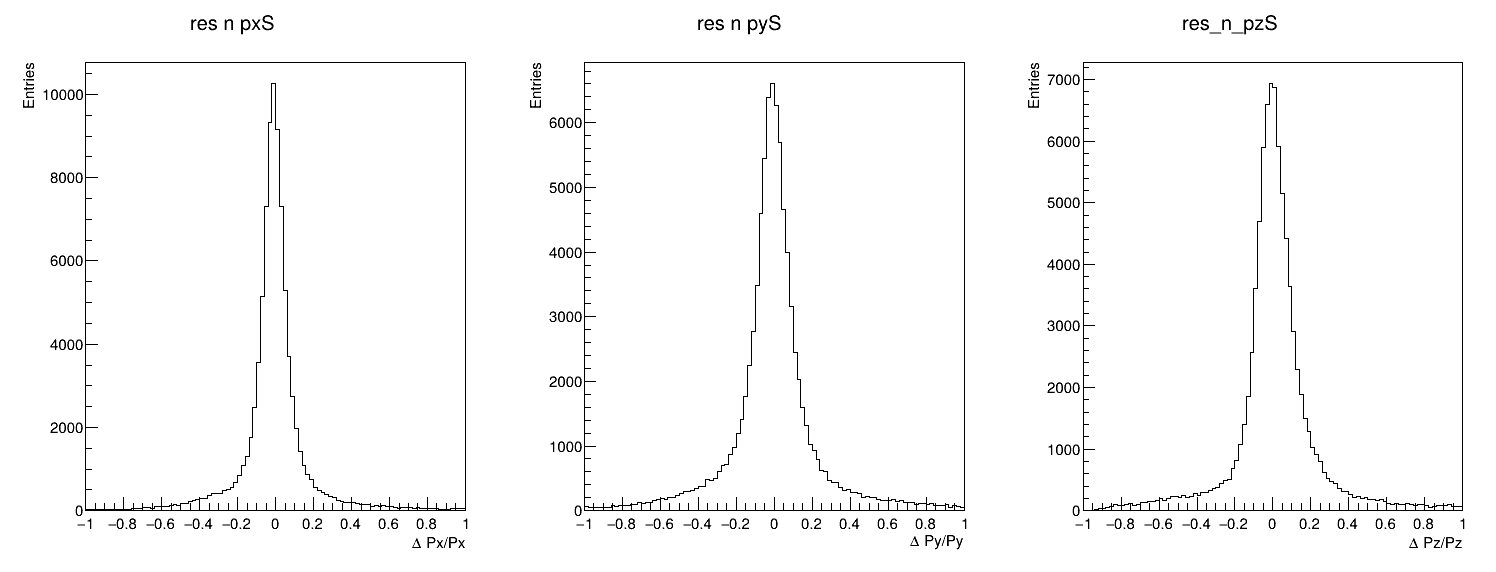

In [47]:
c = TCanvas("c", " ", 1500, 600)
c.Divide(3,1)
ROOT.gStyle.SetOptStat(0)

max = 1.0
min = -1.0

h_res_n_pxS = df_neutron.Filter("true_flag == 1").Histo1D(("h_res_n_pxS", "res n pxS  ", 100, min, max),"res_pn_x")
h_res_n_pyS = df_neutron.Filter("true_flag == 1").Histo1D(("h_res_n_pyS", "res n pyS ", 100, min, max),"res_pn_y")
h_res_n_pzS = df_neutron.Filter("true_flag == 1").Histo1D(("h_res_n_pzS", "res_n_pzS  ", 100, min, max),"res_pn_z")

c.cd(1)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_n_pxS.GetXaxis().SetTitle("#Delta Px/Px")
h_res_n_pxS.GetYaxis().SetTitle("Entries")
h_res_n_pxS.Draw()

c.cd(2)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_n_pyS.GetXaxis().SetTitle("#Delta Py/Py")
h_res_n_pyS.GetYaxis().SetTitle("Entries")

h_res_n_pyS.Draw()

c.cd(3)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_n_pzS.GetXaxis().SetTitle("#Delta Pz/Pz")
h_res_n_pzS.GetYaxis().SetTitle("Entries")

h_res_n_pzS.Draw()

c.Draw()


# f_out.cd()
# h_res_n_pxS.GetValue().Write()
# h_res_n_pyS.GetValue().Write() 
# h_res_n_pzS.GetValue().Write() 

668

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


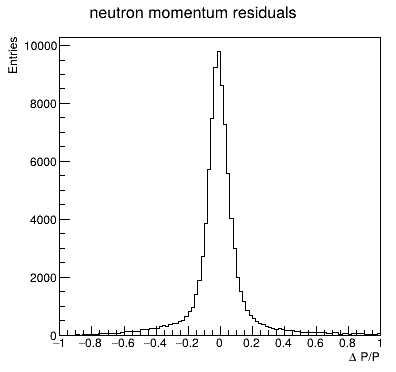

In [48]:
#true signal

c = TCanvas("c", " ", 400, 400)
c.Divide(3,1)
ROOT.gStyle.SetOptStat(0)

max = 1
min = -1

h_res_nP_S = df_neutron.Filter("true_flag == 1").Histo1D(("h_res_nP_S", " neutron momentum residuals ", 100, min, max),"res_P_n")

ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_nP_S.GetXaxis().SetTitle("#Delta P/P")
h_res_nP_S.GetYaxis().SetTitle("Entries")
h_res_nP_S.Draw()


c.Draw()

f_out.cd()
h_res_nP_S.GetValue().Write()

699

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


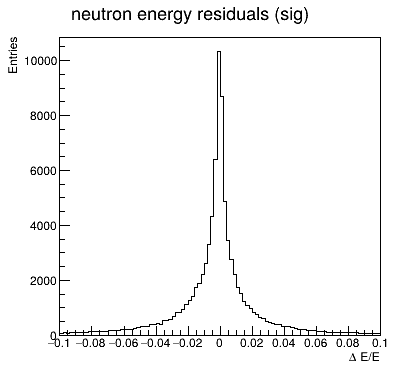

In [49]:

c = TCanvas("c", " ", 400, 400)
c.Divide(3,1)
ROOT.gStyle.SetOptStat(0)

max = 0.1
min = -0.1

h_res_nE_S = df_neutron.Filter("true_flag == 1").Histo1D(("h_res_nE_S", "neutron energy residuals (sig) ", 100, min, max),"res_E_n")

ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_nE_S.GetXaxis().SetTitle("#Delta E/E")
h_res_nE_S.GetYaxis().SetTitle("Entries")
h_res_nE_S.Draw()


c.Draw()


f_out.cd()
h_res_nE_S.GetValue().Write()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


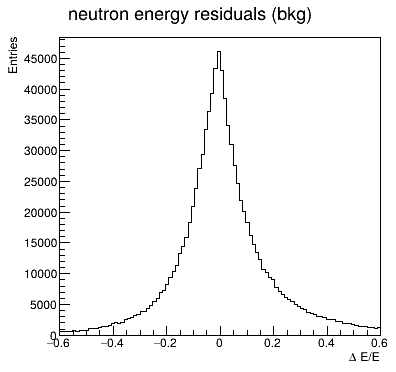

In [50]:
c = TCanvas("c", " ", 400, 400)
c.Divide(3,1)
ROOT.gStyle.SetOptStat(0)

max = 0.6
min = -0.6

h_res_nE_B = df_neutron.Filter("true_flag == 0").Histo1D(("h_res_nE_B", "neutron energy residuals (bkg) ", 100, min, max),"res_E_n")

ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_nE_B.GetXaxis().SetTitle("#Delta E/E")
h_res_nE_B.GetYaxis().SetTitle("Entries")
h_res_nE_B.Draw()


c.Draw()


# f_out.cd()
# h_res_nE_B.GetValue().Write()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


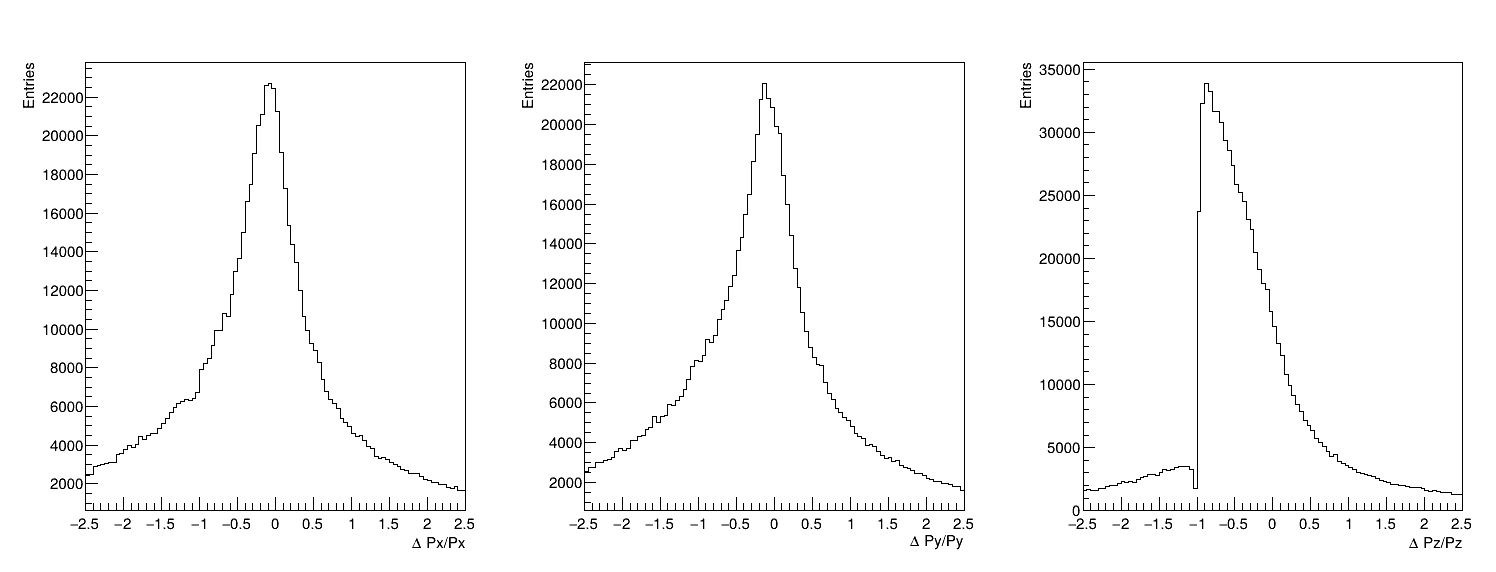

In [51]:
c = TCanvas("c", " ", 1500, 600)
c.Divide(3,1)
ROOT.gStyle.SetOptStat(0)

max = 2.5
min = -2.5

h_x1 = df_neutron.Filter("true_flag == 0").Histo1D(("h1", "  ", 100, min, max),"res_pn_x")
h_y1 = df_neutron.Filter("true_flag == 0").Histo1D(("h2", "  ", 100, min, max),"res_pn_y")
h_z1 = df_neutron.Filter("true_flag == 0").Histo1D(("h3", "  ", 100, min, max),"res_pn_z")

c.cd(1)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_x1.GetXaxis().SetTitle("#Delta Px/Px")
h_x1.GetYaxis().SetTitle("Entries")
h_x1.Draw()

c.cd(2)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_y1.GetXaxis().SetTitle("#Delta Py/Py")
h_y1.GetYaxis().SetTitle("Entries")

h_y1.Draw()

c.cd(3)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_z1.GetXaxis().SetTitle("#Delta Pz/Pz")
h_z1.GetYaxis().SetTitle("Entries")

h_z1.Draw()


c.Draw()

740

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


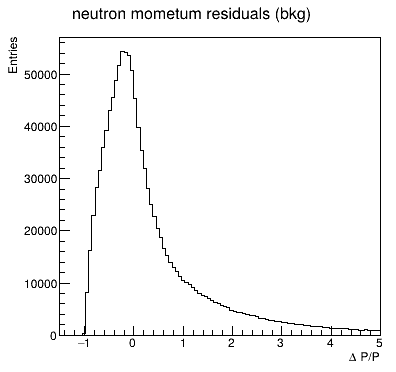

In [52]:
c = TCanvas("c", " ", 400, 400)
c.Divide(3,1)
ROOT.gStyle.SetOptStat(0)

max = 5
min = -1.5

h_res_nP_B = df_neutron.Filter("true_flag == 0").Histo1D(("h_res_nP_B", "neutron mometum residuals (bkg) ", 100, min, max),"res_P_n")

ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_nP_B.GetXaxis().SetTitle("#Delta P/P")
h_res_nP_B.GetYaxis().SetTitle("Entries")
h_res_nP_B.Draw()


c.Draw()


f_out.cd()
h_res_nP_B.GetValue().Write()

2418

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


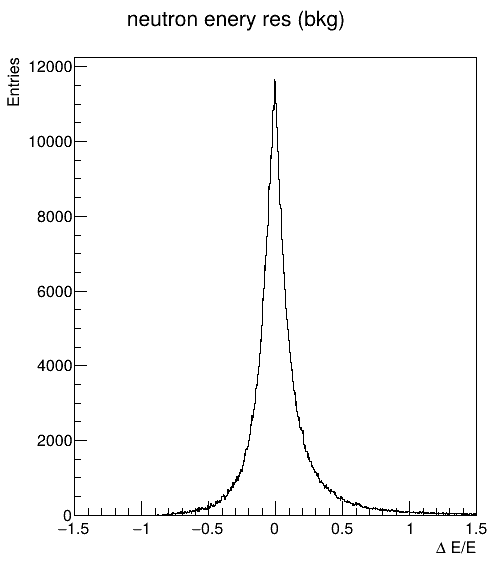

In [53]:
c = TCanvas("c", " ", 500, 600)
c.Divide(3,1)
ROOT.gStyle.SetOptStat(0)

max = 1.5
min = -1.5

h_res_nE_B = df_neutron.Filter("true_flag == 0").Histo1D(("h_res_nE_B", " neutron enery res (bkg) ", 1000, min, max),"res_E_n")

ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)
h_res_nE_B.GetXaxis().SetTitle("#Delta E/E")
h_res_nE_B.GetYaxis().SetTitle("Entries")
h_res_nE_B.Draw()


c.Draw()

f_out.cd()
h_res_nE_B.GetValue().Write()

In [54]:
del df_neutron
del DF

Info in <TCanvas::Print>: pdf file reco_cut.pdf has been created
Info in <TCanvas::Print>: png file reco_cut.png has been created


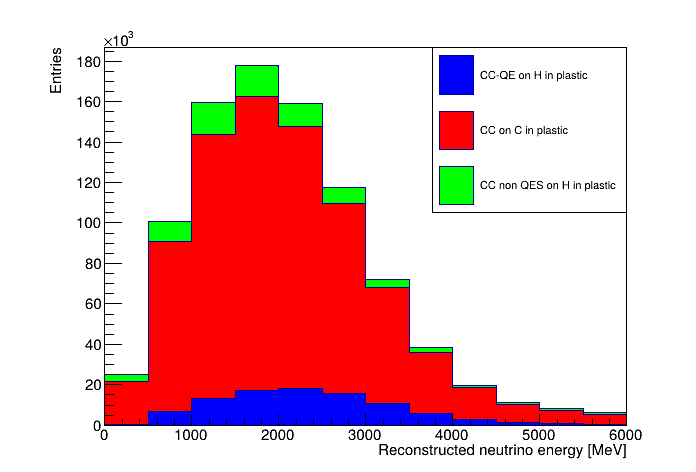

In [9]:
#selected events after good reco cut on POLYPROPYLENE


nbin = 12

df_plasticR = df_flag.Filter('reco_flag == 1 && Where_int == "C3H6"')

hist_R1 = df_plasticR.Filter('target == "tgt:1000010010" && st_proc_type == "proc:Weak[CC],QES"').Histo1D(("hist_R1", "", nbin, 0, 6000),"nu_Ereco")
hist_R2 = df_plasticR.Filter('target == "tgt:1000060120"').Histo1D(("hist_R2", "", nbin, 0, 6000),"nu_Ereco")
hist_R3 = df_plasticR.Filter('target == "tgt:1000010010" && st_proc_type != "proc:Weak[CC],QES"').Histo1D(("histR_2", "", nbin, 0, 6000),"nu_Ereco")


# hist_4 = df_TIME.Filter("Evt_cat == 4").Histo1D(("hist_4", "", nbin, 0, 10000),"Enu")
# hist_0 = df_TIME.Filter('Evt_cat == 0 && target != "tgt:1000010010" && target != "tgt:1000060120"').Histo1D(("hist_0", "", nbin, 0, 10000),"Enu")

# hist_6 = df_TIME.Filter('Evt_cat == 0 && target == "tgt:1000010010"')
# hist_7 = df_TIME.Filter('Evt_cat == 0 && target == "tgt:1000060120"')

hist_R1.SetFillColor(ROOT.kBlue)
hist_R2.SetFillColor(ROOT.kRed)
hist_R3.SetFillColor(ROOT.kGreen)
# hist_0.SetFillColor(ROOT.kGreen)
# hist_6.SetFillColor(ROOT.kBlue +1 )
# hist_7.SetFillColor(ROOT.kRed + 2 )


stackR = ROOT.THStack("stack", " ")
stackR.Add(hist_R1.GetPtr())
stackR.Add(hist_R2.GetPtr())
stackR.Add(hist_R3.GetPtr())

# stack.Add(hist_0.GetPtr())
# stack.Add(hist_6.GetPtr())
# stack.Add(hist_7.GetPtr())

cR = ROOT.TCanvas()
cR.SetLeftMargin(0.15)

stackR.Draw("HIST")
stackR.GetXaxis().SetTitle(" Reconstructed neutrino energy [MeV]")
stackR.GetYaxis().SetTitle("Entries")

legend = ROOT.TLegend(0.62, 0.55, 0.90, 0.90)
#legend = ROOT.TLegend(0.65, 0.6, 0.93, 0.93)

legend.AddEntry(hist_R1.GetPtr(), "CC-QE on H in plastic", "f")
legend.AddEntry(hist_R2.GetPtr(), "CC on C in plastic", "f")
legend.AddEntry(hist_R3.GetPtr(), "CC non QES on H in plastic", "f")

# legend.AddEntry(hist_6.GetPtr(), "evt")
# legend.AddEntry(hist_0.GetPtr(), "background", "f")

legend.Draw()

cR.Draw()
cR.SaveAs("reco_cut.pdf")
cR.SaveAs("reco_cut.png")
# f_out.cd()

# hist_R1.GetValue().Write()
# hist_R2.GetValue().Write()
# hist_R3.GetValue().Write()
# stackR.GetValue().Write()



EVENTS WITH ONE TRACK

In [7]:
df_one_track = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1")

738

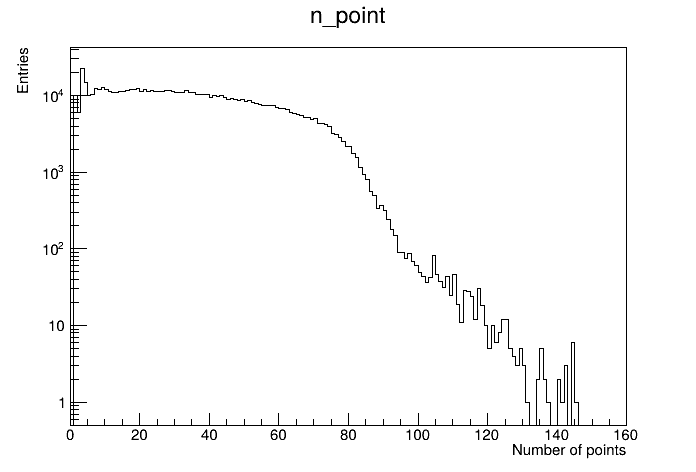

In [57]:
#Histo1D of the number of points 
ROOT.gStyle.SetOptStat(0)
c = TCanvas()
h_point = df_one_track.Histo1D(("h_point", "n_point", 160, 0 , 160), "N_points")
h_point.GetXaxis().SetTitle("Number of points")
h_point.GetYaxis().SetTitle("Entries")
c.SetLogy()
h_point.Draw()
c.Draw()


f_out.cd()
h_point.GetValue().Write()


Fit mean: -0.009289791351677512, sigma: 0.04732874868058213
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      4673.76
NDf                       =           47
Edm                       =  7.54372e-08
NCalls                    =           73
Constant                  =      19926.2   +/-   35.9984     
Mean                      =  -0.00928979   +/-   7.00431e-05 
Sigma                     =    0.0473287   +/-   7.20503e-05  	 (limited)


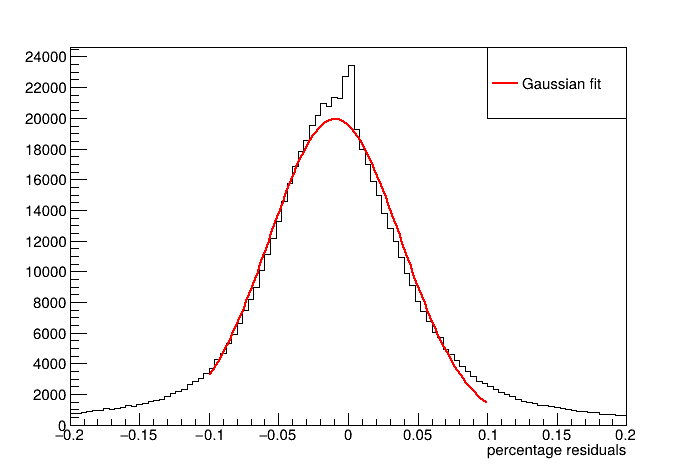

In [58]:
#Gaussian fit

df_res = df_one_track.Define("res", "(mu_Preco - mu_P)/mu_P")

c1 = ROOT.TCanvas()

gaus = ROOT.TF1("gaus", "gaus",- 0.1, 0.1)
h = df_res.Histo1D(("h"," ", 100, -0.2, 0.2), "res")
h.Fit(gaus, "R")

h.GetXaxis().SetTitle("percentage residuals")
h.Draw()
gaus.Draw("SAME")


mean = gaus.GetParameter(1)
sigma = gaus.GetParameter(2)

print(f"Fit mean: {mean}, sigma: {sigma}")

legend = ROOT.TLegend(0.7, 0.75, 0.9, 0.9)
legend.AddEntry(gaus, "Gaussian fit", "l")
legend.Draw()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


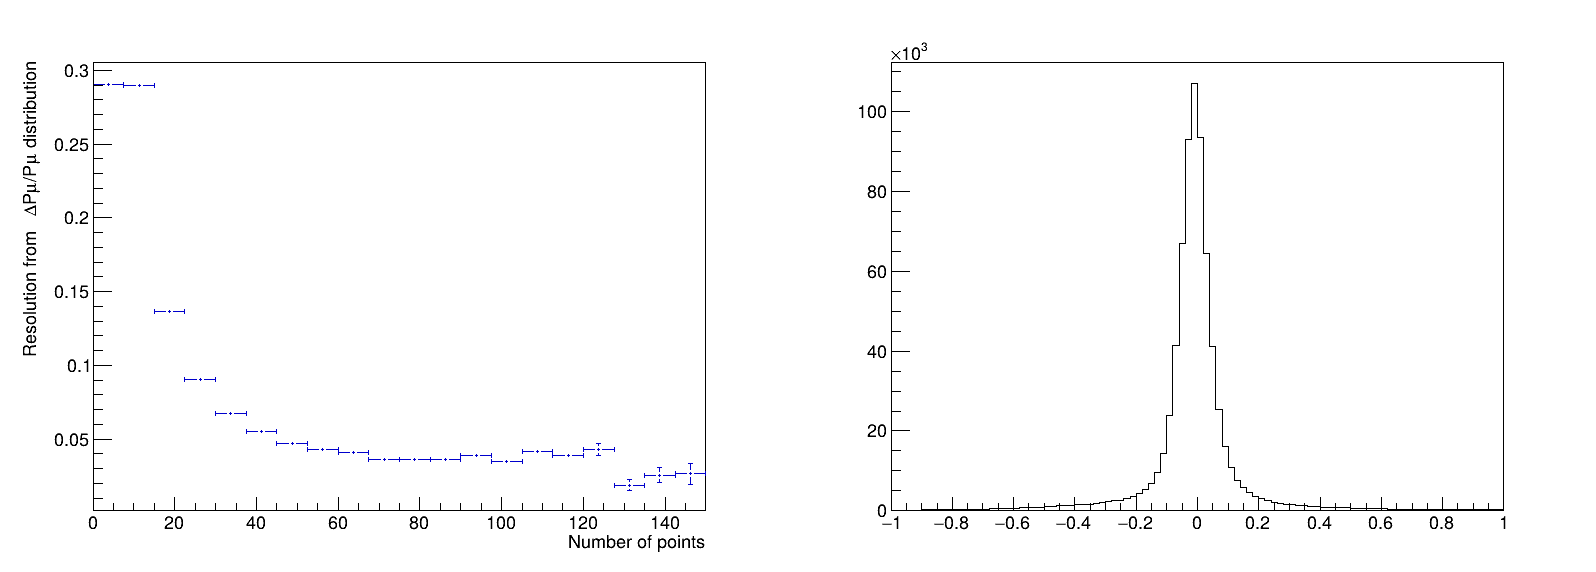

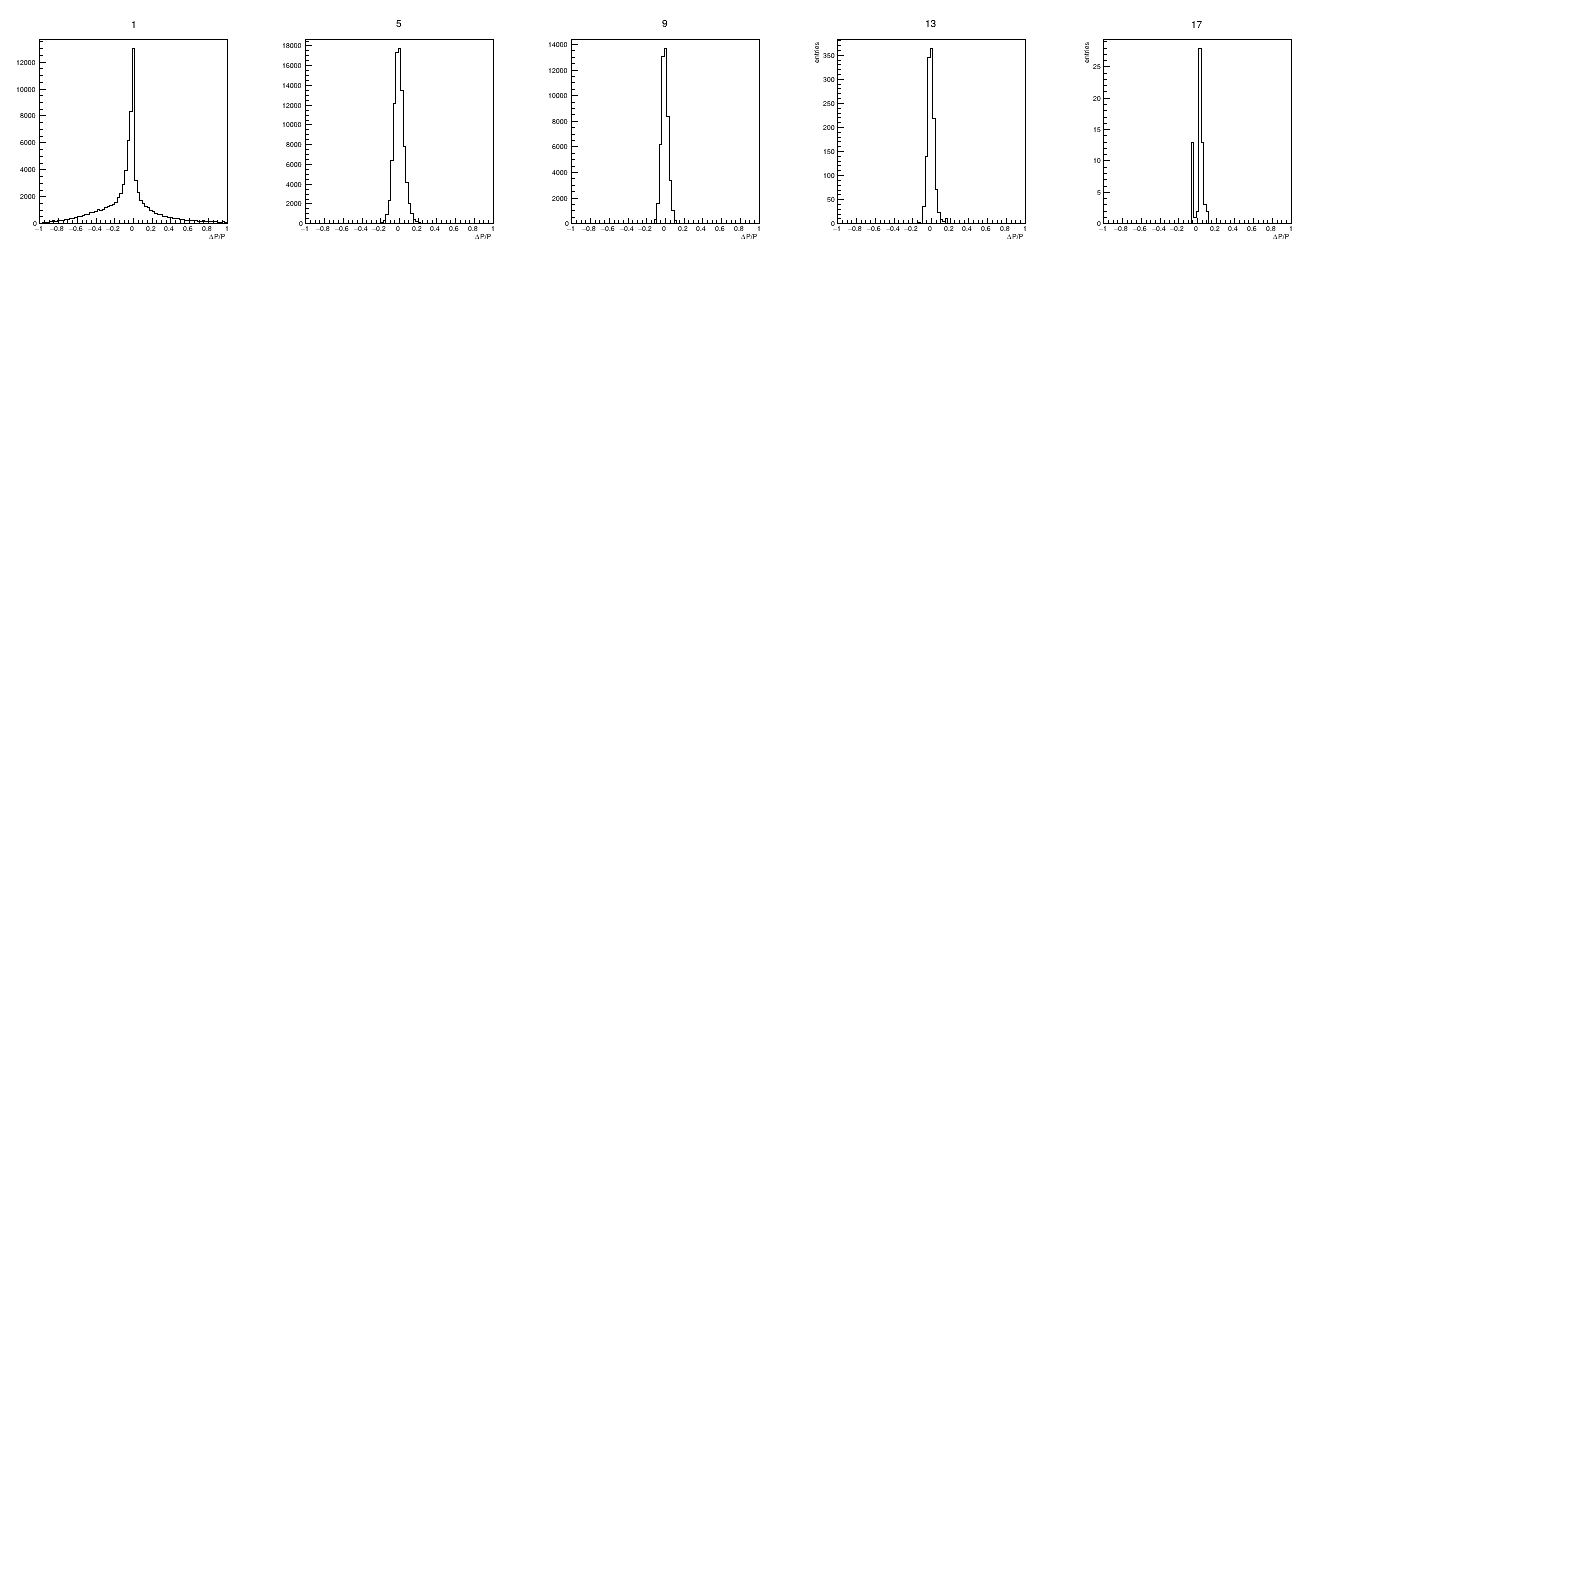

In [59]:
# Resolutions (RMS) for events with N_points = X
ROOT.gStyle.SetOptStat(0)
c9 = ROOT.TCanvas("c2", "", 1600, 600)
c11 = TCanvas("c11", "", 1600, 1600)
c11.Divide(6,6)

c9.Divide(2,1)

# 2D histogram: mu_points vs residuals
# h2 = df_extended2.Histo2D(("h2", " ", 142, 0 , 142, 142, -0.1, 0.1), "mu_points", "res") 
h2 = df_res.Histo2D(("h2", " ", 20, 0 , 150, 75, -1., 1.), "N_points", "res")
# h2 = df_extended2.Histo2D(("h2", " ", 20, 0 , 7000, 20, -1., 1.), "mu_P", "res")
hist2 = h2.GetValue()

# Histogram to store RMS per bin
sigma_hist_RMS = ROOT.TH1D("sigma_RMS", " ", 
                           hist2.GetNbinsX(), 
                           hist2.GetXaxis().GetXmin(), 
                           hist2.GetXaxis().GetXmax())

# Loop over x bins
for ibin in range(1, hist2.GetNbinsX()+1):
    # proiezione su Y a partire da ibin fino alla fine
    # proj = hist2.ProjectionY(f"proj_{ibin}", ibin, hist2.GetNbinsX())
    proj = hist2.ProjectionY(f"proj_{ibin}", ibin, ibin)
    if ibin % 4 == 1:
     c11.cd(ibin // 4 + 1)
     proj.SetTitle(f"{ibin}")
     proj.GetXaxis().SetTitle("#DeltaP/P")
     proj.GetYaxis().SetTitle("entries")
     proj.Draw()

    # if ibin < 10:
    #  c11.cd(ibin)
    #  proj.SetTitle(f"{ibin}")
    #  proj.GetXaxis().SetTitle("#DeltaP/P")
    #  proj.GetYaxis().SetTitle("entries")
    #  proj.Draw()

    if proj.GetEntries() > 0:
        rms = proj.GetRMS()
        rms_err = proj.GetRMSError()
        sigma_hist_RMS.SetBinContent(ibin, rms)
        sigma_hist_RMS.SetBinError(ibin, rms_err)

c9.cd(1)
# sigma_hist_RMS.SetMarkerStyle(6)
# sigma_hist_RMS.GetXaxis().SetTitle("Muon momentum (MeV)")
sigma_hist_RMS.GetXaxis().SetTitle("Number of points")
# sigma_hist_RMS.GetXaxis().SetRangeUser(8,142)
# sigma_hist_RMS.GetXaxis().SetRange(4, hist2.GetNbinsX())
# sigma_hist_RMS.GetYaxis().SetTitle("RMS of #DeltaP#mu/P#mu distribution")
sigma_hist_RMS.GetYaxis().SetTitle("Resolution from #DeltaP#mu/P#mu distribution")

sigma_hist_RMS.SetMarkerStyle(6)   # 5 = croce
sigma_hist_RMS.SetMarkerSize(1.2)  
sigma_hist_RMS.SetMarkerColor(ROOT.kBlue+1)
sigma_hist_RMS.SetLineColor(ROOT.kBlue+1)
sigma_hist_RMS.Draw("E1P")

c9.cd(2)
h = df_res.Histo1D(("h"," ", 100, -1., 1.), "res")
h.Draw()

c9.Draw()
c11.Draw()
#c9.SaveAs("resolution-points.png")

Warning in <TFile::Append>: Replacing existing TH1: sigma_point (Potential memory leak).


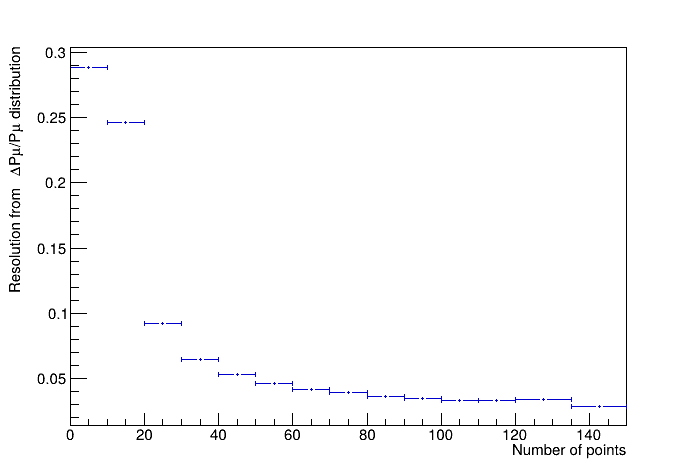

In [61]:
# Resolution (GAUSS) for events with N_points = X
ROOT.gStyle.SetOptStat(0)
c = TCanvas()
import array

h2 = df_res.Histo2D(("h2", " ", 20, 0 , 150, 75, -1., 1.), "N_points", "res")
# h2 = df_extended2.Histo2D(("h2", " ", 15, 0 , 150, 100, -1., 1.), "mu_points", "res")
hist2 = h2.GetValue()


bin_edges_array = array.array('d', list(range(0, 121, 10)) + [135, 150])
sigma_hist = ROOT.TH1D("sigma_point", " ", len(bin_edges_array)-1, bin_edges_array)

#sigma_hist = ROOT.TH1D("sigma", " ",hist2.GetNbinsX(), hist2.GetXaxis().GetXmin(), hist2.GetXaxis().GetXmax())

for ibin in range(1, hist2.GetNbinsX() + 1):
    proj = hist2.ProjectionY(f"proj_{ibin}", ibin, ibin)
    
    if proj.GetEntries() < 1:
         continue
    
    fit = proj.Fit("gaus", "QS")  #Store result senza stamparlo

#if proj.GetEntries() > 0:
    #fit = proj.Fit("gaus", "QS")  #Store result senza stamparlo
    if int(fit) == 0:  # fit riuscito
            sigma = fit.Parameter(2)
            sigma_err = fit.ParError(2)
            sigma_hist.SetBinContent(ibin, sigma)
            sigma_hist.SetBinError(ibin, sigma_err)
#sigma_hist.SetMarkerStyle(6) #20
sigma_hist.GetXaxis().SetTitle("Number of points")
# sigma_hist.GetXaxis().SetTitle("number of points")
# sigma_hist.GetXaxis().SetRangeUser(0, 140)
sigma_hist.GetYaxis().SetTitle("Resolution from #DeltaP#mu/P#mu distribution")

sigma_hist.SetMarkerStyle(6)   # 5 = croce
# sigma_hist.SetMarkerSize(1.2)  # dimensione della croce
sigma_hist.SetMarkerColor(ROOT.kBlue+1)
sigma_hist.SetLineColor(ROOT.kBlue+1)

sigma_hist.Draw("E1P")
c.Draw()

# f_out.cd()
# sigma_hist.GetValue().Write()


In [62]:
# Resolution (GAUSS) for events with N_points = X
ROOT.gStyle.SetOptStat(0)
c = TCanvas()

h2 = df_res.Histo2D(("h2", " ", 20, 0 , 6000, 100, -1., 1.), "mu_P", "res")
# h2 = df_extended2.Histo2D(("h2", " ", 15, 0 , 150, 100, -1., 1.), "mu_points", "res")
hist2 = h2.GetValue()

sigma_hist2 = ROOT.TH1D("sigma", " ",hist2.GetNbinsX(), hist2.GetXaxis().GetXmin(), hist2.GetXaxis().GetXmax())

for ibin in range(1, hist2.GetNbinsX() + 1):
    proj = hist2.ProjectionY(f"proj_{ibin}", ibin, ibin)
    
    if proj.GetEntries() < 1:
         continue
    
    fit = proj.Fit("gaus", "QS")  #Store result senza stamparlo

#if proj.GetEntries() > 0:
    #fit = proj.Fit("gaus", "QS")  #Store result senza stamparlo
    if int(fit) == 0:  # fit riuscito
            sigma2 = fit.Parameter(2)
            sigma_err2 = fit.ParError(2)
            sigma_hist2.SetBinContent(ibin, sigma)
            sigma_hist2.SetBinError(ibin, sigma_err)
#sigma_hist.SetMarkerStyle(6) #20
sigma_hist2.GetXaxis().SetTitle("muon momentum (Mev)")
# sigma_hist.GetXaxis().SetTitle("number of points")
# sigma_hist.GetXaxis().SetRangeUser(0, 140)
sigma_hist2.GetYaxis().SetTitle("Resolution from #DeltaP#mu/P#mu distribution")

sigma_hist2.SetMarkerStyle(6)   # 5 = croce
# sigma_hist.SetMarkerSize(1.2)  # dimensione della croce
sigma_hist2.SetMarkerColor(ROOT.kBlue+1)
sigma_hist2.SetLineColor(ROOT.kBlue+1)

# sigma_hist2.Draw("E1P")
# c.Draw()
# c.SaveAs("resolution_mom.png")


Warning in <TROOT::Append>: Replacing existing TH1: sigma (Potential memory leak).


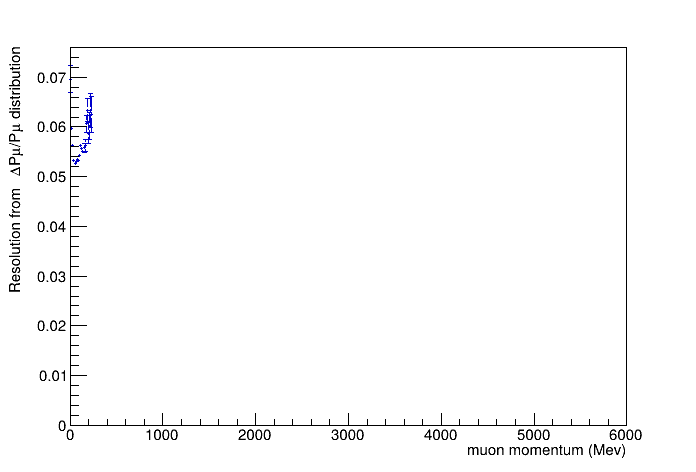

In [ ]:
# ROOT.gStyle.SetOptStat(0)
# c = TCanvas()


# h2 = df_res.Histo2D(("h2", " ", 20, 0 , 6000, 100, -1., 1.), "mu_P", "res")
# hist2 = h2.GetValue()


# bin_edges_array = array.array('d', list(range(0, 4001, 12)) + [5000, 6000])
# sigma_hist = ROOT.TH1D("sigma", " ", len(bin_edges_array)-1, bin_edges_array)

# #sigma_hist = ROOT.TH1D("sigma", " ",hist2.GetNbinsX(), hist2.GetXaxis().GetXmin(), hist2.GetXaxis().GetXmax())

# for ibin in range(1, hist2.GetNbinsX() + 1):
#     proj = hist2.ProjectionY(f"proj_{ibin}", ibin, ibin)
    
#     if proj.GetEntries() < 1:
#          continue
    
#     fit = proj.Fit("gaus", "QS")  #Store result senza stamparlo

# #if proj.GetEntries() > 0:
#     #fit = proj.Fit("gaus", "QS")  #Store result senza stamparlo
#     if int(fit) == 0:  # fit riuscito
#             sigma = fit.Parameter(2)
#             sigma_err = fit.ParError(2)
#             sigma_hist.SetBinContent(ibin, sigma)
#             sigma_hist.SetBinError(ibin, sigma_err)
# #sigma_hist.SetMarkerStyle(6) #20
# sigma_hist.GetXaxis().SetTitle("muon momentum (Mev)")
# # sigma_hist.GetXaxis().SetTitle("number of points")
# # sigma_hist.GetXaxis().SetRangeUser(0, 140)
# sigma_hist.GetYaxis().SetTitle("Resolution from #DeltaP#mu/P#mu distribution")

# sigma_hist.SetMarkerStyle(6)   # 5 = croce
# # sigma_hist.SetMarkerSize(1.2)  # dimensione della croce
# sigma_hist.SetMarkerColor(ROOT.kBlue+1)
# sigma_hist.SetLineColor(ROOT.kBlue+1)

# sigma_hist.Draw("E1P")
# c.Draw()

In [64]:
ROOT.gStyle.SetOptStat(0)
c = ROOT.TCanvas()

# Creo l'istogramma 2D originale
h2 = df_res.Histo2D(("h2", " ", 20, 0, 6000, 100, -1., 1.), "mu_P", "res")
hist2 = h2.GetValue()

# Definisco i bordi dei bin di sigma_hist
# Esempio: bin regolari da 0 a 4000 con passo 200
bins_sigma = list(range(0, 4001, 400))
# Poi 3 bin tra 4000 e 6000
bins_sigma += [4000, 4666.67, 5333.33, 6000]
bins_sigma = array('d', bins_sigma)

# Creo sigma_hist con bin non uniformi
sigma_hist2 = ROOT.TH1D("sigma_mom", " ", len(bins_sigma)-1, bins_sigma)

for ibin in range(1, hist2.GetNbinsX() + 1):
    proj = hist2.ProjectionY(f"proj_{ibin}", ibin, ibin)
    
    if proj.GetEntries() < 1:
        continue
    
    fit = proj.Fit("gaus", "QS")  # store result senza stampare

    if int(fit) == 0:  # fit riuscito
        sigma2 = fit.Parameter(2)
        sigma_err2 = fit.ParError(2)

        # Metto il contenuto nella bin giusta di sigma_hist
        x_center = hist2.GetXaxis().GetBinCenter(ibin)
        bin_sigma = sigma_hist2.FindBin(x_center)
        sigma_hist2.SetBinContent(bin_sigma, sigma)
        sigma_hist2.SetBinError(bin_sigma, sigma_err)

sigma_hist2.GetXaxis().SetTitle("muon momentum (MeV)")
sigma_hist2.GetYaxis().SetTitle("Resolution from #DeltaP#mu/P#mu distribution")
sigma_hist2.GetYaxis().SetRangeUser(0.045, 0.075)

sigma_hist2.SetMarkerStyle(6)
sigma_hist2.SetMarkerColor(ROOT.kBlue+1)
sigma_hist2.SetLineColor(ROOT.kBlue+1)

sigma_hist2.Draw("E1P")
c.Draw()

# f_out.cd()
# sigma_hist2.GetValue().Write()


TypeError: 'module' object is not callable

In [ ]:
#RIFAI QUESTA EFFICIENZA PRENDENDO I DF GIUSTI 

# ROOT.gStyle.SetOptStat(0)
# df_num = df_res.Filter("true_flag == 1")
# df_den = df_res.Filter("true_flag == 1 && reco_flag == 1")

# nbins = 20
# xmin, xmax = 0, 6000

# h_num = df_num.Histo1D(("h_num", " ", nbins, xmin, xmax), "mu_P")
# h_den = df_den.Histo1D(("h_den", " ", nbins, xmin, xmax), "mu_P")

# h_num = h_num.GetValue()
# h_den = h_den.GetValue()

# g_eff = ROOT.TGraphAsymmErrors()
# g_eff.Divide(h_num, h_den)

# c = ROOT.TCanvas()
# #g_eff.SetTitle("Muon efficiency vs mu_P")
# g_eff.GetXaxis().SetTitle("Muon momentum (MeV)")
# g_eff.GetYaxis().SetTitle("Efficiency")
# # g_eff.SetMarkerStyle(6)
# g_eff.SetMarkerColor(ROOT.kRed + 1)
# g_eff.Draw("AP")
# c.Draw()

In [ ]:
ROOT.gInterpreter.Declare("""
bool has_muon(const ROOT::VecOps::RVec<int>& pdgs) {
        for (int x : pdgs) {
        if (x == -13) {
            return true; 
        }
    }
    return false;
}
""")

df_new = ( df_res.Define("has_muon", "has_muon(primaries_PDG)"))

ROOT.gStyle.SetOptStat(0)
df_num = df_new.Filter("has_muon == true && mu_points > 0")
df_den = df_new.Filter("has_muon == true")

nbins = 20
xmin, xmax = 0, 7000

h_num = df_num.Histo1D(("h_num", " ", nbins, xmin, xmax), "mu_P")
h_den = df_den.Histo1D(("h_den", " ", nbins, xmin, xmax), "mu_P")

h_num = h_num.GetValue()
h_den = h_den.GetValue()

g_eff = ROOT.TGraphAsymmErrors()
g_eff.Divide(h_num, h_den)

c = ROOT.TCanvas()
#g_eff.SetTitle("Muon efficiency vs mu_P")
g_eff.GetXaxis().SetTitle("Muon momentum (MeV)")
g_eff.GetYaxis().SetTitle("Efficiency")
# g_eff.SetMarkerStyle(6)
g_eff.SetMarkerColor(ROOT.kRed + 1)
g_eff.Draw("AP")
c.Draw()

Info in <TCanvas::Print>: pdf file track_cut.pdf has been created
Info in <TCanvas::Print>: png file track_cut.png has been created


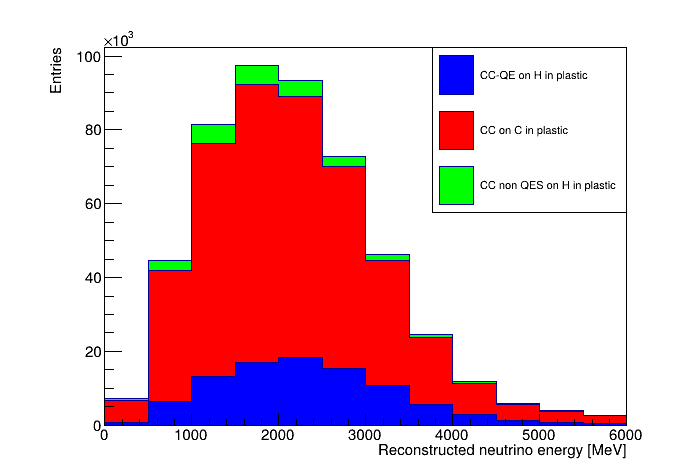

In [10]:
#selected events after track cut on POLYPROPYLENE

nbin = 12

df_plastic = df_one_track.Filter('Where_int == "C3H6"')

hist_1T = df_plastic.Filter('target == "tgt:1000010010" && st_proc_type == "proc:Weak[CC],QES"').Histo1D(("hist_1T", "", nbin, 0, 6000),"nu_Ereco")
hist_2T = df_plastic.Filter('target == "tgt:1000060120"').Histo1D(("hist_2T", "", nbin, 0, 6000),"nu_Ereco")
hist_3T = df_plastic.Filter('target == "tgt:1000010010" && st_proc_type != "proc:Weak[CC],QES"').Histo1D(("hist_3T", "", nbin, 0, 6000),"nu_Ereco")


# hist_4 = df_TIME.Filter("Evt_cat == 4").Histo1D(("hist_4", "", nbin, 0, 10000),"Enu")
# hist_0 = df_TIME.Filter('Evt_cat == 0 && target != "tgt:1000010010" && target != "tgt:1000060120"').Histo1D(("hist_0", "", nbin, 0, 10000),"Enu")

# hist_6 = df_TIME.Filter('Evt_cat == 0 && target == "tgt:1000010010"')
# hist_7 = df_TIME.Filter('Evt_cat == 0 && target == "tgt:1000060120"')

hist_1T.SetFillColor(ROOT.kBlue)
hist_2T.SetFillColor(ROOT.kRed)
hist_3T.SetFillColor(ROOT.kGreen)
# hist_0.SetFillColor(ROOT.kGreen)
# hist_6.SetFillColor(ROOT.kBlue +1 )
# hist_7.SetFillColor(ROOT.kRed + 2 )


stackT = ROOT.THStack("stack", " ")
stackT.Add(hist_1T.GetPtr())
stackT.Add(hist_2T.GetPtr())
stackT.Add(hist_3T.GetPtr())

# stack.Add(hist_0.GetPtr())
# stack.Add(hist_6.GetPtr())
# stack.Add(hist_7.GetPtr())

cT = ROOT.TCanvas()
cT.SetLeftMargin(0.15)

stackT.Draw("HIST")
stackT.GetXaxis().SetTitle("Reconstructed neutrino energy [MeV]")
stackT.GetYaxis().SetTitle("Entries")

legend = ROOT.TLegend(0.62, 0.55, 0.90, 0.90)


legend.AddEntry(hist_1T.GetPtr(), "CC-QE on H in plastic", "f")
legend.AddEntry(hist_2T.GetPtr(), "CC on C in plastic", "f")
legend.AddEntry(hist_3T.GetPtr(), "CC non QES on H in plastic", "f")

# legend.AddEntry(hist_6.GetPtr(), "evt")
# legend.AddEntry(hist_0.GetPtr(), "background", "f")

legend.Draw()

cT.Draw()

# f_out.cd()

# hist_1T.GetValue().Write()
# hist_2T.GetValue().Write()
# hist_3T.GetValue().Write()
# stackT.GetValue().Write()
cT.SaveAs("track_cut.pdf")
cT.SaveAs("track_cut.png")

In [ ]:
# df_vol = df_flag.Filter("volume_flag == 1")
# df_reco = df_flag.Filter("volume_flag == 1 && reco_flag == 1")

# evt_tot = [
#     df.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]
# evt_vol = [
#     df_vol.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]
# evt_reco = [
#     df_reco.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]

# evt_track = [
#     df_one_track.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]

# # Calcolo percentuali
# print(f"{'Category':<10}{'Total':<10}{'Volume':<10}{'Removed (%)':<15}{'Good Reco':<15}{'Removed (%)':<15}{'1 track':<12} {'Removed (%)':<15}")
# print("-" * 100)

# for i in range(6):
#     tot = evt_tot[i]
#     vol = evt_vol[i]
#     reco = evt_reco[i]
#     one = evt_track[i]
#     perc_removed1 = 0 if tot == 0 else (tot - vol) / tot * 100
#     perc_removed2 = 0 if tot == 0 else (vol - reco) / vol * 100
#     perc_removed3 = 0 if tot == 0 else (reco - one) / reco * 100
    
#     print(f"{i:<10} {tot:<10}{vol:<10}{perc_removed1:<15.2f}{reco:<15}{perc_removed2:<15.2f}{one:<12} {perc_removed3:<15.2f}")


Category  Total     Volume    Removed (%)    Good Reco      Removed (%)    1 track      Removed (%)    
----------------------------------------------------------------------------------------------------
0          757655    569621    24.82          357148         37.30          152817       57.21          
1          50378     50378     0.00           40718          19.18          40718        0.00           
2          122029    122029    0.00           100388         17.73          86206        14.13          
3          43345     43345     0.00           34933          19.41          11223        67.87          
4          23728     23728     0.00           19608          17.36          16434        16.19          
5          1865      1865      0.00           707            62.09          350          50.50          


In [ ]:
# df_check = df_flag.Filter("true_flag == 1 && reco_flag == 1").Display(["n_px","n_px_pred","n_py","n_py_pred","n_pz","n_pz_pred"],100).Print()

In [ ]:
# df_flag.Filter("true_flag == 1 && reco_flag == 1").Display(["true_n_startY","true_n_stopY","true_n_startX","true_n_stopX","true_n_startZ","true_n_stopZ"],100).Print()


In [ ]:
# df_flag.Filter("true_flag == 1 && reco_flag == 1").Display(["n_px","n_py","n_pz","n_px_pred","n_py_pred","n_pz_pred"]).Print()

NEUTRON SPACE SELECTION

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


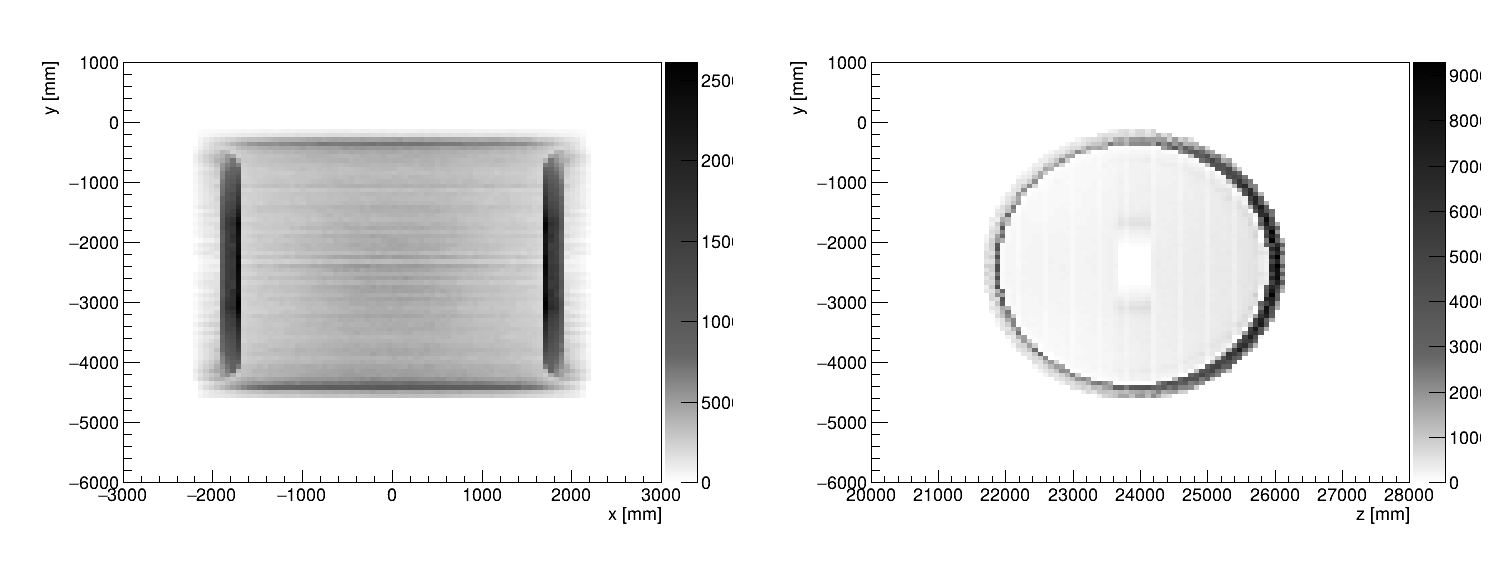

In [66]:
#x,y,z of the ECAL clusters

x_vecs = df.Take["ROOT::VecOps::RVec<double>"]("x_ecal")
y_vecs = df.Take["ROOT::VecOps::RVec<double>"]("y_ecal")
z_vecs = df.Take["ROOT::VecOps::RVec<double>"]("z_ecal")

x_all = np.concatenate([np.array(v, dtype=float) for v in x_vecs])
y_all = np.concatenate([np.array(v, dtype=float) for v in y_vecs])
z_all = np.concatenate([np.array(v, dtype=float) for v in z_vecs])


h_xy = ROOT.TH2F("h_xy", " ", 100, -3000, 3000, 100, -6000, 1000)
h_zy = ROOT.TH2F("h_zy", " ", 100, 20000, 28000, 100, -6000, 1000)

for x, y, z in zip(x_all, y_all, z_all):
    h_xy.Fill(x, y)
    h_zy.Fill(z, y)


c = TCanvas("c1", "Canvas", 1500, 600)
c.Divide(2, 1)
c.Draw()

ROOT.gStyle.SetOptStat(0)

c.cd(1)
pad1 = c.GetPad(1)
pad1.SetLeftMargin(0.15)   # margine sinistro più largo per la y
pad1.SetBottomMargin(0.15) # margine inferiore più largo per la x
# h_xy.SetStats(0)
# h_zy.SetStats(0)
h_xy.GetXaxis().SetTitle("x [mm]")
h_xy.GetYaxis().SetTitle("y [mm]")
h_xy.Draw("COLZ")

c.cd(2)
pad2 = c.GetPad(2)
pad2.SetLeftMargin(0.15)
pad2.SetBottomMargin(0.15)
h_zy.GetXaxis().SetTitle("z [mm]")
h_zy.GetYaxis().SetTitle("y [mm]")
h_zy.Draw("COLZ")

Warning in <TFile::Append>: Replacing existing TH1: h_xy (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_zy (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


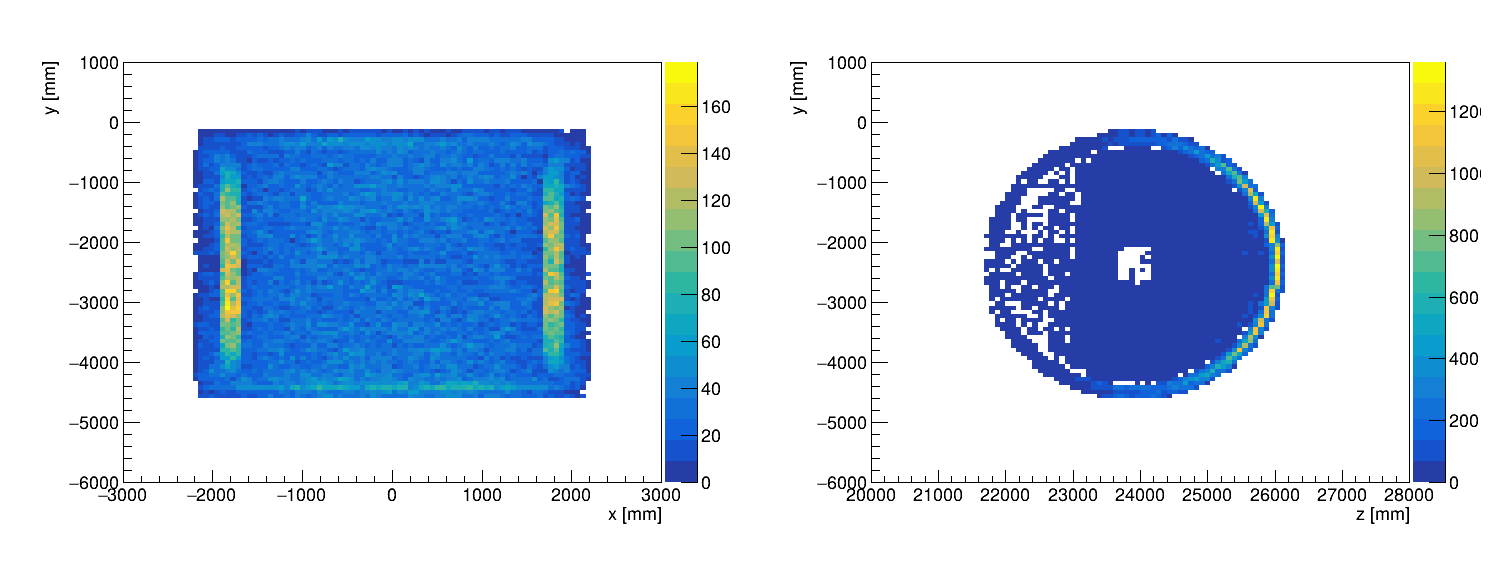

In [ ]:
df_true = df_flag.Filter("true_flag == 1")

x_vecs = df_true.Take["ROOT::VecOps::RVec<double>"]("x_ecal")
y_vecs = df_true.Take["ROOT::VecOps::RVec<double>"]("y_ecal")
z_vecs = df_true.Take["ROOT::VecOps::RVec<double>"]("z_ecal")

x_all = np.concatenate([np.array(v, dtype=float) for v in x_vecs])
y_all = np.concatenate([np.array(v, dtype=float) for v in y_vecs])
z_all = np.concatenate([np.array(v, dtype=float) for v in z_vecs])


h_xy = ROOT.TH2F("h_xy", " ", 100, -3000, 3000, 100, -6000, 1000)
h_zy = ROOT.TH2F("h_zy", " ", 100, 20000, 28000, 100, -6000, 1000)

for x, y, z in zip(x_all, y_all, z_all):
    h_xy.Fill(x, y)
    h_zy.Fill(z, y)


c = TCanvas("c1", "Canvas", 1500, 600)
c.Divide(2, 1)
c.Draw()

ROOT.gStyle.SetOptStat(0)

c.cd(1)
pad1 = c.GetPad(1)
pad1.SetLeftMargin(0.15)   # margine sinistro più largo per la y
pad1.SetBottomMargin(0.15) # margine inferiore più largo per la x
# h_xy.SetStats(0)
# h_zy.SetStats(0)
h_xy.GetXaxis().SetTitle("x [mm]")
h_xy.GetYaxis().SetTitle("y [mm]")
h_xy.Draw("COLZ")

c.cd(2)
pad2 = c.GetPad(2)
pad2.SetLeftMargin(0.15)
pad2.SetBottomMargin(0.15)
h_zy.GetXaxis().SetTitle("z [mm]")
h_zy.GetYaxis().SetTitle("y [mm]")
h_zy.Draw("COLZ")

del df_true

Warning in <TFile::Append>: Replacing existing TH1: h_xy (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_zy (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


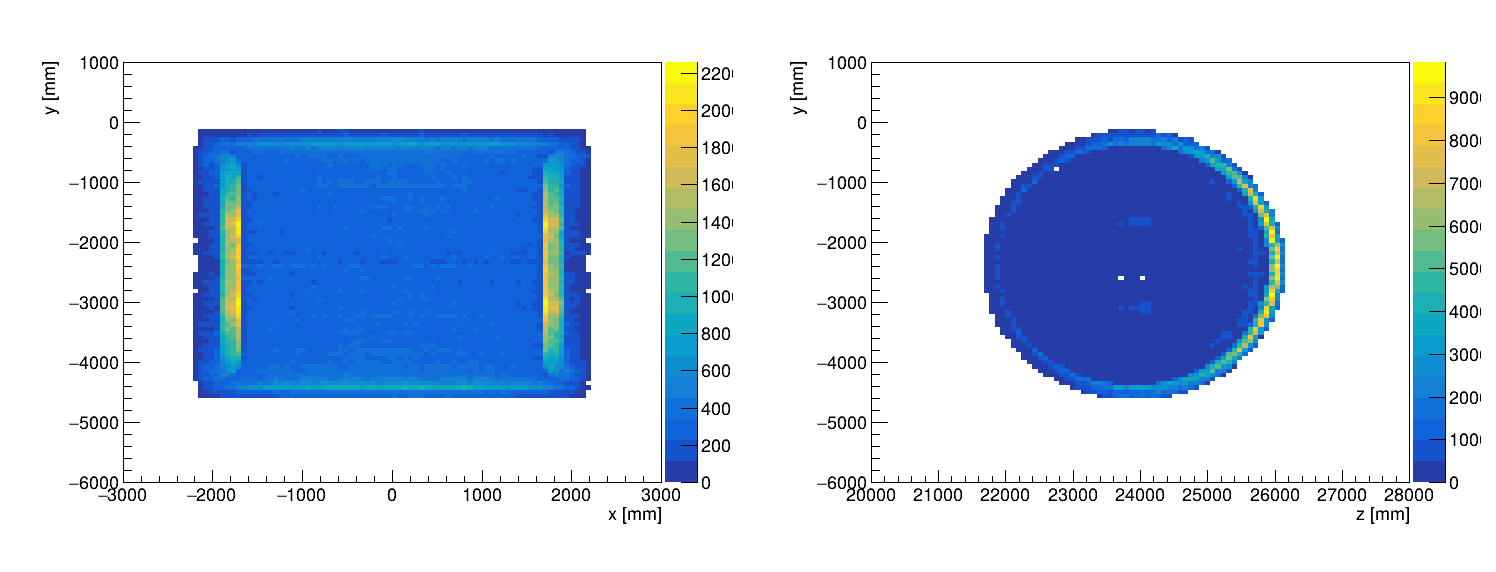

In [ ]:
df_sel = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1")

x_vecs = df_sel.Take["ROOT::VecOps::RVec<double>"]("x_ecal")
y_vecs = df_sel.Take["ROOT::VecOps::RVec<double>"]("y_ecal")
z_vecs = df_sel.Take["ROOT::VecOps::RVec<double>"]("z_ecal")

x_all = np.concatenate([np.array(v, dtype=float) for v in x_vecs])
y_all = np.concatenate([np.array(v, dtype=float) for v in y_vecs])
z_all = np.concatenate([np.array(v, dtype=float) for v in z_vecs])


h_xy = ROOT.TH2F("h_xy", " ", 100, -3000, 3000, 100, -6000, 1000)
h_zy = ROOT.TH2F("h_zy", " ", 100, 20000, 28000, 100, -6000, 1000)

for x, y, z in zip(x_all, y_all, z_all):
    h_xy.Fill(x, y)
    h_zy.Fill(z, y)


c = TCanvas("c1", "Canvas", 1500, 600)
c.Divide(2, 1)
c.Draw()

ROOT.gStyle.SetOptStat(0)

c.cd(1)
pad1 = c.GetPad(1)
pad1.SetLeftMargin(0.15)   # margine sinistro più largo per la y
pad1.SetBottomMargin(0.15) # margine inferiore più largo per la x
# h_xy.SetStats(0)
# h_zy.SetStats(0)
h_xy.GetXaxis().SetTitle("x [mm]")
h_xy.GetYaxis().SetTitle("y [mm]")
h_xy.Draw("COLZ")

c.cd(2)
pad2 = c.GetPad(2)
pad2.SetLeftMargin(0.15)
pad2.SetBottomMargin(0.15)
h_zy.GetXaxis().SetTitle("z [mm]")
h_zy.GetYaxis().SetTitle("y [mm]")
h_zy.Draw("COLZ")

del df_sel

Warning in <TFile::Append>: Replacing existing TH1: h_xy (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_zy (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


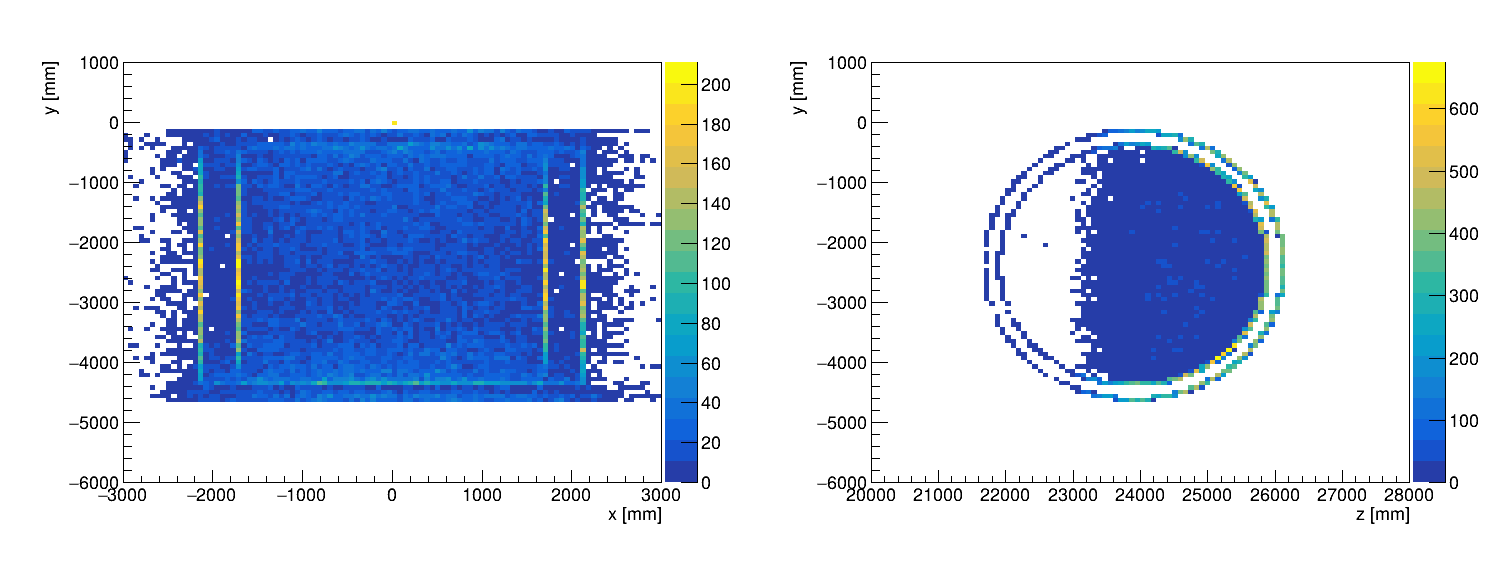

In [ ]:
#predicted point in the edge of the ECAL

df_true = df_flag.Filter("true_flag == 1")

df_xyz = (df_true.Define("x_pred", "ROOT::VecOps::RVec<double>{hit_pred[0], hit_pred[3]}")
          .Define("y_pred", "ROOT::VecOps::RVec<double>{hit_pred[1], hit_pred[4]}")
          .Define("z_pred", "ROOT::VecOps::RVec<double>{hit_pred[2], hit_pred[5]}")
         )

x_vecs = df_xyz.Take["ROOT::VecOps::RVec<double>"]("x_pred")
y_vecs = df_xyz.Take["ROOT::VecOps::RVec<double>"]("y_pred")
z_vecs = df_xyz.Take["ROOT::VecOps::RVec<double>"]("z_pred")

x_all = np.concatenate([np.array(v, dtype=float) for v in x_vecs])
y_all = np.concatenate([np.array(v, dtype=float) for v in y_vecs])
z_all = np.concatenate([np.array(v, dtype=float) for v in z_vecs])


h_xy = ROOT.TH2F("h_xy", " ", 100, -3000, 3000, 100, -6000, 1000)
h_zy = ROOT.TH2F("h_zy", " ", 100, 20000, 28000, 100, -6000, 1000)

for x, y, z in zip(x_all, y_all, z_all):
    h_xy.Fill(x, y)
    h_zy.Fill(z, y)


c = TCanvas("c1", "Canvas", 1500, 600)
c.Divide(2, 1)


ROOT.gStyle.SetOptStat(0)

c.cd(1)
pad1 = c.GetPad(1)
pad1.SetLeftMargin(0.15)   # margine sinistro più largo per la y
pad1.SetBottomMargin(0.15) # margine inferiore più largo per la x
# h_xy.SetStats(0)
# h_zy.SetStats(0)
h_xy.GetXaxis().SetTitle("x [mm]")
h_xy.GetYaxis().SetTitle("y [mm]")
h_xy.Draw("COLZ")

c.cd(2)
pad2 = c.GetPad(2)
pad2.SetLeftMargin(0.15)
pad2.SetBottomMargin(0.15)
h_zy.GetXaxis().SetTitle("z [mm]")
h_zy.GetYaxis().SetTitle("y [mm]")
h_zy.Draw("COLZ")

c.Draw()

del df_true

Warning in <TFile::Append>: Replacing existing TH1: h_xy (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_zy (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


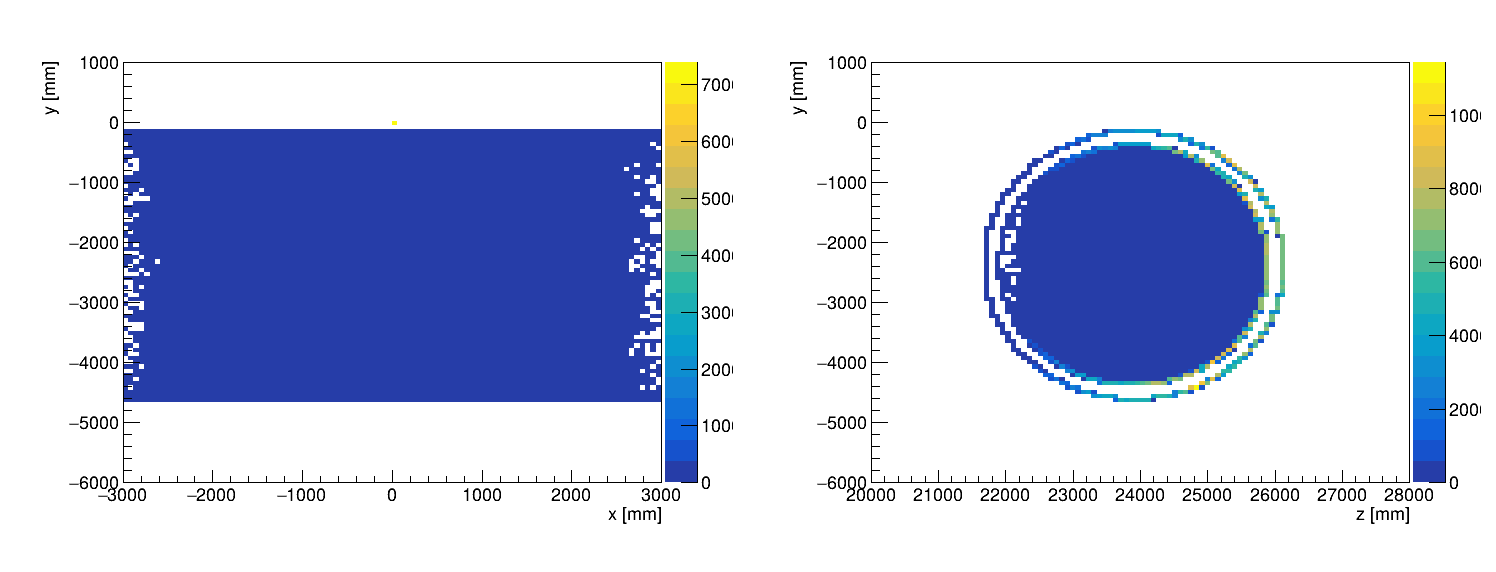

In [ ]:
df_nontrue = df_flag.Filter("true_flag == 0")

df_xyz = (df_nontrue.Define("x_pred", "ROOT::VecOps::RVec<double>{hit_pred[0], hit_pred[3]}")
           .Define("y_pred", "ROOT::VecOps::RVec<double>{hit_pred[1], hit_pred[4]}")
          .Define("z_pred", "ROOT::VecOps::RVec<double>{hit_pred[2], hit_pred[5]}")
         )

x_vecs = df_xyz.Take["ROOT::VecOps::RVec<double>"]("x_pred")
y_vecs = df_xyz.Take["ROOT::VecOps::RVec<double>"]("y_pred")
z_vecs = df_xyz.Take["ROOT::VecOps::RVec<double>"]("z_pred")

x_all = np.concatenate([np.array(v, dtype=float) for v in x_vecs])
y_all = np.concatenate([np.array(v, dtype=float) for v in y_vecs])
z_all = np.concatenate([np.array(v, dtype=float) for v in z_vecs])


h_xy = ROOT.TH2F("h_xy", " ", 100, -3000, 3000, 100, -6000, 1000)
h_zy = ROOT.TH2F("h_zy", " ", 100, 20000, 28000, 100, -6000, 1000)

for x, y, z in zip(x_all, y_all, z_all):
    h_xy.Fill(x, y)
    h_zy.Fill(z, y)


c = TCanvas("c1", "Canvas", 1500, 600)
c.Divide(2, 1)


ROOT.gStyle.SetOptStat(0)

c.cd(1)
pad1 = c.GetPad(1)
pad1.SetLeftMargin(0.15)   # margine sinistro più largo per la y
pad1.SetBottomMargin(0.15) # margine inferiore più largo per la x
# h_xy.SetStats(0)
# h_zy.SetStats(0)
h_xy.GetXaxis().SetTitle("x [mm]")
h_xy.GetYaxis().SetTitle("y [mm]")
h_xy.Draw("COLZ")

c.cd(2)
pad2 = c.GetPad(2)
pad2.SetLeftMargin(0.15)
pad2.SetBottomMargin(0.15)
h_zy.GetXaxis().SetTitle("z [mm]")
h_zy.GetYaxis().SetTitle("y [mm]")
h_zy.Draw("COLZ")

c.Draw()

del df_nontrue

In [11]:
# ROOT.gInterpreter.Declare("""
# ROOT::VecOps::RVec<double> ComparisonPoint( const ROOT::VecOps::RVec<double>& x_ecal, const ROOT::VecOps::RVec<double>& y_ecal, const ROOT::VecOps::RVec<double>& z_ecal, const ROOT::VecOps::RVec<double>& t_ecal,
#                                        const ROOT::VecOps::RVec<double>& true_x_pos, const ROOT::VecOps::RVec<double>& true_y_pos, const ROOT::VecOps::RVec<double>& true_z_pos, const ROOT::VecOps::RVec<double>& true_t){
                          
#     ROOT::VecOps::RVec<double> selected(8, -1e10);
#     double min_dist = 1e9;
#     int best_i = -1;
#     int best_j = -1;

#     //comparison between cluster points and hit_Start points                      
#     for (size_t i = 0; i < x_ecal.size(); ++i) {
#         for (size_t j = 0; j < true_x_pos.size(); ++j) {
#             double dx = x_ecal[i] - true_x_pos[j];
#             double dy = y_ecal[i] - true_y_pos[j];
#             double dz = z_ecal[i] - true_z_pos[j];
#             double dist = std::sqrt(dx*dx + dy*dy + dz*dz);

#             if (dist < min_dist) {
#                 min_dist = dist;
#                 best_i = i;
#                 best_j = j;
#             }
#         }
#     }

#     // Se ha trovato un match valido, salva i valori corrispondenti
#     if (best_i >= 0 && best_j >= 0) {
#         selected[0] = x_ecal[best_i];
#         selected[1] = y_ecal[best_i];
#         selected[2] = z_ecal[best_i];
#         selected[3] = t_ecal[best_i];
#         selected[4] = true_x_pos[best_j];
#         selected[5] = true_y_pos[best_j];
#         selected[6] = true_z_pos[best_j];
#         selected[7] = true_t[best_j];
#     }

#     return selected;                          
                          
#                           }
#                                                     """)


df_ECAL = (df_flag.Define("best_match", "ComparisonPoint(x_ecal,  y_ecal,  z_ecal, t_ecal, true_n_startX, true_n_startY, true_n_startZ, true_n_startT)")
                 .Define("Res_x", "best_match[0] - best_match[4]" )
                 .Define("Res_y", "best_match[1] - best_match[5]" )
                 .Define("Res_z", "best_match[2] - best_match[6]" )
                 .Define("Res_t", "best_match[3] - best_match[7]" )
                #  .Define("distance_segpoint", "nearest_segpoint[4]")
                #  .Define("distance_ecalpoint", "nearest_ecalpoint[4]")
                 .Define("Res_seg_x", "hit_pred[0] - nearest_segpoint[0]")
                 .Define("Res_seg_y", "hit_pred[1] - nearest_segpoint[1]")
                 .Define("Res_seg_z", "hit_pred[2] - nearest_segpoint[2]")
           
)


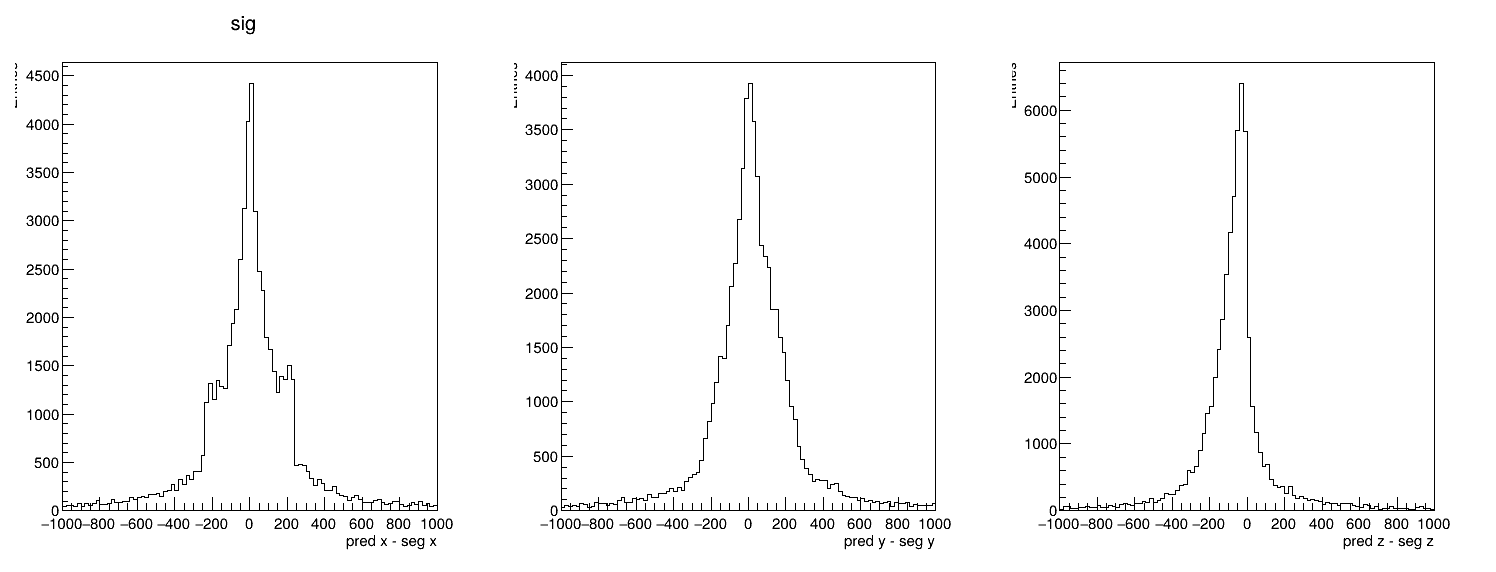

In [68]:
c = TCanvas("c", " ", 1500, 600)
ROOT.gStyle.SetOptStat(0)
c.Divide(3,1)

#max = 10000
#min = -10000


hx = df_ECAL.Filter("true_flag == 1").Histo1D(("h", " sig ", 100, -1000, 1000),"Res_seg_x")
hy = df_ECAL.Filter("true_flag == 1").Histo1D(("h", "  ", 100, -1000, 1000),"Res_seg_y")
hz = df_ECAL.Filter("true_flag == 1").Histo1D(("h", "  ", 100, -1000, 1000),"Res_seg_z")


ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)

c.cd(1)
hx.GetXaxis().SetTitle("pred x - seg x")
hx.GetYaxis().SetTitle("Entries")
hx.Draw()


c.cd(2)
hy.GetXaxis().SetTitle("pred y - seg y")
hy.GetYaxis().SetTitle("Entries")
hy.Draw()

c.cd(3)
hz.GetXaxis().SetTitle("pred z - seg z")
hz.GetYaxis().SetTitle("Entries")
hz.Draw()

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


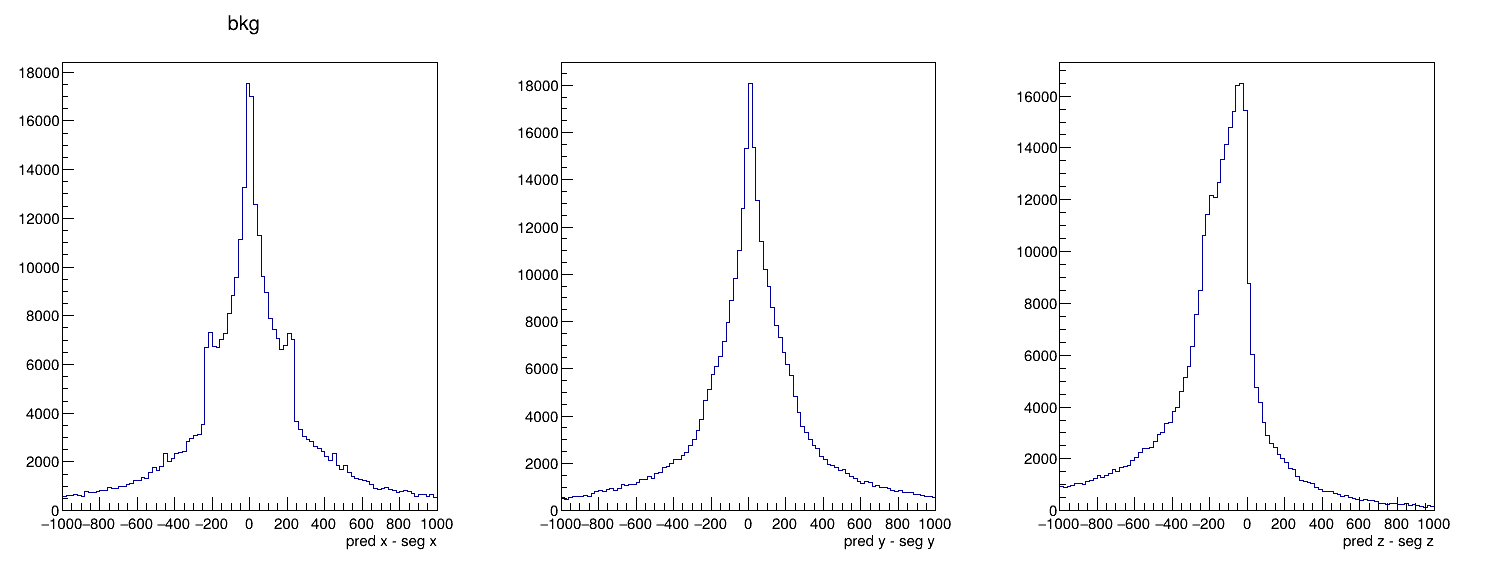

In [ ]:
c = TCanvas("c", " ", 1500, 600)
ROOT.gStyle.SetOptStat(0)
c.Divide(3,1)

#max = 10000
#min = -10000


hx = df_ECAL.Filter("true_flag == 0").Histo1D(("h", " bkg ", 100, -1000, 1000),"Res_seg_x")
hy = df_ECAL.Filter("true_flag == 0").Histo1D(("h", "  ", 100, -1000, 1000),"Res_seg_y")
hz = df_ECAL.Filter("true_flag == 0").Histo1D(("h", "  ", 100, -1000, 1000),"Res_seg_z")


ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)

c.cd(1)
hx.GetXaxis().SetTitle("pred x - seg x")
hx.GetYaxis().SetTitle("Entries")
hx.Draw()


c.cd(2)
hy.GetXaxis().SetTitle("pred y - seg y")
hy.GetYaxis().SetTitle("Entries")
hy.Draw()

c.cd(3)
hz.GetXaxis().SetTitle("pred z - seg z")
hz.GetYaxis().SetTitle("Entries")
hz.Draw()

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


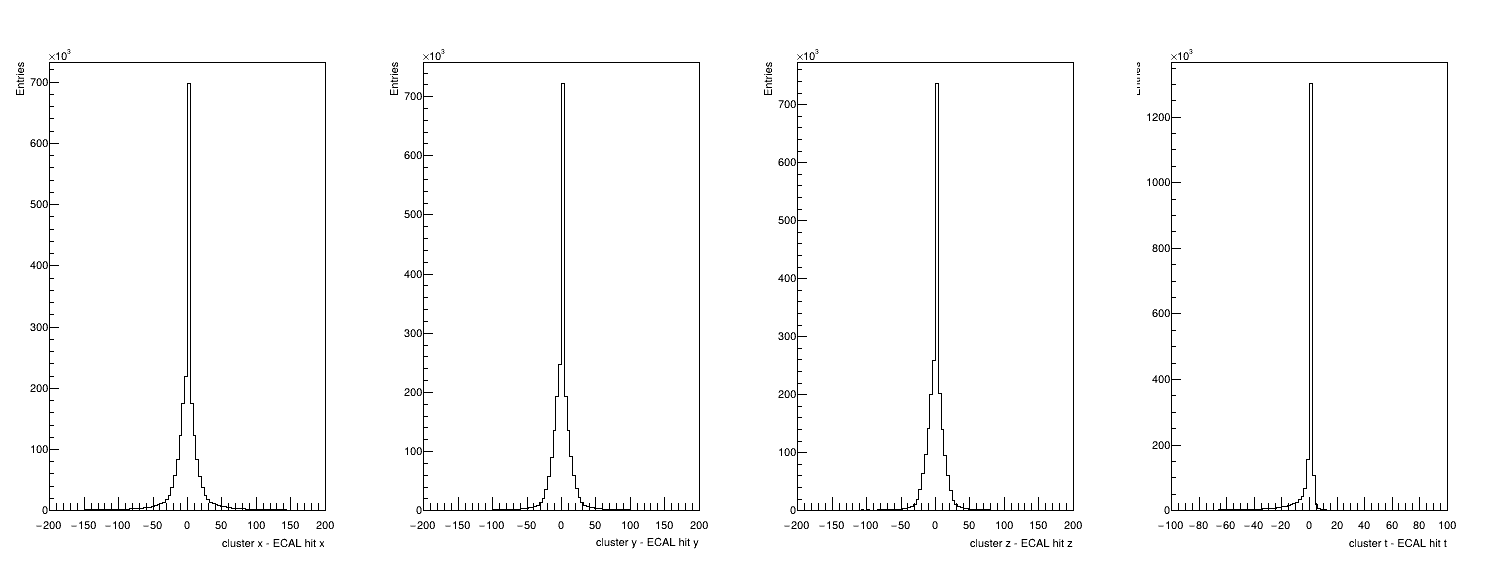

In [98]:
c = TCanvas("c", " ", 1500, 600)
ROOT.gStyle.SetOptStat(0)
c.Divide(4,1)

#max = 10000
#min = -10000


hx = df_ECAL.Histo1D(("h", "  ", 100, -200, 200),"Res_x")
hy = df_ECAL.Histo1D(("h", "  ", 100, -200, 200),"Res_y")
hz = df_ECAL.Histo1D(("h", "  ", 100, -200, 200),"Res_z")
ht = df_ECAL.Histo1D(("h", "  ", 100, -100, 100),"Res_t")


ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)

c.cd(1)
hx.GetXaxis().SetTitle("cluster x - ECAL hit x")
hx.GetYaxis().SetTitle("Entries")
hx.Draw()


c.cd(2)
hy.GetXaxis().SetTitle("cluster y - ECAL hit y")
hy.GetYaxis().SetTitle("Entries")
hy.Draw()

c.cd(3)
hz.GetXaxis().SetTitle("cluster z - ECAL hit z")
hz.GetYaxis().SetTitle("Entries")
hz.Draw()


c.cd(4)
ht.GetXaxis().SetTitle("cluster t - ECAL hit t")
ht.GetYaxis().SetTitle("Entries")
ht.Draw()

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


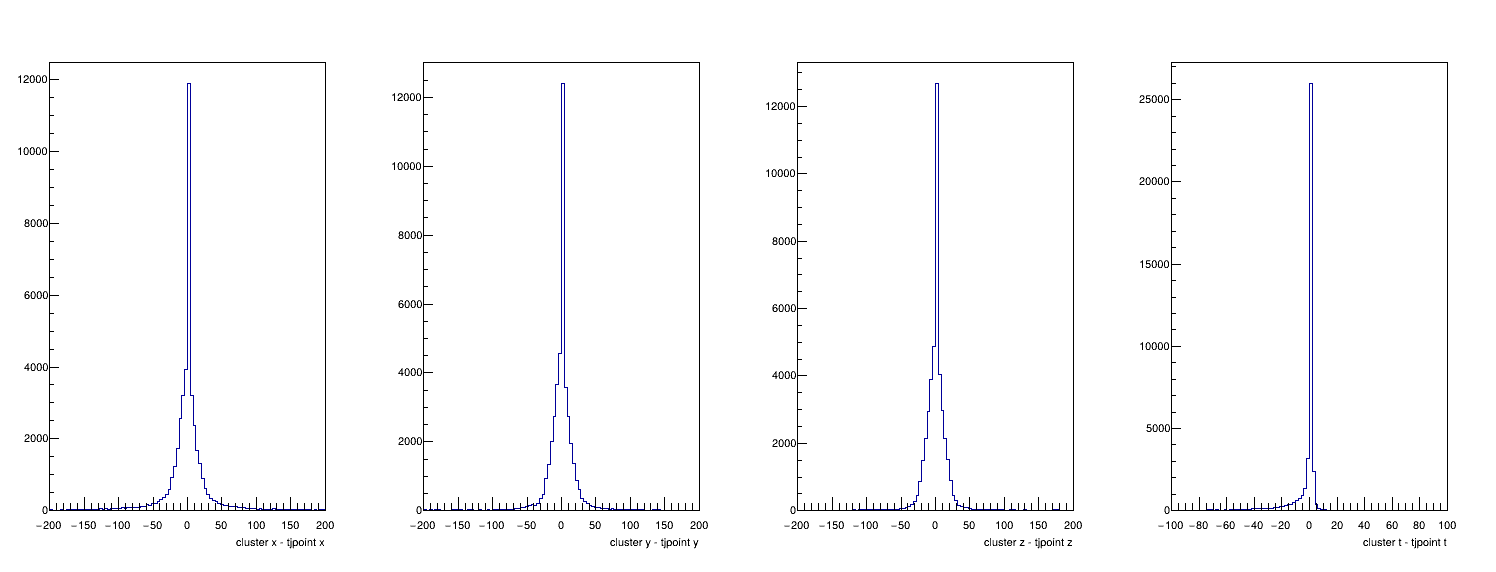

In [ ]:
c = TCanvas("c", " ", 1500, 600)
ROOT.gStyle.SetOptStat(0)
c.Divide(4,1)

#max = 10000
#min = -10000


hx = df_ECAL.Filter("true_flag == 1").Histo1D(("h", "  ", 100, -200, 200),"Res_x")
hy = df_ECAL.Filter("true_flag == 1").Histo1D(("h", "  ", 100, -200, 200),"Res_y")
hz = df_ECAL.Filter("true_flag == 1").Histo1D(("h", "  ", 100, -200, 200),"Res_z")
ht = df_ECAL.Filter("true_flag == 1").Histo1D(("h", "  ", 100, -100, 100),"Res_t")


ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)

c.cd(1)
hx.GetXaxis().SetTitle("cluster x - tjpoint x")
hx.GetYaxis().SetTitle("Entries")
hx.Draw()


c.cd(2)
hy.GetXaxis().SetTitle("cluster y - tjpoint y")
hy.GetYaxis().SetTitle("Entries")
hy.Draw()

c.cd(3)
hz.GetXaxis().SetTitle("cluster z - tjpoint z")
hz.GetYaxis().SetTitle("Entries")
hz.Draw()


c.cd(4)
ht.GetXaxis().SetTitle("cluster t - tjpoint t")
ht.GetYaxis().SetTitle("Entries")
ht.Draw()

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


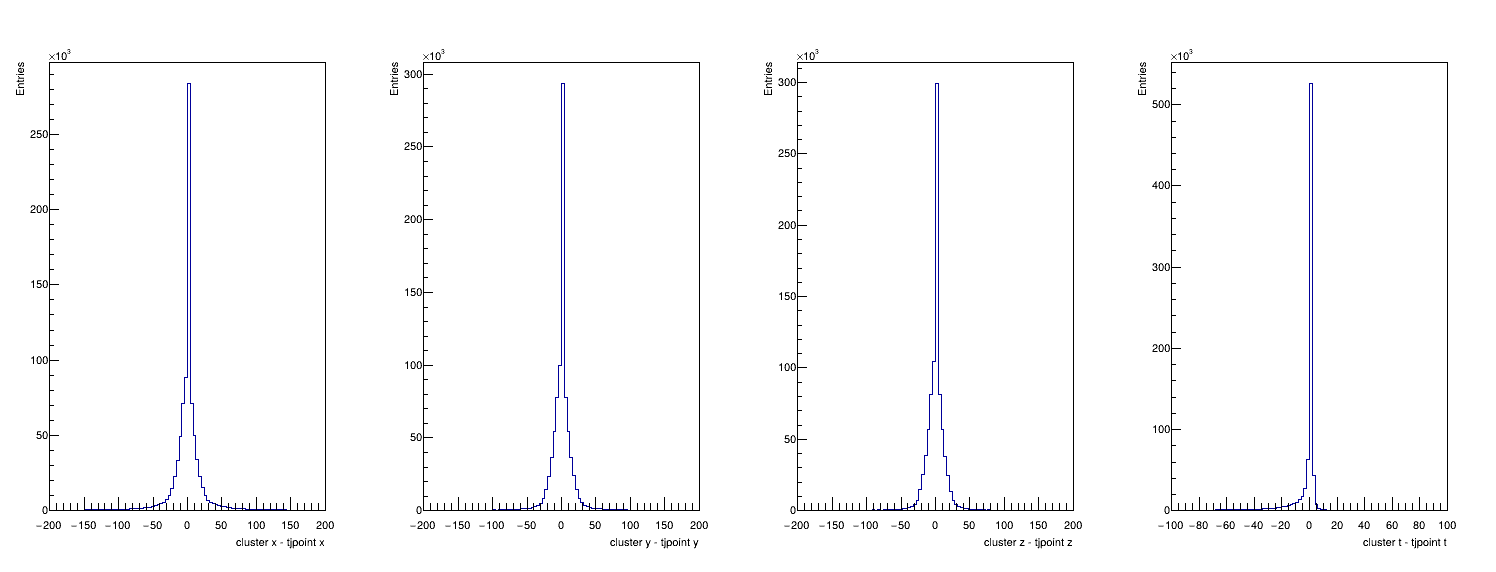

In [ ]:
c = TCanvas("c", " ", 1500, 600)
ROOT.gStyle.SetOptStat(0)
c.Divide(4,1)

#max = 10000
#min = -10000


hx = df_ECAL.Filter("true_flag == 0").Histo1D(("h", "  ", 100, -200, 200),"Res_x")
hy = df_ECAL.Filter("true_flag == 0").Histo1D(("h", "  ", 100, -200, 200),"Res_y")
hz = df_ECAL.Filter("true_flag == 0").Histo1D(("h", "  ", 100, -200, 200),"Res_z")
ht = df_ECAL.Filter("true_flag == 0").Histo1D(("h", "  ", 100, -100, 100),"Res_t")


ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)

c.cd(1)
hx.GetXaxis().SetTitle("cluster x - tjpoint x")
hx.GetYaxis().SetTitle("Entries")
hx.Draw()


c.cd(2)
hy.GetXaxis().SetTitle("cluster y - tjpoint y")
hy.GetYaxis().SetTitle("Entries")
hy.Draw()

c.cd(3)
hz.GetXaxis().SetTitle("cluster z - tjpoint z")
hz.GetYaxis().SetTitle("Entries")
hz.Draw()


c.cd(4)
ht.GetXaxis().SetTitle("cluster t - tjpoint t")
ht.GetYaxis().SetTitle("Entries")
ht.Draw()

c.Draw()

In [ ]:
#ECAL distance

c = TCanvas("c", " ", 1500, 600)
ROOT.gStyle.SetOptStat(0)
c.Divide(2,1)

#max = 10000
#min = -10000


sig = df_ECAL.Filter("true_flag == 1").Histo1D(("h", " signal ", 100, -50, 1000),"distance_ecalpoint")
bkg = df_ECAL.Filter("true_flag == 0").Histo1D(("h", "bkg  ", 100, -50, 1000),"distance_ecalpoint")



ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)

c.cd(1)
sig.GetXaxis().SetTitle("distance between cilineder axis and nearest cl")
sig.GetYaxis().SetTitle("Entries")
sig.Draw()


c.cd(2)
bkg.GetXaxis().SetTitle("distance between cilineder axis and nearest cl")
bkg.GetYaxis().SetTitle("Entries")
bkg.Draw("")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


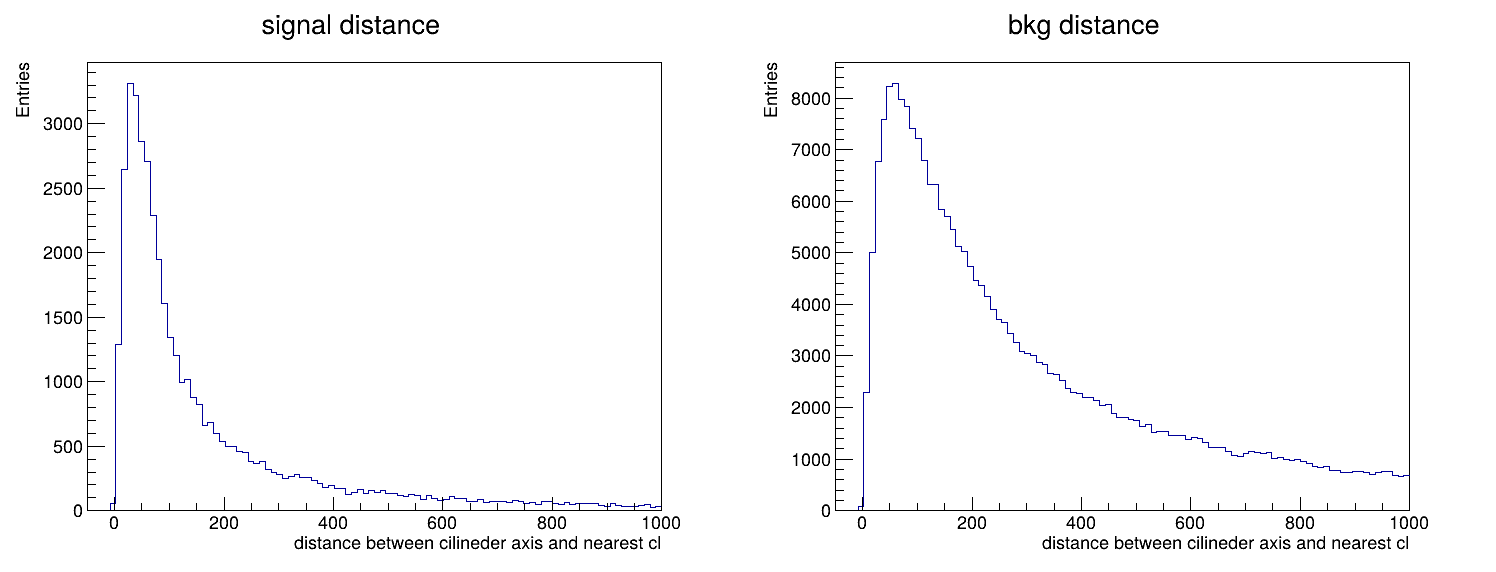

In [12]:
#ECAL distance

c = TCanvas("c", " ", 1500, 600)
ROOT.gStyle.SetOptStat(0)
c.Divide(2,1)

#max = 10000
#min = -10000

df_sel = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1")
sig = df_sel.Filter("true_flag == 1").Histo1D(("sig", " signal distance  ", 100, -50, 1000),"distance_ecalpoint")
bkg = df_sel.Filter("true_flag == 0").Histo1D(("bkg", "bkg distance   ", 100, -50, 1000),"distance_ecalpoint")



ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)

c.cd(1)
sig.GetXaxis().SetTitle("distance between cilineder axis and nearest cl")
sig.GetYaxis().SetTitle("Entries")
sig.Draw()


c.cd(2)
bkg.GetXaxis().SetTitle("distance between cilineder axis and nearest cl")
bkg.GetYaxis().SetTitle("Entries")
bkg.Draw("")


c.Draw()

In [ ]:
c = TCanvas("c", " ", 600, 600)
ROOT.gStyle.SetOptStat(0)


ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)

sig.GetXaxis().SetTitle("distance between cilineder axis and nearest cl")
sig.GetYaxis().SetTitle("Entries")
sig.SetLineColor(kRed)


bkg.GetXaxis().SetTitle("distance between cilineder axis and nearest cl")
bkg.GetYaxis().SetTitle("Entries")
bkg.Draw("")
sig.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file n_space.pdf has been created
Info in <TCanvas::Print>: png file n_space.png has been created


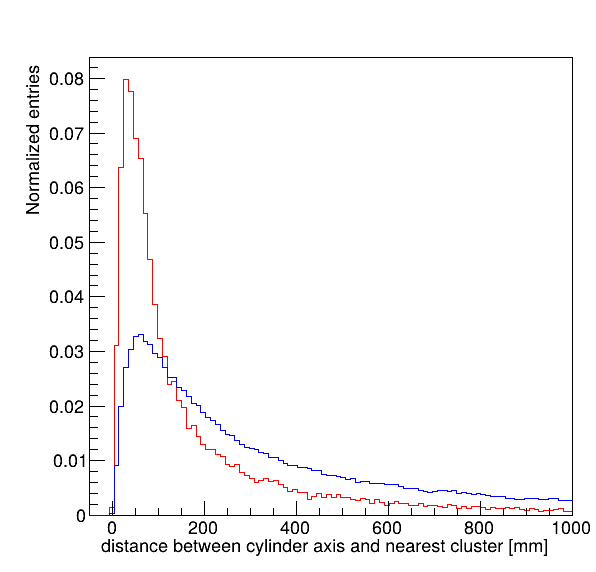

In [14]:
cN = TCanvas("c", " ", 600, 600)
ROOT.gStyle.SetOptStat(0)

ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)

sig2 = df_sel.Filter("true_flag == 1 && distance_ecalpoint > 0.0").Histo1D(("sig", "  ", 100, -50, 1000),"distance_ecalpoint")
bkg2 = df_sel.Filter("true_flag == 0 && distance_ecalpoint > 0.0").Histo1D(("bkg", "  ", 100, -50, 1000),"distance_ecalpoint")

# Imposta titoli e colori
sig2.GetXaxis().SetTitle("distance between cylinder axis and nearest cluster [mm]")
sig2.GetYaxis().SetTitle("Normalized entries")
sig2.SetLineColor(ROOT.kRed)

bkg2.GetXaxis().SetTitle("distance between cylinder axis and nearest cluster [mm]")
bkg2.GetYaxis().SetTitle("Normalized entries")
bkg2.SetLineColor(ROOT.kBlue)

  
sig2.DrawNormalized("")
bkg2.DrawNormalized("SAME")

cN.Draw()
cN.SaveAs("n_space.pdf")
cN.SaveAs("n_space.png")

In [ ]:
number_f = df_ECAL.Filter("true_flag == 1 && distance_ecalpoint > 0.0 && distance_ecalpoint < 70.0").Count().GetValue()
number_tot = df_ECAL.Filter("true_flag == 1 && distance_ecalpoint > 0.0").Count().GetValue()

print(number_f/number_tot)

0.3469939367375265


In [ ]:
number_f = df_ECAL.Filter("true_flag == 0 && distance_ecalpoint > 0.0 && distance_ecalpoint < 70").Count().GetValue()
number_tot = df_ECAL.Filter("true_flag == 0 && distance_ecalpoint > 0.0").Count().GetValue()

print(number_f/number_tot)

0.15554885715078948


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


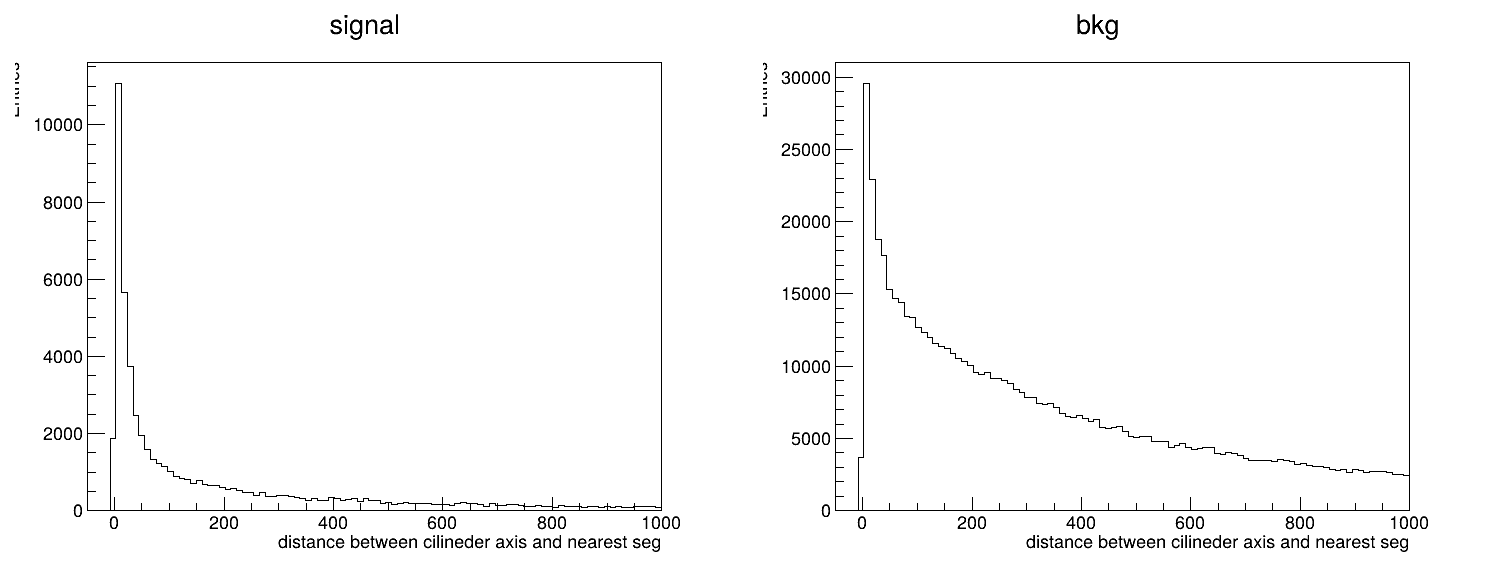

In [72]:
c = TCanvas("c", " ", 1500, 600)
ROOT.gStyle.SetOptStat(0)
c.Divide(2,1)

#max = 10000
#min = -10000


sigSEG = df_ECAL.Filter("true_flag == 1").Histo1D(("sigSEG", " signal ", 100, -50, 1000),"distance_segpoint")
bkgSEG = df_ECAL.Filter("true_flag == 0").Histo1D(("bkgSEG", "bkg  ", 100, -50, 1000),"distance_segpoint")



ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)

c.cd(1)
sigSEG.GetXaxis().SetTitle("distance between cilineder axis and nearest seg")
sigSEG.GetYaxis().SetTitle("Entries")
sigSEG.Draw()


c.cd(2)
bkgSEG.GetXaxis().SetTitle("distance between cilineder axis and nearest seg")
bkgSEG.GetYaxis().SetTitle("Entries")
bkgSEG.Draw("")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


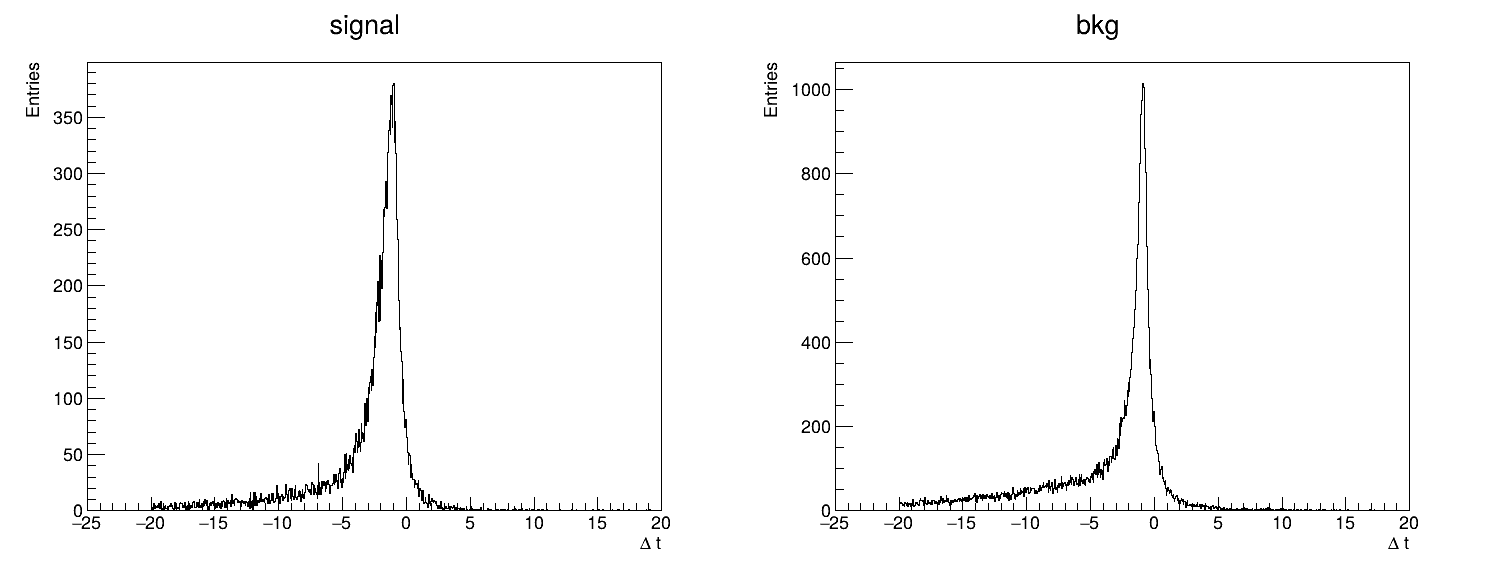

In [ ]:
c = TCanvas("c", " ", 600, 600)
ROOT.gStyle.SetOptStat(0)


ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)

sigSEG.GetXaxis().SetTitle("distance between cilineder axis and nearest cluster ")
sigSEG.GetYaxis().SetTitle("Entries")
sigSEG.SetLineColor(kRed)


bkgSEG.GetXaxis().SetTitle("distance between cilineder axis and nearest cluster ")
bkgSEG.GetYaxis().SetTitle("Entries")
bkgSEG.Draw("")
sigSEG.Draw("SAME")

c.Draw()

In [ ]:
number_f = df_sel.Filter("true_flag == 1 && distance_segpoint > 0.0 && distance_segpoint < 25.0").Count().GetValue()
number_tot = df_sel.Filter("true_flag == 1 && distance_segpoint > 0.0").Count().GetValue()

print(number_f/number_tot)

0.3466186680380561


In [ ]:
number_f = df_ECAL.Filter("true_flag == 1 && distance_segpoint > 0.0 && distance_segpoint < 25.0").Count().GetValue()
number_tot = df_ECAL.Filter("true_flag == 1 && distance_segpoint > 0.0").Count().GetValue()

print(number_f/number_tot)

0.30822178278065104


In [ ]:
number_f = df_ECAL.Filter("true_flag == 0 && distance_segpoint > 0.0 && distance_segpoint < 25.0").Count().GetValue()
number_tot = df_ECAL.Filter("true_flag == 0 && distance_segpoint > 0.0").Count().GetValue()

print(number_f/number_tot)

0.06781149618465458


In [ ]:
# df_space = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && space_flag == 1")

# evt_tot = [
#     df.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]
# evt_vol = [
#     df_vol.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]
# evt_reco = [
#     df_reco.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]

# evt_track = [
#     df_one_track.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]
# evt_space= [
#     df_space.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]

# # Calcolo percentuali
# print(f"{'Category':<10}{'Total':<10}{'Volume':<10}{'Removed (%)':<15}{'Good Reco':<15}{'Removed (%)':<15}{'1 track':<12} {'Removed (%)':<15}{'n space':<15}{'Removed (%)':<12}")
# print("-" * 100)

# for i in range(6):
#     tot = evt_tot[i]
#     vol = evt_vol[i]
#     reco = evt_reco[i]
#     one = evt_track[i]
#     space = evt_space[i]
#     perc_removed1 = 0 if tot == 0 else (tot - vol) / tot * 100
#     perc_removed2 = 0 if tot == 0 else (vol - reco) / vol * 100
#     perc_removed3 = 0 if tot == 0 else (reco - one) / reco * 100
#     perc_removed4 = 0 if tot == 0 else (one - space) / one * 100
    
#     print(f"{i:<10} {tot:<10}{vol:<10}{perc_removed1:<15.2f}{reco:<15}{perc_removed2:<15.2f}{one:<12} {perc_removed3:<15.2f}{space:<15} {perc_removed4:<12.2f}")

Category  Total     Volume    Removed (%)    Good Reco      Removed (%)    1 track      Removed (%)    n space        Removed (%) 
----------------------------------------------------------------------------------------------------
0          757655    569621    24.82          357148         37.30          152817       57.21          30271           80.19       
1          50378     50378     0.00           40718          19.18          40718        0.00           9176            77.46       
2          122029    122029    0.00           100388         17.73          86206        14.13          6813            92.10       
3          43345     43345     0.00           34933          19.41          11223        67.87          1502            86.62       
4          23728     23728     0.00           19608          17.36          16434        16.19          1138            93.08       
5          1865      1865      0.00           707            62.09          350          50.50         

In [ ]:
# df_space = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1 &&  space_flag == 1")

# evt_tot = [
#     df.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]
# evt_vol = [
#     df_vol.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]
# evt_reco = [
#     df_reco.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]

# evt_track = [
#     df_one_track.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]
# evt_space= [
#     df_space.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]

# # Calcolo percentuali
# print(f"{'Category':<10}{'Total':<10}{'Volume':<10}{'Removed (%)':<15}{'Good Reco':<15}{'Removed (%)':<15}{'1 track':<12} {'Removed (%)':<15}{'n space':<15}{'Removed (%)':<12}")
# print("-" * 100)

# for i in range(6):
#     tot = evt_tot[i]
#     vol = evt_vol[i]
#     reco = evt_reco[i]
#     one = evt_track[i]
#     space = evt_space[i]
#     perc_removed1 = 0 if tot == 0 else (tot - vol) / tot * 100
#     perc_removed2 = 0 if tot == 0 else (vol - reco) / vol * 100
#     perc_removed3 = 0 if tot == 0 else (reco - one) / reco * 100
#     perc_removed4 = 0 if tot == 0 else (one - space) / one * 100
    
#     print(f"{i:<10} {tot:<10}{vol:<10}{perc_removed1:<15.2f}{reco:<15}{perc_removed2:<15.2f}{one:<12} {perc_removed3:<15.2f}{space:<15} {perc_removed4:<12.2f}")

Info in <TCanvas::Print>: pdf file space_cut.pdf has been created
Info in <TCanvas::Print>: png file space_cut.png has been created


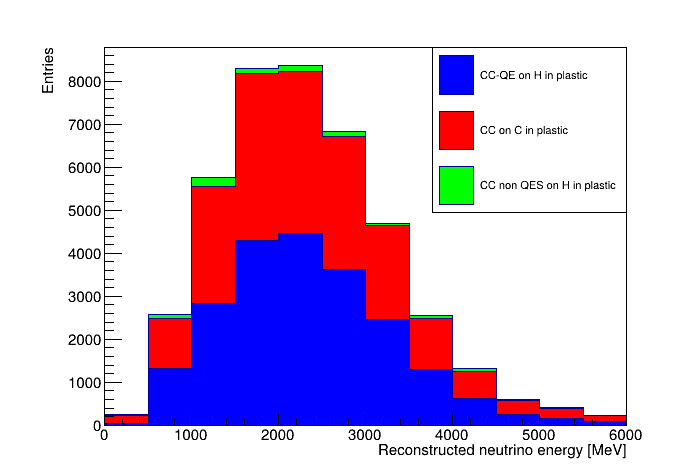

In [12]:
nbin = 12

df_space = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1")

df_plastic = df_space.Filter('Where_int == "C3H6"')

hist_1 = df_plastic.Filter('target == "tgt:1000010010" && st_proc_type == "proc:Weak[CC],QES"').Histo1D(("hist_1", "", nbin, 0, 6000),"nu_Ereco")
hist_2 = df_plastic.Filter('target == "tgt:1000060120"').Histo1D(("hist_2", "", nbin, 0, 6000),"nu_Ereco")
hist_3 = df_plastic.Filter('target == "tgt:1000010010" && st_proc_type != "proc:Weak[CC],QES"').Histo1D(("hist_2", "", nbin, 0, 6000),"nu_Ereco")


# hist_4 = df_TIME.Filter("Evt_cat == 4").Histo1D(("hist_4", "", nbin, 0, 10000),"Enu")
# hist_0 = df_TIME.Filter('Evt_cat == 0 && target != "tgt:1000010010" && target != "tgt:1000060120"').Histo1D(("hist_0", "", nbin, 0, 10000),"Enu")

# hist_6 = df_TIME.Filter('Evt_cat == 0 && target == "tgt:1000010010"')
# hist_7 = df_TIME.Filter('Evt_cat == 0 && target == "tgt:1000060120"')

hist_1.SetFillColor(ROOT.kBlue)
hist_2.SetFillColor(ROOT.kRed)
hist_3.SetFillColor(ROOT.kGreen)
# hist_0.SetFillColor(ROOT.kGreen)
# hist_6.SetFillColor(ROOT.kBlue +1 )
# hist_7.SetFillColor(ROOT.kRed + 2 )


stack = ROOT.THStack("stack", " ")
stack.Add(hist_1.GetPtr())
stack.Add(hist_2.GetPtr())
stack.Add(hist_3.GetPtr())

# stack.Add(hist_0.GetPtr())
# stack.Add(hist_6.GetPtr())
# stack.Add(hist_7.GetPtr())

c = ROOT.TCanvas()
c.SetLeftMargin(0.15)

stack.Draw("HIST")
stack.GetXaxis().SetTitle("Reconstructed neutrino energy [MeV]")
stack.GetYaxis().SetTitle("Entries")

legend = ROOT.TLegend(0.62, 0.55, 0.90, 0.90)
#legend = ROOT.TLegend(0.65, 0.6, 0.93, 0.93)

legend.AddEntry(hist_1.GetPtr(), "CC-QE on H in plastic", "f")
legend.AddEntry(hist_2.GetPtr(), "CC on C in plastic", "f")
legend.AddEntry(hist_3.GetPtr(), "CC non QES on H in plastic", "f")

# legend.AddEntry(hist_6.GetPtr(), "evt")
# legend.AddEntry(hist_0.GetPtr(), "background", "f")

legend.Draw()

c.Draw()

# f_out.cd()

# hist_1S.GetValue().Write()
# hist_2S.GetValue().Write()
# hist_3S.GetValue().Write()
# stackS.GetValue().Write()
c.SaveAs("space_cut.pdf")
c.SaveAs("space_cut.png")


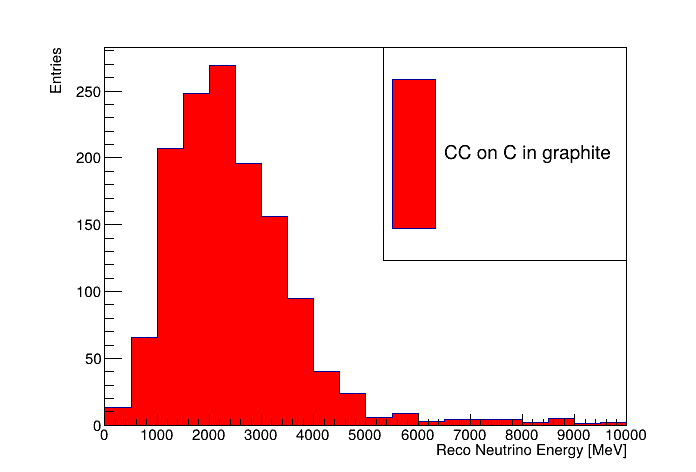

In [ ]:
nbin = 20

#df_space = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1")

df_graf = df_space.Filter('Where_int == "Graphite"')

#hist_1 = df_graf.Filter('target == "tgt:1000010010" && st_proc_type == "proc:Weak[CC],QES"').Histo1D(("hist_1", "", nbin, 0, 10000),"nu_Ereco")
hist_2 = df_graf.Filter('target == "tgt:1000060120"').Histo1D(("hist_2", "", nbin, 0, 10000),"nu_Ereco")

#hist_3 = df_plastic.Filter('target == "tgt:1000010010" && st_proc_type != "proc:Weak[CC],QES"').Histo1D(("hist_2", "", nbin, 0, 10000),"nu_Ereco")


# hist_4 = df_TIME.Filter("Evt_cat == 4").Histo1D(("hist_4", "", nbin, 0, 10000),"Enu")
# hist_0 = df_TIME.Filter('Evt_cat == 0 && target != "tgt:1000010010" && target != "tgt:1000060120"').Histo1D(("hist_0", "", nbin, 0, 10000),"Enu")

# hist_6 = df_TIME.Filter('Evt_cat == 0 && target == "tgt:1000010010"')
# hist_7 = df_TIME.Filter('Evt_cat == 0 && target == "tgt:1000060120"')

#hist_1.SetFillColor(ROOT.kBlue)
hist_2.SetFillColor(ROOT.kRed)
#hist_3.SetFillColor(ROOT.kGreen)
# hist_0.SetFillColor(ROOT.kGreen)
# hist_6.SetFillColor(ROOT.kBlue +1 )
# hist_7.SetFillColor(ROOT.kRed + 2 )


stack = ROOT.THStack("stack", " ")
#stack.Add(hist_1.GetPtr())
stack.Add(hist_2.GetPtr())
#stack.Add(hist_3.GetPtr())

# stack.Add(hist_0.GetPtr())
# stack.Add(hist_6.GetPtr())
# stack.Add(hist_7.GetPtr())

c = ROOT.TCanvas()
c.SetLeftMargin(0.15)

stack.Draw("HIST")
stack.GetXaxis().SetTitle("Reco Neutrino Energy [MeV]")
stack.GetYaxis().SetTitle("Entries")

legend = ROOT.TLegend(0.55,0.45,0.9,0.9)
#legend = ROOT.TLegend(0.65, 0.6, 0.93, 0.93)

#legend.AddEntry(hist_1.GetPtr(), "CC-QE on H in plastic", "f")
legend.AddEntry(hist_2.GetPtr(), "CC on C in graphite", "f")
#legend.AddEntry(hist_3.GetPtr(), "CC non QES on H in plastic", "f")

# legend.AddEntry(hist_6.GetPtr(), "evt")
# legend.AddEntry(hist_0.GetPtr(), "background", "f")

legend.Draw()

c.Draw()

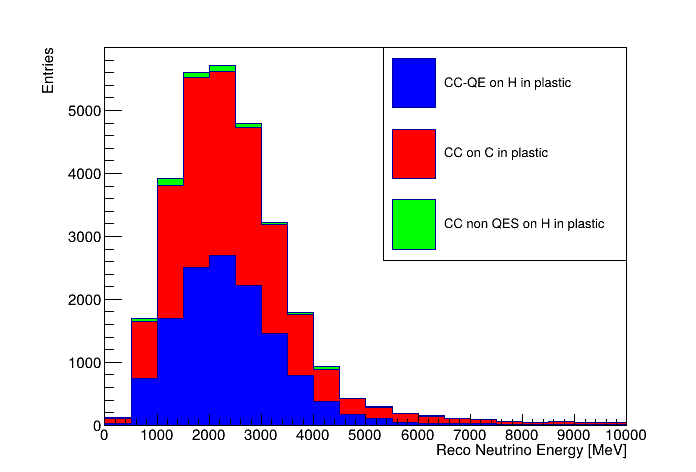

In [ ]:
nbin = 20

df_spaceTRUE = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1 && spaceTRUE_flag == 1")

df_plasticTRUE = df_spaceTRUE.Filter('Where_int == "C3H6"')

hist_1 = df_plasticTRUE.Filter('target == "tgt:1000010010" && st_proc_type == "proc:Weak[CC],QES"').Histo1D(("hist_1", "", nbin, 0, 10000),"nu_Ereco")
hist_2 = df_plasticTRUE.Filter('target == "tgt:1000060120"').Histo1D(("hist_2", "", nbin, 0, 10000),"nu_Ereco")
hist_3 = df_plasticTRUE.Filter('target == "tgt:1000010010" && st_proc_type != "proc:Weak[CC],QES"').Histo1D(("hist_2", "", nbin, 0, 10000),"nu_Ereco")


# hist_4 = df_TIME.Filter("Evt_cat == 4").Histo1D(("hist_4", "", nbin, 0, 10000),"Enu")
# hist_0 = df_TIME.Filter('Evt_cat == 0 && target != "tgt:1000010010" && target != "tgt:1000060120"').Histo1D(("hist_0", "", nbin, 0, 10000),"Enu")

# hist_6 = df_TIME.Filter('Evt_cat == 0 && target == "tgt:1000010010"')
# hist_7 = df_TIME.Filter('Evt_cat == 0 && target == "tgt:1000060120"')

hist_1.SetFillColor(ROOT.kBlue)
hist_2.SetFillColor(ROOT.kRed)
hist_3.SetFillColor(ROOT.kGreen)
# hist_0.SetFillColor(ROOT.kGreen)
# hist_6.SetFillColor(ROOT.kBlue +1 )
# hist_7.SetFillColor(ROOT.kRed + 2 )


stack = ROOT.THStack("stack", " ")
stack.Add(hist_1.GetPtr())
stack.Add(hist_2.GetPtr())
stack.Add(hist_3.GetPtr())

# stack.Add(hist_0.GetPtr())
# stack.Add(hist_6.GetPtr())
# stack.Add(hist_7.GetPtr())

c = ROOT.TCanvas()
c.SetLeftMargin(0.15)

stack.Draw("HIST")
stack.GetXaxis().SetTitle("Reco Neutrino Energy [MeV]")
stack.GetYaxis().SetTitle("Entries")

legend = ROOT.TLegend(0.55,0.45,0.9,0.9)
#legend = ROOT.TLegend(0.65, 0.6, 0.93, 0.93)

legend.AddEntry(hist_1.GetPtr(), "CC-QE on H in plastic", "f")
legend.AddEntry(hist_2.GetPtr(), "CC on C in plastic", "f")
legend.AddEntry(hist_3.GetPtr(), "CC non QES on H in plastic", "f")

# legend.AddEntry(hist_6.GetPtr(), "evt")
# legend.AddEntry(hist_0.GetPtr(), "background", "f")

legend.Draw()

c.Draw()

In [ ]:
# ROOT.gInterpreter.Declare("""

# ROOT::VecOps::RVec<double> Predicted_hit(const double n_px_pred, const double n_py_pred, const double n_pz_pred, const double x0, const double y0, const double z0){
#     // ECAL dimensions (mm)
#     const double r_out = 2230.0;
#     const double r_in  = 2000.0;
#     const double x_min = -2150.0;
#     const double x_max = 2150.0;

#     // Cylinder center
#     const double x_c = 0.0;
#     const double y_c = -2384.7300;
#     const double z_c = 23910.000;

#     // Compute momentum magnitude
#     double n_mom = TMath::Sqrt(n_px_pred*n_px_pred + n_py_pred*n_py_pred + n_pz_pred*n_pz_pred);
#     if (n_mom == 0.0)
#         return {0.0, 0.0, 0.0, 0.0, 0.0, 0.0};

#     // Normalize direction
#     double nx = n_px_pred / n_mom;
#     double ny = n_py_pred / n_mom;
#     double nz = n_pz_pred / n_mom;

#     std::cout << "-- -- -- -- --" << std::endl;
                          
#     //lambda for intersection
#     auto intersect_cylinder = [&](double r) {
#         // Shift coordinates so cylinder is centered at (x_c, y_c, z_c)
#         double y_rel = y0 - y_c;
#         double z_rel = z0 - z_c;

#         double A = ny*ny + nz*nz;
#         double B = 2.0 * (y_rel*ny + z_rel*nz);
#         double C = y_rel*y_rel + z_rel*z_rel - r*r;
#         double D = B*B - 4*A*C;

#         double end_t = (x_max - x0)/nx; 
#         double end_t2 = (x_min - x0)/nx; 
        

#         if (D < 0 || A == 0){
#             std::cout << "D = "<<  D << std::endl; 
#             return std::make_pair(false, std::vector<double>{});
#                           }     

#         double sqrtD = TMath::Sqrt(D);
#         double t1 = (-B + sqrtD) / (2*A);
#         double t2 = (-B - sqrtD) / (2*A);

#         std::vector<double> ts;
#         if (t1 > 0) { std::cout << " t1 maggiore di 0" << std::endl;
#                       ts.push_back(t1);}

#         if (t2 > 0){ std::cout << " t2 maggiore di 0" << std::endl;
#                      ts.push_back(t2);}

#         if (ts.empty()){
#             std::cout << "ts è vuoto" << std::endl;
#             return std::make_pair(false, std::vector<double>{});
#                           }

#         double t = *std::min_element(ts.begin(), ts.end());
#         //double t = 0.0 ;
#         double xi = x0 + t*nx;
#         double yi = y0 + t*ny;
#         double zi = z0 + t*nz;
                          
        
#         std::cout << "end_t:  "<< end_t  << std::endl;
#         std::cout << "end_t2:  "<< end_t2  << std::endl;
#         std::cout << "t:  "<< t  << std::endl;
                          
#         auto sol_radius = TMath::Sqrt((yi-y_c)*(yi-y_c)+(zi-z_c)*(zi-z_c));
                          
#         std::cout << "sol_radius: "<<sol_radius << std::endl;
#         // Check x boundaries (relative to cylinder center)
#         double x_rel = xi - x_c;
#         //if (x_rel < x_min || x_rel > x_max){
#         //    std::cout << "out of boundaries" << std::endl; 
#         //    std::cout << "x_rel  " << x_rel << std::endl;  
#          //   std::cout << "x_min  " << x_min << std::endl;  
#           //  std::cout << "x_max  " << x_max << std::endl; 
        
#             return std::make_pair(false, std::vector<double>{});}

#         return std::make_pair(true, std::vector<double>{xi, yi, zi});
                          
                          
#         // Check y boundaries (relative to cylinder center)

#         double y_min = y_c - r_in;
#         double y_max = y_c + r_in;
                          
#         //if (yi < y_min || yi > y_max){
#           //  std::cout << "out of boundaries" << std::endl; 
#           //  std::cout << "yi  " << yi << std::endl;  
#           //  std::cout << "y_min  " << y_min << std::endl;  
#           //  std::cout << "y_max  " << y_max << std::endl; 
#           //  return std::make_pair(false, std::vector<double>{});}

#         //return std::make_pair(true, std::vector<double>{xi, yi, zi});

                          

#         // Check z boundaries (relative to cylinder center)
#         double z_min = z_c - r_in;
#         double z_max = z_c + r_in;
                          
#         //if (zi < z_min || zi > z_max){
#           //  std::cout << "out of boundaries" << std::endl; 
#         //    std::cout << "zi  " << zi << std::endl;  
#         //    std::cout << "z_min  " << z_min << std::endl;  
#         //    std::cout << "z_max  " << z_max << std::endl; 
#         //    std::cout << "end_t:  "<< end_t  << std::endl;
#         //    std::cout << "end_t2:  "<< end_t2  << std::endl;
#          //   std::cout << "t:  "<< t  << std::endl;
#           //  return std::make_pair(false, std::vector<double>{});}

#         //return std::make_pair(true, std::vector<double>{xi, yi, zi});

#     };
    


#     auto inner = intersect_cylinder(r_in);
#     auto outer = intersect_cylinder(r_out);

#    // if (!inner.first) inner.second = {-99.0, -99.0, -99.0};
#    // if (!outer.first) outer.second = {0.000, 0.000, 0.000};

#     ROOT::VecOps::RVec<double> result;
#     result.insert(result.end(), inner.second.begin(), inner.second.end());
#     result.insert(result.end(), outer.second.begin(), outer.second.end());

                          
#     return result;
# }
                          
#                                                                               """)

# df_prova = df.Define("hit_pred2", "Predicted_hit( n_px_pred, n_py_pred, n_pz_pred, vertex_x, vertex_y, vertex_z)")

In [ ]:
# df_space = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && space_flag == 1")
# df_vol = df_flag.Filter("volume_flag == 1")
# df_reco = df_flag.Filter("volume_flag == 1 && reco_flag == 1")
# df_one_track = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1")

# evt_tot = [
#     df.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]
# evt_vol = [
#     df_vol.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]
# evt_reco = [
#     df_reco.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]

# evt_track = [
#     df_one_track.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]
# evt_space= [
#     df_space.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
# ]

# # Calcolo percentuali
# print(f"{'Category':<10}{'Total':<10}{'Volume':<10}{'Removed (%)':<15}{'Good Reco':<15}{'Removed (%)':<15}{'1 track':<12} {'Removed (%)':<15}{'n space':<15}{'Removed (%)':<12}")
# print("-" * 100)

# for i in range(6):
#     tot = evt_tot[i]
#     vol = evt_vol[i]
#     reco = evt_reco[i]
#     one = evt_track[i]
#     space = evt_space[i]
#     perc_removed1 = 0 if tot == 0 else (tot - vol) / tot * 100
#     perc_removed2 = 0 if tot == 0 else (vol - reco) / vol * 100
#     perc_removed3 = 0 if tot == 0 else (reco - one) / reco * 100
#     perc_removed4 = 0 if tot == 0 else (one - space) / one * 100
    
#     print(f"{i:<10} {tot:<10}{vol:<10}{perc_removed1:<15.2f}{reco:<15}{perc_removed2:<15.2f}{one:<12} {perc_removed3:<15.2f}{space:<15} {perc_removed4:<12.2f}")

In [ ]:
# ROOT.gInterpreter.Declare("""

# ROOT::VecOps::RVec<double> Predicted_hit(const double n_px_pred, const double n_py_pred, const double n_pz_pred, const double x0, const double y0, const double z0){
#     // ECAL dimensions (mm)
#     const double r_out = 2230.0;
#     const double r_in  = 2000.0;
#     const double x_min = -2150.0;
#     const double x_max = 2150.0;

#     // Cylinder center
#     const double x_c = 0.0;
#     const double y_c = -2384.7300;
#     const double z_c = 23910.000;

#     // Compute momentum magnitude
#     double n_mom = TMath::Sqrt(n_px_pred*n_px_pred + n_py_pred*n_py_pred + n_pz_pred*n_pz_pred);
#     if (n_mom == 0.0)
#         return {0.0, 0.0, 0.0, 0.0, 0.0, 0.0};

#     // Normalize direction
#     double nx = n_px_pred / n_mom;
#     double ny = n_py_pred / n_mom;
#     double nz = n_pz_pred / n_mom;
                          
#     //lambda for intersection
#     auto intersect_cylinder = [&](double r) {
#         // Shift coordinates so cylinder is centered at (x_c, y_c, z_c)
#         double y_rel = y0 - y_c;
#         double z_rel = z0 - z_c;

#         double A = ny*ny + nz*nz;
#         double B = 2.0 * (y_rel*ny + z_rel*nz);
#         double C = y_rel*y_rel + z_rel*z_rel - r*r;
#         double D = B*B - 4*A*C;
        

#         if (D < 0 || A == 0){
#             std::cout << "D = "<<  D << std::endl; 
#             return std::make_pair(false, std::vector<double>{});
#                           }     

#         double sqrtD = TMath::Sqrt(D);
#         double t1 = (-B + sqrtD) / (2*A);
#         double t2 = (-B - sqrtD) / (2*A);

#         std::vector<double> ts;
#         if (t1 > 0) { std::cout << " t1 maggiore di 0" << std::endl;
#                       ts.push_back(t1);}

#         if (t2 > 0){ std::cout << " t2 maggiore di 0" << std::endl;
#                      ts.push_back(t2);}

#         if (ts.empty()){
#             std::cout << "ts è vuoto" << std::endl;
#             return std::make_pair(false, std::vector<double>{});
#                           }

#         double t = *std::min_element(ts.begin(), ts.end());
#         //double t = 0.0 ;
#         double xi = x0 + t*nx;
#         double yi = y0 + t*ny;
#         double zi = z0 + t*nz;
                          
        
#         std::cout << "end_t:  "<< end_t  << std::endl;
#         std::cout << "end_t2:  "<< end_t2  << std::endl;
#         std::cout << "t:  "<< t  << std::endl;
                          
#         auto sol_radius = TMath::Sqrt((yi-y_c)*(yi-y_c)+(zi-z_c)*(zi-z_c));
                          
#         std::cout << "sol_radius: "<<sol_radius << std::endl;
        
                          
                          
       

#         // Check z boundaries (relative to cylinder center)
#         double z_min = z_c - r_in;
#         double z_max = z_c + r_in;
                          
#         //if (zi < z_min || zi > z_max){
#           //  std::cout << "out of boundaries" << std::endl; 
#         //    std::cout << "zi  " << zi << std::endl;  
#         //    std::cout << "z_min  " << z_min << std::endl;  
#         //    std::cout << "z_max  " << z_max << std::endl; 
#         //    std::cout << "end_t:  "<< end_t  << std::endl;
#         //    std::cout << "end_t2:  "<< end_t2  << std::endl;
#          //   std::cout << "t:  "<< t  << std::endl;
#           //  return std::make_pair(false, std::vector<double>{});}

#         return std::make_pair(true, std::vector<double>{xi, yi, zi});

#     };
    


#     auto inner = intersect_cylinder(r_in);
#     auto outer = intersect_cylinder(r_out);

#    // if (!inner.first) inner.second = {-99.0, -99.0, -99.0};
#    // if (!outer.first) outer.second = {0.000, 0.000, 0.000};

#     ROOT::VecOps::RVec<double> result;
#     result.insert(result.end(), inner.second.begin(), inner.second.end());
#     result.insert(result.end(), outer.second.begin(), outer.second.end());

                          
#     return result;
# }
                          
#                                                                               """)

# df_prova = df.Define("hit_pred2", "Predicted_hit( n_px_pred, n_py_pred, n_pz_pred, vertex_x, vertex_y, vertex_z)")

NEUTRON TIME SELECTION

In [7]:
df_time = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1 && time_flag == 1")

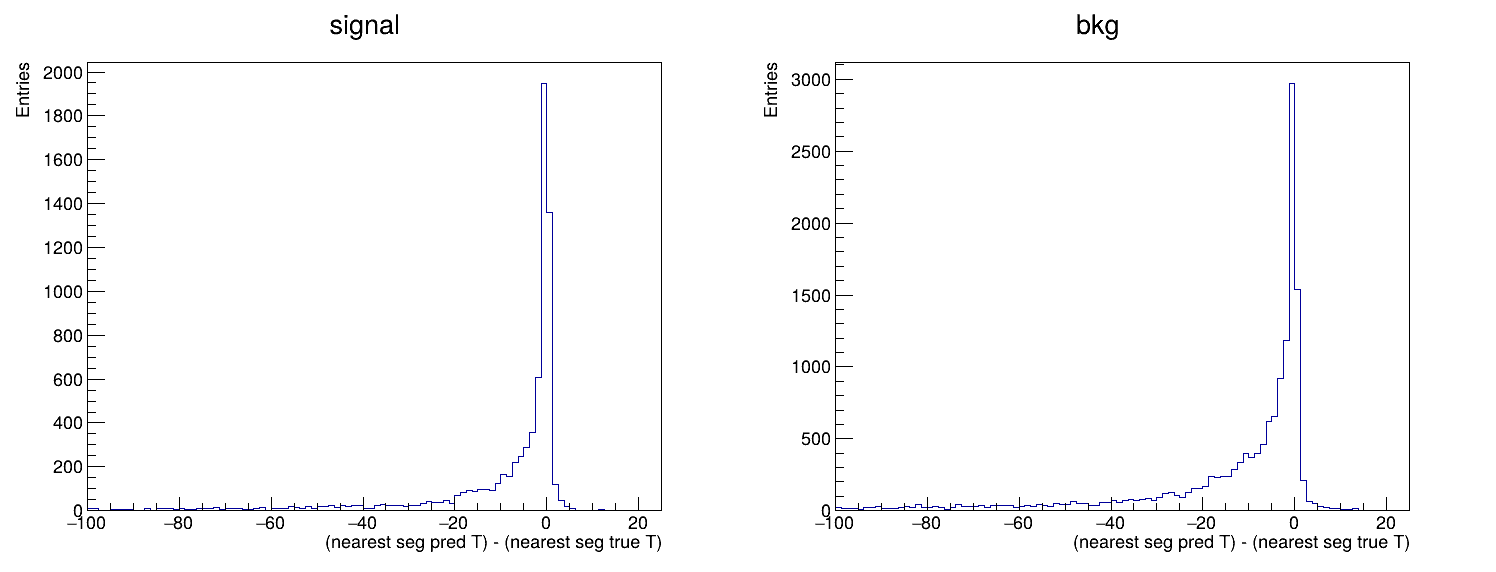

KeyboardInterrupt: 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


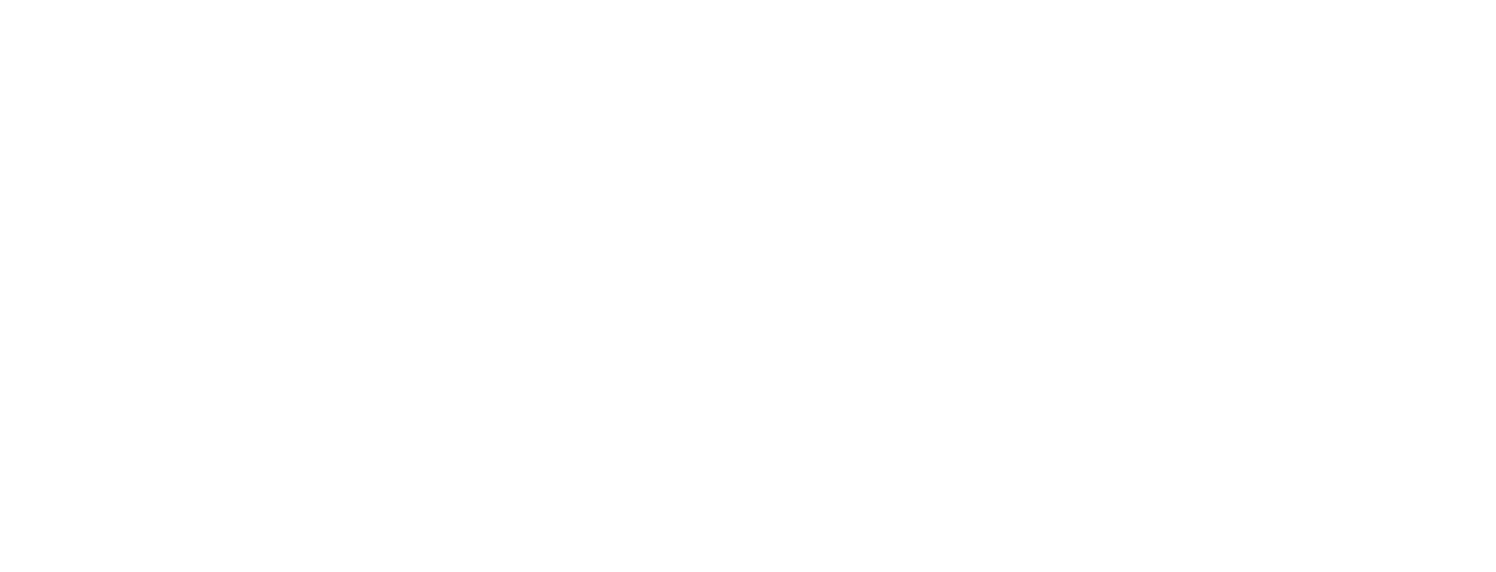

In [ ]:
c = TCanvas("c", " ", 1500, 600)
ROOT.gStyle.SetOptStat(0)
c.Divide(2,1)

#max = 10000
#min = -10000


sig_T_seg = df_time.Filter("true_flag == 1").Histo1D(("h", " signal ", 100, -100, 25),"t_res_seg")
bkg_T_seg = df_time.Filter("true_flag == 0").Histo1D(("h", "bkg  ", 100, -100, 25),"t_res_seg")



ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)

c.cd(1)
sig_T_seg.GetXaxis().SetTitle(" (nearest seg pred T) - (nearest seg true T)")
sig_T_seg.GetYaxis().SetTitle("Entries")
sig_T_seg.Draw()


c.cd(2)
bkg_T_seg.GetXaxis().SetTitle("(nearest seg pred T) - (nearest seg true T)")
bkg_T_seg.GetYaxis().SetTitle("Entries")
bkg_T_seg.Draw("")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file n_time.pdf has been created
Info in <TCanvas::Print>: png file n_time.png has been created


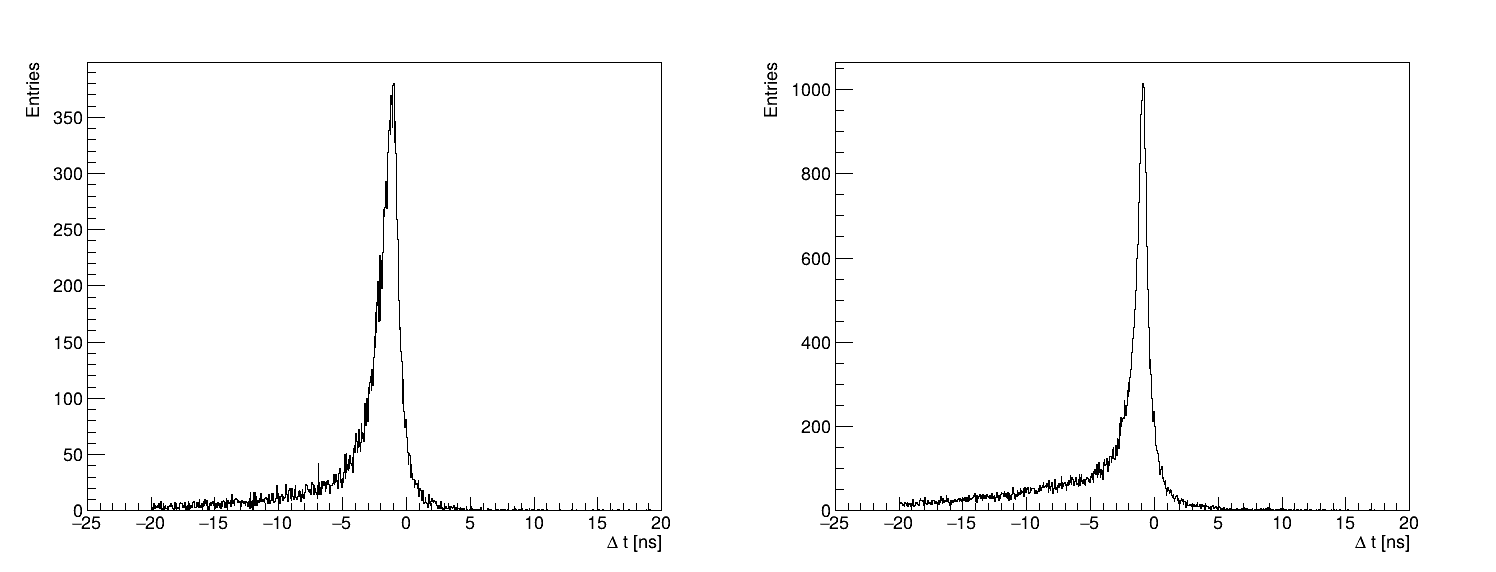

In [9]:
cT = TCanvas("c", " ", 1500, 600)
ROOT.gStyle.SetOptStat(0)
cT.Divide(2,1)

#max = 10000
#min = -10000


sig_T_ecal = df_time.Filter("true_flag == 1").Histo1D(("h", " ", 1000, -25, 20),"t_res_ecal")
bkg_T_ecal = df_time.Filter("true_flag == 0").Histo1D(("h", " ", 1000, -25, 20),"t_res_ecal")


ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.04)

sig_T_ecal.SetLineColor(ROOT.kBlack)
bkg_T_ecal.SetLineColor(ROOT.kBlack)

cT.cd(1)
sig_T_ecal.GetXaxis().SetTitle(" #Delta t [ns]")
sig_T_ecal.GetYaxis().SetTitle("Entries")
sig_T_ecal.Draw()


cT.cd(2)
bkg_T_ecal.GetXaxis().SetTitle("#Delta t [ns]")
bkg_T_ecal.GetYaxis().SetTitle("Entries")
bkg_T_ecal.Draw("")

cT.Draw()
cT.SaveAs("n_time.pdf")
cT.SaveAs("n_time.png")

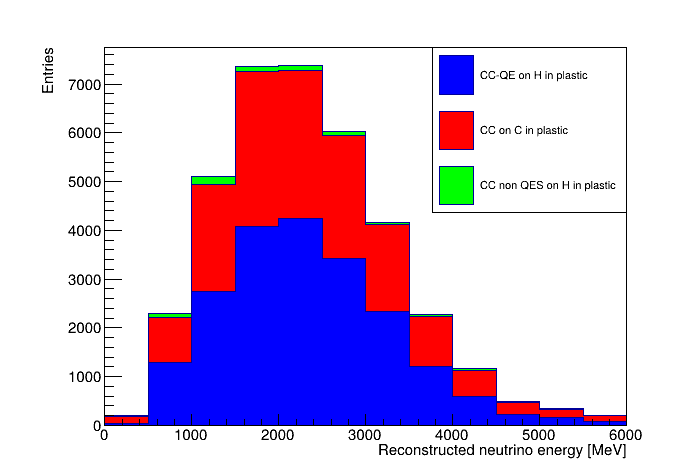

In [20]:
nbin = 12

# df_time = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1 && time_flag == 1")

df_plastic = df_time.Filter('Where_int == "C3H6"')

hist_1 = df_plastic.Filter('target == "tgt:1000010010" && st_proc_type == "proc:Weak[CC],QES"').Histo1D(("hist_1", "", nbin, 0, 6000),"nu_Ereco")
hist_2 = df_plastic.Filter('target == "tgt:1000060120"').Histo1D(("hist_2", "", nbin, 0, 6000),"nu_Ereco")
hist_3 = df_plastic.Filter('target == "tgt:1000010010" && st_proc_type != "proc:Weak[CC],QES"').Histo1D(("hist_2", "", nbin, 0, 6000),"nu_Ereco")


hist_1.SetFillColor(ROOT.kBlue)
hist_2.SetFillColor(ROOT.kRed)
hist_3.SetFillColor(ROOT.kGreen)

stack = ROOT.THStack("stack", " ")
stack.Add(hist_1.GetPtr())
stack.Add(hist_2.GetPtr())
stack.Add(hist_3.GetPtr())


c = ROOT.TCanvas()
c.SetLeftMargin(0.15)

stack.Draw("HIST")
stack.GetXaxis().SetTitle("Reconstructed neutrino energy [MeV]")
stack.GetYaxis().SetTitle("Entries")

legend = ROOT.TLegend(0.62, 0.55, 0.90, 0.90)
#legend = ROOT.TLegend(0.65, 0.6, 0.93, 0.93)

legend.AddEntry(hist_1.GetPtr(), "CC-QE on H in plastic", "f")
legend.AddEntry(hist_2.GetPtr(), "CC on C in plastic", "f")
legend.AddEntry(hist_3.GetPtr(), "CC non QES on H in plastic", "f")

# legend.AddEntry(hist_6.GetPtr(), "evt")
# legend.AddEntry(hist_0.GetPtr(), "background", "f")

legend.Draw()


# c.Draw()
# c.SaveAs("time_cut.pdf")
# c.SaveAs("time_cut.png")

In [ ]:
df_plastic.Display(["st_proc_type", "primaries_PDG", "target"]).Print()


+-------+-------------------------+---------------+----------------------+
| Row   | st_proc_type            | primaries_PDG | target               | 
+-------+-------------------------+---------------+----------------------+
| 37    | "proc:Weak[CC],QES"[17] | 2112          | "tgt:1000010010"[14] | 
|       |                         | -13           |                      | 
+-------+-------------------------+---------------+----------------------+
| 47    | "proc:Weak[CC],DIS"[17] | 111           | "tgt:1000060120"[14] | 
|       |                         | 2112          |                      | 
|       |                         | -13           |                      | 
+-------+-------------------------+---------------+----------------------+
| 113   | "proc:Weak[CC],QES"[17] | 2112          | "tgt:1000060120"[14] | 
|       |                         | -13           |                      | 
+-------+-------------------------+---------------+----------------------+
| 168   | "proc:W

In [32]:
total = df_plastic.Count().GetValue()

CCnonQEH = df_plastic.Filter('target == "tgt:1000010010" && st_proc_type != "proc:Weak[CC],QES" ').Count().GetValue() #green
CConC = df_plastic.Filter('target == "tgt:1000060120"').Count().GetValue()
CCnonQEC = df_plastic.Filter('target == "tgt:1000060120" && st_proc_type != "proc:Weak[CC],QES" ').Count().GetValue() #red
mec = df_plastic.Filter('target == "tgt:1000060120" && st_proc_type == "proc:Weak[CC],MEC" ').Count().GetValue()
dis = df_plastic.Filter('target == "tgt:1000060120" && st_proc_type == "proc:Weak[CC],DIS" ').Count().GetValue()
res = df_plastic.Filter('target == "tgt:1000060120" && st_proc_type == "proc:Weak[CC],RES" ').Count().GetValue()


print("CC non QE on H:")
print(total)
print(CCnonQEH)
print(CCnonQEH/total)

print("-------------------------")
print("CCnonQE on C")
print(CConC)
print(CCnonQEC/CConC)


print("--------------MEC-----------")
print(mec)
print(mec/CCnonQEC)

print("--------------DIS-----------")
print(dis)
print(dis/CCnonQEC)

print("--------------RES-----------")
print(res)
print(res/CCnonQEC)

CC non QE on H:
38375
812
0.021159609120521172
-------------------------
CCnonQE on C
16873
0.3000651929117525
--------------MEC-----------
1217
0.2403713213509777
--------------DIS-----------
1007
0.1988939364013431
--------------RES-----------
2839
0.5607347422476793


In [27]:
df_plastic.Filter('target == "tgt:1000010010" && st_proc_type != "proc:Weak[CC],QES"').Display(["st_proc_type", "primaries_PDG"],100).Print()

+--------+-------------------------+---------------+
| Row    | st_proc_type            | primaries_PDG | 
+--------+-------------------------+---------------+
| 4946   | "proc:Weak[CC],RES"[17] | 111           | 
|        |                         | 2112          | 
|        |                         | -13           | 
+--------+-------------------------+---------------+
| 7417   | "proc:Weak[CC],DIS"[17] | 111           | 
|        |                         | 2112          | 
|        |                         | -13           | 
+--------+-------------------------+---------------+
| 8105   | "proc:Weak[CC],RES"[17] | 111           | 
|        |                         | 2112          | 
|        |                         | -13           | 
+--------+-------------------------+---------------+
| 8613   | "proc:Weak[CC],DIS"[17] | 111           | 
|        |                         | 111           | 
|        |                         | 2112          | 
|        |                       

In [30]:
df_plastic.Filter('target == "tgt:1000060120" && st_proc_type != "proc:Weak[CC],QES"').Display(["st_proc_type", "primaries_PDG"],100).Print()

+-------+-------------------------+---------------+
| Row   | st_proc_type            | primaries_PDG | 
+-------+-------------------------+---------------+
| 47    | "proc:Weak[CC],DIS"[17] | 111           | 
|       |                         | 2112          | 
|       |                         | -13           | 
+-------+-------------------------+---------------+
| 272   | "proc:Weak[CC],MEC"[17] | 2112          | 
|       |                         | 2212          | 
|       |                         | 2112          | 
|       |                         | -13           | 
+-------+-------------------------+---------------+
| 769   | "proc:Weak[CC],RES"[17] | 111           | 
|       |                         | 2112          | 
|       |                         | -13           | 
+-------+-------------------------+---------------+
| 860   | "proc:Weak[CC],RES"[17] | 111           | 
|       |                         | -211          | 
|       |                         | 2112          |

In [8]:
df_vol =  df_flag.Filter("volume_flag == 1")
df_reco =  df_flag.Filter("volume_flag == 1 && reco_flag == 1")
df_one_track =  df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1")
df_space = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1")
df_time = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1 && time_flag == 1")

evt_tot = [
    df.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
]
evt_vol = [
    df_vol.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
]
evt_reco = [
    df_reco.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
]

evt_track = [
    df_one_track.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
]
evt_space= [
    df_space.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
]
evt_time= [
    df_time.Filter(f"Evt_cat == {i}").Count().GetValue() for i in range(6)
]

# Calcolo percentuali
print(f"{'Category':<10}{'Total':<10}{'Volume':<10}{'Removed (%)':<15}{'Good Reco':<15}{'Removed (%)':<15}{'1 track':<12} {'Removed (%)':<15}{'n space':<15}{'Removed (%)':<12}{'n time':<15}{'Removed (%)':<12}")
print("-" * 100)

for i in range(6):
    tot = evt_tot[i]
    vol = evt_vol[i]
    reco = evt_reco[i]
    one = evt_track[i]
    space = evt_space[i]
    time = evt_time[i]
    perc_removed1 = 0 if tot == 0 else (tot - vol) / tot * 100
    perc_removed2 = 0 if tot == 0 else (vol - reco) / vol * 100
    perc_removed3 = 0 if tot == 0 else (reco - one) / reco * 100
    perc_removed4 = 0 if tot == 0 else (one - space) / one * 100
    perc_removed5 = 0 if tot == 0 else (space - time) / space * 100
    
    print(f"{i:<10} {tot:<10}{vol:<10}{perc_removed1:<15.2f}{reco:<15}{perc_removed2:<15.2f}{one:<12} {perc_removed3:<15.2f}{space:<15} {perc_removed4:<12.2f}{time:<15} {perc_removed5:<12.2f}")

Category  Total     Volume    Removed (%)    Good Reco      Removed (%)    1 track      Removed (%)    n space        Removed (%) n time         Removed (%) 
----------------------------------------------------------------------------------------------------
0          1788866   1343727   24.88          842404         37.31          359062       57.38          45947           87.20       37823           17.68       
1          119429    119429    0.00           96164          19.48          96164        0.00           21789           77.34       20690           5.04        
2          288156    288156    0.00           236848         17.81          203678       14.00          14529           92.87       11810           18.71       
3          102220    102220    0.00           82233          19.55          26510        67.76          1033            96.10       812             21.39       
4          55934     55934     0.00           46234          17.34          38612        16.49   

In [ ]:
#FATTO CON NUOVE CATEGORIE, GUARDARE FUNZIONE CAT


df_vol =  df_flag.Filter("volume_flag == 1")
df_reco =  df_flag.Filter("volume_flag == 1 && reco_flag == 1")
df_one_track =  df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1")
df_space = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1")
df_time = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1 && time_flag == 1")

evt_tot = [
    df_extended.Filter(f"Cat == {i}").Count().GetValue() for i in range(6)
]
evt_vol = [
    df_vol.Filter(f"Cat == {i}").Count().GetValue() for i in range(6)
]
evt_reco = [
    df_reco.Filter(f"Cat == {i}").Count().GetValue() for i in range(6)
]

evt_track = [
    df_one_track.Filter(f"Cat == {i}").Count().GetValue() for i in range(6)
]
evt_space= [
    df_space.Filter(f"Cat == {i}").Count().GetValue() for i in range(6)
]
evt_time= [
    df_time.Filter(f"Cat == {i}").Count().GetValue() for i in range(6)
]

# Calcolo percentuali
print(f"{'Category':<10}{'Total':<10}{'Volume':<10}{'Removed (%)':<15}{'Good Reco':<15}{'Removed (%)':<15}{'1 track':<12} {'Removed (%)':<15}{'n space':<15}{'Removed (%)':<12}{'n time':<15}{'Removed (%)':<12}")
print("-" * 100)

for i in range(6):
    tot = evt_tot[i]
    vol = evt_vol[i]
    reco = evt_reco[i]
    one = evt_track[i]
    space = evt_space[i]
    time = evt_time[i]
    perc_removed1 = 0 if tot == 0 else (tot - vol) / tot * 100
    perc_removed2 = 0 if tot == 0 else (vol - reco) / vol * 100
    perc_removed3 = 0 if tot == 0 else (reco - one) / reco * 100
    perc_removed4 = 0 if tot == 0 else (one - space) / one * 100
    perc_removed5 = 0 if tot == 0 else (space - time) / space * 100
    
    print(f"{i:<10} {tot:<10}{vol:<10}{perc_removed1:<15.2f}{reco:<15}{perc_removed2:<15.2f}{one:<12} {perc_removed3:<15.2f}{space:<15} {perc_removed4:<12.2f}{time:<15} {perc_removed5:<12.2f}")

Category  Total     Volume    Removed (%)    Good Reco      Removed (%)    1 track      Removed (%)    n space        Removed (%) n time         Removed (%) 
----------------------------------------------------------------------------------------------------
0          997172    552033    44.64          192935         65.05          134443       30.32          38711           71.21       31950           17.47       
1          119429    119429    0.00           96164          19.48          96164        0.00           21789           77.34       20690           5.04        
2          950443    950443    0.00           779798         17.95          390988       49.86          20789           94.68       16873           18.84       
3          102220    102220    0.00           82233          19.55          26510        67.76          1033            96.10       812             21.39       
4          185341    185341    0.00           152753         17.58          75921        50.30   

In [6]:

df_vol =  df_flag.Filter("volume_flag == 1")
df_reco =  df_flag.Filter("volume_flag == 1 && reco_flag == 1")
df_one_track =  df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1")
df_space = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1")
df_time = df_flag.Filter("volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1 && time_flag == 1")

evt_tot = [
    df_extended.Filter(f"Cat == {i}").Count().GetValue() for i in range(6)
]
evt_vol = [
    df_vol.Filter(f"Cat == {i}").Count().GetValue() for i in range(6)
]
evt_reco = [
    df_reco.Filter(f"Cat == {i}").Count().GetValue() for i in range(6)
]

evt_track = [
    df_one_track.Filter(f"Cat == {i}").Count().GetValue() for i in range(6)
]
evt_space= [
    df_space.Filter(f"Cat == {i}").Count().GetValue() for i in range(6)
]
evt_time= [
    df_time.Filter(f"Cat == {i}").Count().GetValue() for i in range(6)
]

# Calcolo percentuali
print(f"{'Category':<10}{'Total':<10}{'Volume':<10}{'Removed (%)':<15}{'Good Reco':<15}{'Removed (%)':<15}{'1 track':<12} {'Removed (%)':<15}{'n space':<15}{'Removed (%)':<12}{'n time':<15}{'Removed (%)':<12}")
print("-" * 100)

for i in range(6):
    tot = evt_tot[i]
    vol = evt_vol[i]
    reco = evt_reco[i]
    one = evt_track[i]
    space = evt_space[i]
    time = evt_time[i]
    perc_removed1 = 0 if tot == 0 else (tot - vol) / tot * 100
    perc_removed2 = 0 if tot == 0 else (vol - reco) / vol * 100
    perc_removed3 = 0 if tot == 0 else (reco - one) / reco * 100
    perc_removed4 = 0 if tot == 0 else (one - space) / one * 100
    perc_removed5 = 0 if tot == 0 else (space - time) / space * 100
    
    print(f"{i:<10} {tot:<10}{vol:<10}{perc_removed1:<15.2f}{reco:<15}{perc_removed2:<15.2f}{one:<12} {perc_removed3:<15.2f}{space:<15} {perc_removed4:<12.2f}{time:<15} {perc_removed5:<12.2f}")

Category  Total     Volume    Removed (%)    Good Reco      Removed (%)    1 track      Removed (%)    n space        Removed (%) n time         Removed (%) 
----------------------------------------------------------------------------------------------------
0          0         0         0.00           0              0.00           0            0.00           0               0.00        0               0.00        
1          119429    119429    0.00           96164          19.48          96164        0.00           21789           77.34       20690           5.04        
2          950443    950443    0.00           779798         17.95          390988       49.86          20789           94.68       16873           18.84       
3          102220    102220    0.00           82233          19.55          26510        67.76          1033            96.10       812             21.39       
4          185341    185341    0.00           152753         17.58          75921        50.30   

Info in <TCanvas::Print>: pdf file hist_cut.pdf has been created
Info in <TCanvas::Print>: png file hist_cut.png has been created


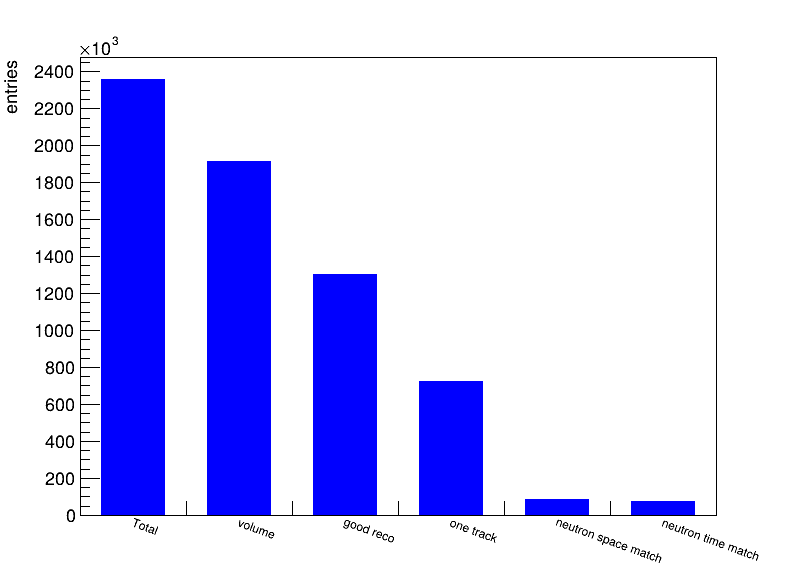

In [9]:
#CUT PLOT
N_tot = df.Count().GetValue()
N_vol = df_vol.Count().GetValue()
N_reco = df_reco.Count().GetValue()
N_track = df_one_track.Count().GetValue()
N_space = df_space.Count().GetValue()
N_time = df_time.Count().GetValue() 


labels = ["Total", "volume", "good reco", "one track", "neutron space match", "neutron time match"]
values = [N_tot, N_vol, N_reco, N_track,N_space,N_time]

n_bins = len(values)
hist_cut = ROOT.TH1F("hist_cut", " ", n_bins, 0.5, n_bins + 0.5)

for i, (label, val) in enumerate(zip(labels, values), start=1):
    hist_cut.SetBinContent(i, val)
    hist_cut.GetXaxis().SetBinLabel(i, label)

hist_cut.SetFillColor(ROOT.kBlue)
hist_cut.SetBarWidth(0.6)
hist_cut.SetBarOffset(0.2)
# hist.GetXaxis.SetTitle("selection cuts")
hist_cut.GetYaxis().SetTitle("entries")

c = ROOT.TCanvas("c", " ", 800, 600)
ROOT.gStyle.SetOptStat(0)
hist_cut.Draw("bar")
c.Draw()


# f_out.cd()
# hist_cut.GetValue().Write()
c.SaveAs("hist_cut.pdf")
c.SaveAs("hist_cut.png")

In [ ]:
# nbin = 20

# h_C_graf = df_time.Filter('Where_int == "Graphite" && target == "tgt:1000060120"').Histo1D(("h_C_graf", "h_C_graf", nbin, 0, 10000),"nu_Ereco")

# h_C_pl =  df_time.Filter('Where_int == "C3H6" && target == "tgt:1000060120"').Histo1D(("h_C_graf", "h_C_graf", nbin, 0, 10000),"nu_Ereco")
# h_C_graf.Scale(5.57)


# h_C_pl.SetLineColor(ROOT.kRed)
# h_C_graf.SetLineColor(ROOT.kBlack)


# c = ROOT.TCanvas()
# c.SetLeftMargin(0.15)
# c.Divide(1,2)


# c.cd(1)
# h_C_pl.GetXaxis().SetTitle("Reco Neutrino Energy [MeV]")
# h_C_pl.GetYaxis().SetTitle("entries")

# h_C_pl.SetFillColor(kRed)

# h_C_pl.Draw()
# h_C_graf.Draw("SAME")

# legend = ROOT.TLegend(0.55,0.45,0.9,0.9)
# #legend = ROOT.TLegend(0.65, 0.6, 0.93, 0.93)

# legend.AddEntry(h_C_pl.GetPtr(), "CC on C in plastic", "l")
# legend.AddEntry(h_C_graf.GetPtr(), "CC on C in graphite", "l")

# # legend.AddEntry(hist_6.GetPtr(), "evt")
# # legend.AddEntry(hist_0.GetPtr(), "background", "f")

# legend.Draw()

# c.cd(2)

# h_ratio = h_C_graf.Clone("h_ratio")
# h_ratio.Divide(h_C_pl)

# h_ratio.SetLineColor(ROOT.kBlue)
# h_ratio.SetTitle("Ratio Graphite/Plastic")

# h_ratio.GetYaxis().SetTitle("ratio")
# h_ratio.GetXaxis().SetTitle("Reco Neutrino Energy [MeV]")

# h_ratio.Draw()


# c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file evt_on_C.pdf has been created
Info in <TCanvas::Print>: png file evt_on_C.png has been created


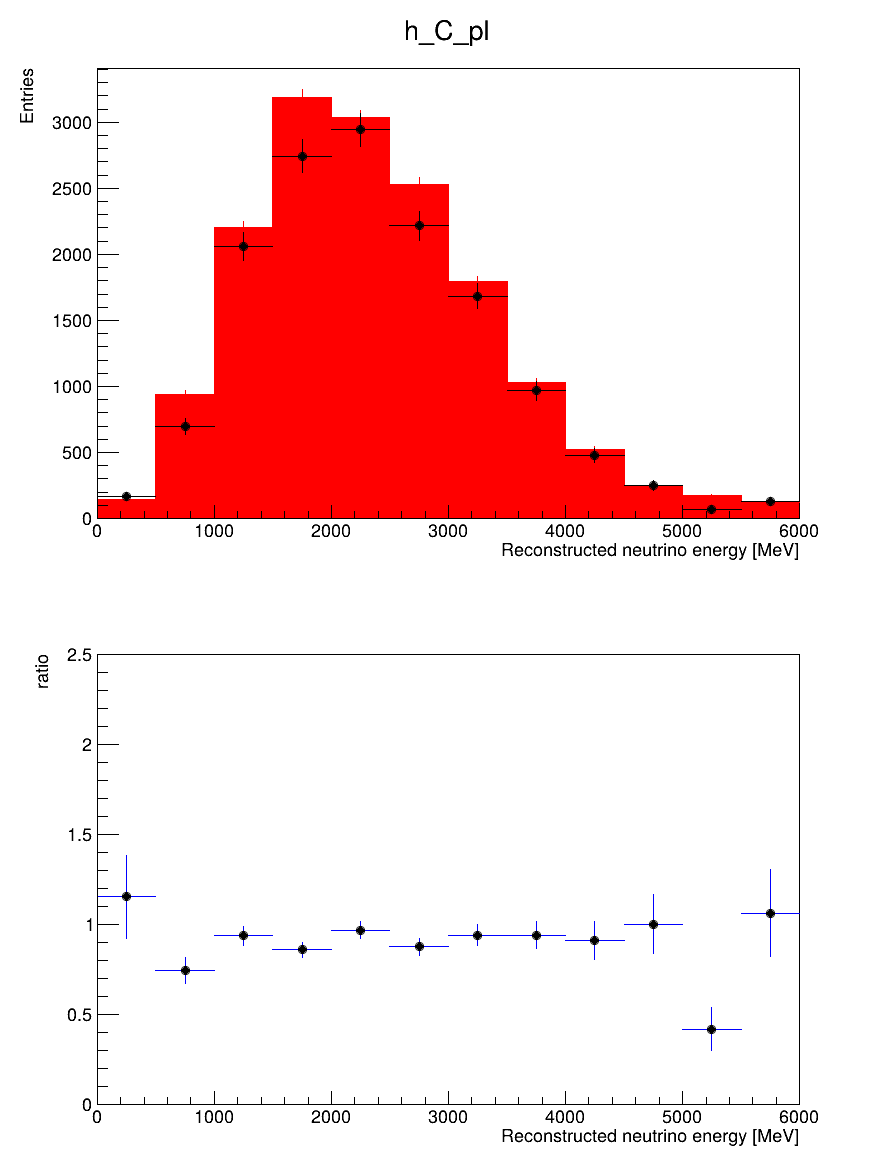

In [ ]:
nbin = 12

h_C_graf = df_time.Filter('Where_int == "Graphite" && target == "tgt:1000060120"').Histo1D(("h_C_graf", "h_C_graf", nbin, 0, 6000),"nu_Ereco")

h_C_pl = df_time.Filter('Where_int == "C3H6" && target == "tgt:1000060120"').Histo1D(("h_C_pl", "h_C_pl", nbin, 0, 6000),"nu_Ereco")


h_C_graf.GetPtr().Scale(5.25)

h_C_pl.GetPtr().SetLineColor(ROOT.kRed)
h_C_graf.GetPtr().SetLineColor(ROOT.kBlack)
h_C_graf.GetPtr().SetMarkerStyle(20)


ROOT.gStyle.SetOptStat(0)

cc = TCanvas("c", " ", 900, 1200)
#cc = ROOT.TCanvas()
cc.SetLeftMargin(0.15)
cc.Divide(1,2)


cc.cd(1)

h_C_pl.GetPtr().GetXaxis().SetTitle("Reconstructed neutrino energy [MeV]")
h_C_pl.GetPtr().GetYaxis().SetTitle("Entries")

h_C_pl.GetPtr().SetFillColor(kRed)

h_C_pl.Draw("HIST E")
h_C_graf.Draw("SAME")

legend = ROOT.TLegend(0.6,0.6,0.9,0.9)
legend.AddEntry(h_C_pl.GetPtr(), "CC on C in plastic", "l")
legend.AddEntry(h_C_graf.GetPtr(), "CC on C in graphite", "l")
# legend.Draw()

cc.cd(2)


h_ratio = h_C_graf.GetPtr().Clone("h_ratio")
h_ratio.Divide(h_C_pl.GetPtr())

h_ratio.SetLineColor(ROOT.kBlue)
h_ratio.SetTitle("")

h_ratio.GetYaxis().SetTitle("ratio")
h_ratio.GetXaxis().SetTitle("Reconstructed neutrino energy [MeV]")
h_ratio.GetXaxis().SetRangeUser(0, 6000)
h_ratio.GetYaxis().SetRangeUser(0, 2.5)

h_ratio.Draw()

cc.Draw()
cc.SaveAs("evt_on_C.pdf")
cc.SaveAs("evt_on_C.png")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file C_evt.pdf has been created
Info in <TCanvas::Print>: png file C_evt.png has been created


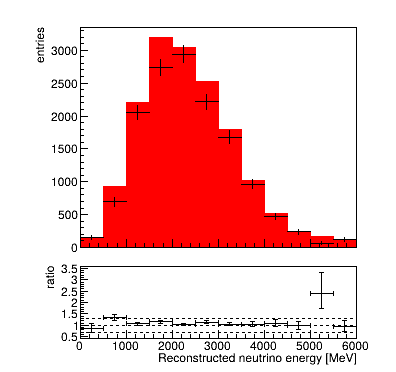

In [ ]:


nbin = 12

h_C_graf = df_time.Filter('Where_int == "Graphite" && target == "tgt:1000060120"') \
                   .Histo1D(("h_C_graf", "", nbin, 0, 6000), "nu_Ereco")

h_C_pl = df_time.Filter('Where_int == "C3H6" && target == "tgt:1000060120"') \
                 .Histo1D(("h_C_pl", "", nbin, 0, 6000), "nu_Ereco")


h_C_graf.GetPtr().Scale(5.25)


h_C_pl.GetPtr().SetLineColor(ROOT.kRed)
h_C_pl.GetPtr().SetFillColor(ROOT.kRed)
h_C_graf.GetPtr().SetLineColor(ROOT.kBlack)


cRP = ROOT.TCanvas("c", "RatioPlot", 400, 400)
#cRP.SetLeftMargin(0.50)

rp = ROOT.TRatioPlot(h_C_pl.GetPtr(), h_C_graf.GetPtr())
rp.Draw()


rp.GetUpperRefYaxis().SetTitle("entries")
rp.GetLowerRefYaxis().SetTitle("ratio")
rp.GetLowerRefXaxis().SetTitle("Reconstructed neutrino energy [MeV]")
rp.GetUpperRefXaxis().SetTitle("Reconstructed neutrino energy [MeV]")

rp.GetUpperPad().SetLeftMargin(0.20)
rp.GetLowerPad().SetLeftMargin(0.20)
# Optional styling
#rp.GetUpperPad().SetGrid()
#rp.GetLowerPad().SetGrid()

# If you want to set ratio range:
# rp.GetLowerRefYaxis().SetRangeUser(0, 3)

cRP.Update()
cRP.SaveAs("C_evt.pdf")
cRP.SaveAs("C_evt.png")

cell to close the file 

In [83]:
f_out.Close()

HISTOGRAMS FOR THE UNFOLDING

In [84]:
f_unfolding = ROOT.TFile("solid_H_histo_unfolding_26_11.root", "CREATE")

response matrix

1869

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


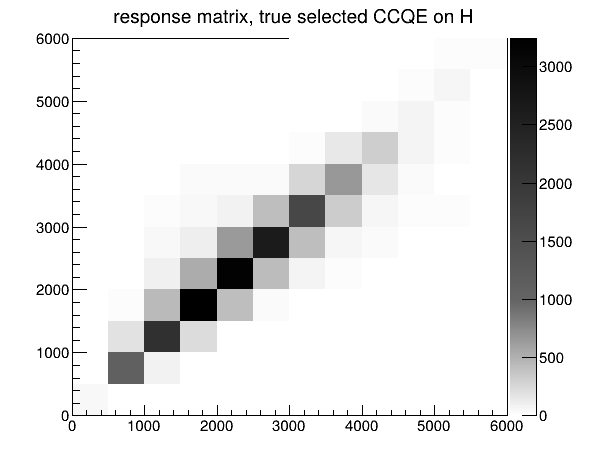

In [85]:

h_matrix = df_flag.Filter('true_flag == 1 && volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1 && time_flag == 1 && target == "tgt:1000010010"').Histo2D(("h_matrix", " response matrix, true selected CCQE on H ", 12, 0, 6000, 12, 0, 6000), "nu_Ereco", "Enu")
ROOT.gStyle.SetOptStat(0)

c_m = TCanvas("c", "Canvas", 600, 500)
c_m.SetLeftMargin(0.12)
c_m.SetRightMargin(0.15)   # serve spazio per la barra dei colori
c_m.SetBottomMargin(0.12)
c_m.SetTopMargin(0.08)
# c.SetLogz()
#c.SaveAs("nu_E_RecoVsTrue_25_09.png")
h_matrix.Draw("COLZ")

c_m.Draw()

f_unfolding.cd()
h_matrix.GetValue().Write()

True signal true energy 

338

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


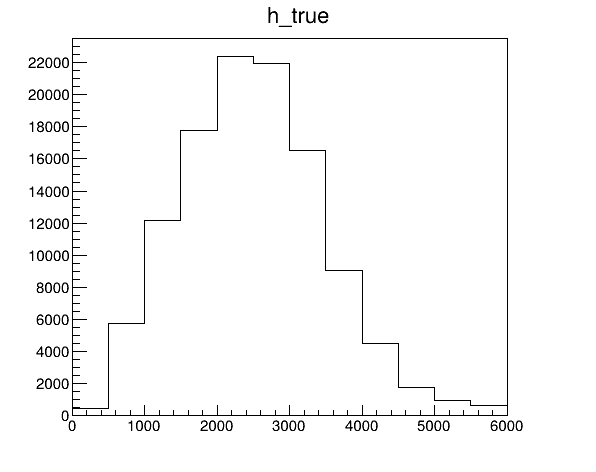

In [86]:
#sono i true anche selezionati o solo i true?
ROOT.gStyle.SetOptStat(0)

nbin = 12

h_true = df_flag.Filter('true_flag == 1 && volume_flag == 1 && target == "tgt:1000010010"').Histo1D(("h_true", "h_true", nbin, 0, 6000),"Enu")

c_t = TCanvas("c", "Canvas", 600, 500)
c_t.SetLeftMargin(0.12)
c_t.SetRightMargin(0.15)   # serve spazio per la barra dei colori
c_t.SetBottomMargin(0.12)
c_t.SetTopMargin(0.08)
# c.SetLogz()
#c.SaveAs("nu_E_RecoVsTrue_25_09.png")
h_true.Draw("COLZ")

c_t.Draw()

f_unfolding.cd()
h_true.GetValue().Write()


True signal reco energy 

334

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


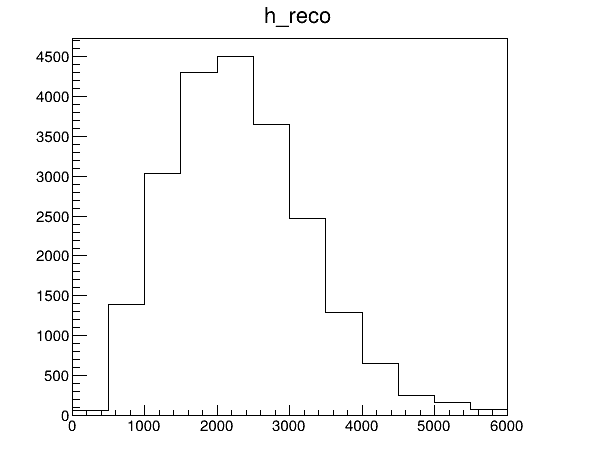

In [87]:

ROOT.gStyle.SetOptStat(0)

nbin = 12

h_reco = df_flag.Filter('volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1 && time_flag == 1 && target == "tgt:1000010010"').Histo1D(("h_reco", "h_reco", nbin, 0, 6000),"nu_Ereco")


c_r = TCanvas("c", "Canvas", 600, 500)
c_r.SetLeftMargin(0.12)
c_r.SetRightMargin(0.15)   # serve spazio per la barra dei colori
c_r.SetBottomMargin(0.12)
c_r.SetTopMargin(0.08)
h_reco.Draw("COLZ")

c_r.Draw()

f_unfolding.cd()
h_reco.GetValue().Write()

selection on CH 

337

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


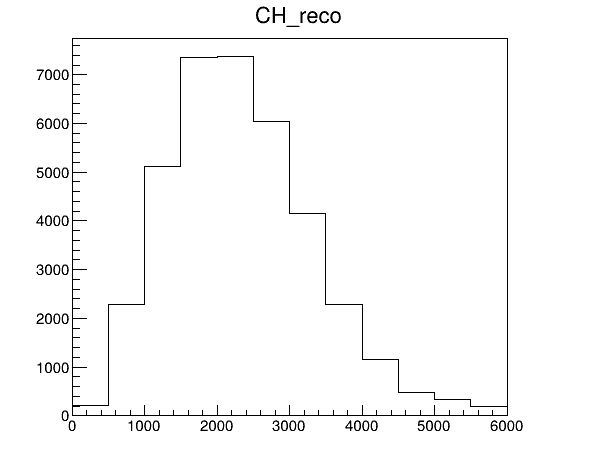

In [88]:

ROOT.gStyle.SetOptStat(0)

nbin = 12

CH_reco = df_flag.Filter('volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1 && time_flag == 1 && Where_int == "C3H6" ').Histo1D(("CH_reco", "CH_reco", nbin, 0, 6000),"nu_Ereco")


c_CH = TCanvas("c", "Canvas", 600, 500)
c_CH.SetLeftMargin(0.12)
c_CH.SetRightMargin(0.15)   # serve spazio per la barra dei colori
c_CH.SetBottomMargin(0.12)
c_CH.SetTopMargin(0.08)
# c.SetLogz()
#c.SaveAs("nu_E_RecoVsTrue_25_09.png")
CH_reco.Draw("COLZ")

c_CH.Draw()

f_unfolding.cd()
CH_reco.GetValue().Write()

0

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Error in <TFile::WriteTObject>: Directory solid_H_histo_unfolding_26_11.root is not writable


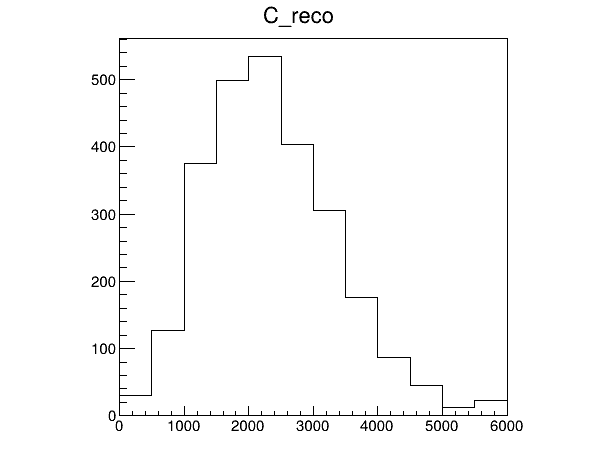

In [106]:

ROOT.gStyle.SetOptStat(0)

nbin = 12

C_reco = df_flag.Filter('volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1 && time_flag == 1 && Where_int == "Graphite" && target == "tgt:1000060120"').Histo1D(("C_reco", "C_reco", nbin, 0, 6000),"nu_Ereco")


c_C = TCanvas("c", "Canvas", 600, 500)
c_C.SetLeftMargin(0.20)
c_C.SetRightMargin(0.15)   # serve spazio per la barra dei colori
c_C.SetBottomMargin(0.12)
c_C.SetTopMargin(0.08)

C_reco.Draw("COLZ")

c_C.Draw()

f_unfolding.cd()
C_reco.GetValue().Write()

acceptance and effciency 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


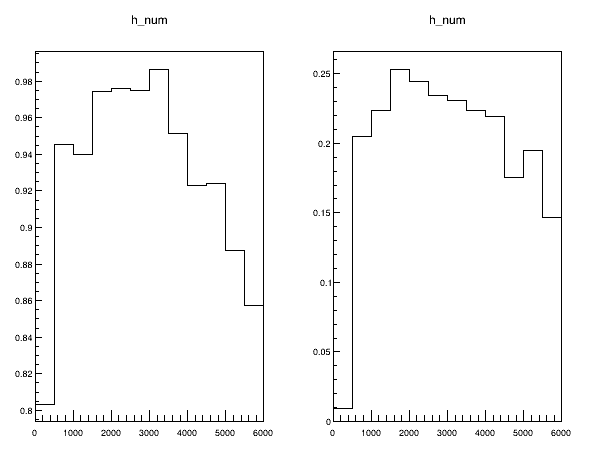

In [90]:
nbin= 12

h_num = df_flag.Filter('true_flag == 1 && volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1 && time_flag == 1 && target == "tgt:1000010010"').Histo1D(("h_num", "h_num", nbin, 0, 6000),"nu_Ereco")

h_den_a = df_flag.Filter('volume_flag == 1 && reco_flag == 1 && track_flag == 1 && space_flag == 1 && time_flag == 1 && target == "tgt:1000010010"').Histo1D(("h_den_a", "h_den_a", nbin, 0, 6000),"nu_Ereco")
h_den_e = df_flag.Filter('true_flag == 1 && target == "tgt:1000010010"').Histo1D(("h_den_e", "h_den_e", nbin, 0, 6000),"nu_Ereco")



h_num_hist = h_num.GetValue()
h_den_hist_a = h_den_a.GetValue()
h_den_hist_e = h_den_e.GetValue()

h_accep = h_num_hist.Clone("h_accep")
h_accep.Divide(h_den_hist_a) 


h_eff = h_num_hist.Clone("h_eff")
h_eff.Divide(h_den_hist_e)

c = TCanvas("c", "Canvas", 600, 500)
c.Divide(2,1)
c.SetLeftMargin(0.12)
c.SetRightMargin(0.15)   
c.SetBottomMargin(0.12)
c.SetTopMargin(0.08)

c.cd(1)
h_accep.Draw()


c.cd(2)
h_eff.Draw()



c.Draw()



# f_unfolding.cd()
# h_accep.Write()
# h_eff.Write()


In [91]:
f_unfolding.Close()